In this notebook we include the main processing of the PHEME-9 dataset, to process and obtain the data for the simulator, based on results from the other notebooks.

#Imports

Import necessary packages.

In [ ]:
#Plots
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
}
plt.rcParams.update(params)

#Seaborn & color
import seaborn as sns
sns.set(style="darkgrid")
sns.set_palette(sns.color_palette("pastel"))

#Obtención de resultados
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Training
import time

#Se ignoran las advertencias
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [ ]:
import colorcet as cc
import newspaper
from newspaper import Config
import waybackpy
from waybackpy import WaybackMachineCDXServerAPI

In [ ]:
import pandas as pd
import networkx as nx
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from datetime import datetime, timedelta
import json
from scipy.stats import entropy
import math
import statistics
from scipy.stats import zscore
from matplotlib.colors import LinearSegmentedColormap

from time import sleep
import requests
from bs4 import BeautifulSoup

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import contractions
import string

nltk.download('wordnet')
tk = TweetTokenizer(strip_handles=False)
nltk.download('omw-1.4')
nltk.download('stopwords')

# Prepare dataset

We start preparing the dataset.

## Load comments

We load the comments into one df.

In [ ]:
path_to_dataset = 'path_to_dataset'
path = path_to_dataset + 'PHEME_dataset/phemerumourschemedataset/pheme-rumour-scheme-dataset/threads/en'
path_sav = 'path_to_save'
list_themes = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path,f))]

In [ ]:
annotation_replies = pd.read_json(os.path.join(os.path.join("/".join(path.split('/')[:-2]),'annotations'), 'en_annotations_replies.json'), lines=True, dtype={'tweetid': 'int64', 'threadid': 'int64'}) #annotations
annotation_sources = pd.read_json(os.path.join(os.path.join("/".join(path.split('/')[:-2]),'annotations'), 'en_annotations_sources.json'), lines=True, dtype={'tweetid': 'int64', 'threadid': 'int64'})

In [ ]:
list_an = []
for elem in list_themes:
  annotations = []
  print(f"FOR ELEM {elem}")
  path_el = os.path.join(path, elem)
  dir_folders = [f for f in os.listdir(path_el) if (not os.path.isfile(os.path.join(path_el, f)) and (not f.startswith('a')))]
  for f in dir_folders:
    with open(os.path.join(path_el, f)+'/annotation.json') as fp:
      data = json.load(fp)
    annotations.append(pd.DataFrame([data], columns=data.keys()))
  ans = pd.concat(annotations)
  ans = ans.reset_index()
  list_an.append(ans)
  ans['thread_id'] = dir_folders
  list_cats = list(dict(ans.category.value_counts()).keys())
  list_numbs = list(dict(ans.category.value_counts()).values())
  c = Counter(list_numbs)

FOR ELEM charliehebdo_good
FOR ELEM ebola-essien
FOR ELEM ferguson
FOR ELEM germanwings-crash
FOR ELEM ottawashooting
FOR ELEM prince-toronto
FOR ELEM putinmissing
FOR ELEM sydneysiege


In [ ]:
list_ans = []
for elem in list_themes:
  print(f"FOR ELEM {elem}")
  path_el = os.path.join(path, elem)
  dir_folders = [f for f in os.listdir(path_el) if (not os.path.isfile(os.path.join(path_el, f)) and (not f.startswith('a')))]
  file_sources = [os.path.join(os.path.join(os.path.join(path_el, f),'source-tweets'), os.listdir(os.path.join(os.path.join(path_el, f),'source-tweets'))[0]) for f in dir_folders]
  sources = [pd.read_json(f, lines=True) for f in file_sources]
  for i, sou in enumerate(sources):
    sou['thread'] = file_sources[i].rsplit('/')[10]
    sou['gen_theme'] = elem
    folder_th_url = file_sources[i].rsplit('source-tweets')[0] + 'urls.dat'
    contained = {}
    with open(folder_th_url, 'r', encoding='utf-8') as file_url:
      while True:
        file_line = file_url.readline()
        if not file_line:
          break
        lst_info = file_line.split('\t')
        contained[lst_info[1]] = (lst_info[2], lst_info[0])


    urls = sou.entities[0]['urls']
    if len(urls) > 0:
      sou['url_extracted_an'] = urls[0]['expanded_url']
      sou['url_extracted_full'] = contained[urls[0]['expanded_url']][0]
      sou['identifier'] = contained[urls[0]['expanded_url']][1]
    else:
      sou['url_extracted_an'] = None
      sou['url_extracted_full'] = None

  ans2 = pd.concat(sources)
  ans2 = ans2.reset_index()
  list_ans.append(ans2)

FOR ELEM charliehebdo_good
FOR ELEM ebola-essien
FOR ELEM ferguson
FOR ELEM germanwings-crash
FOR ELEM ottawashooting
FOR ELEM prince-toronto
FOR ELEM putinmissing
FOR ELEM sydneysiege


In [ ]:
def assign_class(misinfo, true):
  if misinfo == 1:
    return 'Fake'
  if true == 1:
    return 'True'
  return 'Undefined'
for elem in list_an:
  if 'true' in elem.columns:
    elem['class'] = elem.apply(lambda row: assign_class(row.misinformation, row.true), axis=1)
  else:
    elem['class'] = elem.apply(lambda row: assign_class(row.misinformation, 0), axis=1)


In [ ]:
list_merged = []
for an2, an1 in zip(list_ans, list_an):
  selected = ['thread_id', 'category', 'class', 'links', 'is_rumour', 'misinformation']
  if 'true' in an1.columns:
    selected.append('true')
  if 'is_turnaround' in an1.columns:
    selected.append('is_turnaround')

  list_merged.append(pd.merge(an2, an1[selected], left_on='thread', right_on='thread_id'))

In [ ]:
concat_stuff = pd.concat(list_merged)

In [ ]:
not_found = []
list_dfs = []
for elem_th in list_themes: # por cada tema

  print(f"FOR ELEM {elem_th}")
  path_el = os.path.join(path, elem_th)
  dir_folders = [f for f in os.listdir(path_el) if (not os.path.isfile(os.path.join(path_el, f)) and (not f.startswith('a')))]

  for el in dir_folders: # por cada hilo
    path_thr = os.path.join(os.path.join(path_el, el),'reactions')
    file_reactions = [os.path.join(path_thr, f) for f in os.listdir(path_thr)] # extraer comentarios

    theme_rum = []
    id = []
    support = []
    resp_vs_source = []
    resp_vs_prev = []
    evidence = []
    certain = []
    rumour = []
    misinfo = []
    true = []
    turnaround = []
    original = []


    source = pd.read_json(os.path.join(os.path.join(os.path.join(path_el, el),'source-tweets'), os.listdir(os.path.join(os.path.join(path_el, el),'source-tweets'))[0]), lines=True, dtype={'id': 'int64', 'in_reply_to_status_id': 'int64'})
    id.append('source')
    theme_rum.append(elem_th)
    support.append( annotation_sources[annotation_sources['tweetid'] == source.id.iloc[0]]['support'].iloc[0] )
    resp_vs_source.append("")
    resp_vs_prev.append("")
    original.append(el)
    evidence.append( annotation_sources[annotation_sources['tweetid'] == source.id.iloc[0]]['evidentiality'].iloc[0] )
    certain.append( annotation_sources[annotation_sources['tweetid'] == source.id.iloc[0]]['certainty'].iloc[0] )
    rumour.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['is_rumour'].iloc[0])
    misinfo.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['misinformation'].iloc[0])
    true.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['true'].iloc[0])
    turnaround.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['is_turnaround'].iloc[0])

    list_reactions = [pd.read_json(f, lines=True, dtype={'id': 'int64', 'in_reply_to_status_id': 'int64'}) for f in file_reactions] # meter reacciones en lista de df
    reactions = pd.concat(list_reactions) # todas reacciones en un pandas
    for idx, elem in reactions.iterrows():
      id.append('reaction')
      theme_rum.append(elem_th)
      support.append( annotation_sources[annotation_sources['tweetid'] == source.id.iloc[0]]['support'].iloc[0] )
      original.append(el)
      rumour.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['is_rumour'].iloc[0])
      misinfo.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['misinformation'].iloc[0])
      turnaround.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['is_turnaround'].iloc[0])
      true.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['true'].iloc[0])

      if len(annotation_replies[annotation_replies['tweetid'] == elem.id]) == 0: # elemento no está
        not_found.append((elem.id, elem.lang, el))
        resp_vs_source.append("")
        resp_vs_prev.append("")
        evidence.append("")
        certain.append("")
      else:
        resp_vs_source.append(annotation_replies[annotation_replies['tweetid'] == elem.id]['responsetype-vs-source'].iloc[0] )
        resp_vs_prev.append(annotation_replies[annotation_replies['tweetid'] == elem.id]['responsetype-vs-previous'].iloc[0] )
        evidence.append(annotation_replies[annotation_replies['tweetid'] == elem.id]['evidentiality'].iloc[0] )
        certain.append(annotation_replies[annotation_replies['tweetid'] == elem.id]['certainty'].iloc[0] )


    if os.path.exists(os.path.join(os.path.join(path_el, el),'retweets.json')):
      retweets = pd.read_json(os.path.join(os.path.join(path_el, el),'retweets.json'), dtype={'id': 'int64', 'in_reply_to_status_id': 'int64'}, lines=True) # retweets
    else:
      retweets = pd.DataFrame()

    for idx, elem in retweets.iterrows():
      id.append('retweet')

      theme_rum.append(elem_th)
      original.append(el)

      support.append( annotation_sources[annotation_sources['tweetid'] == source.id.iloc[0]]['support'].iloc[0] )
      resp_vs_source.append("")
      resp_vs_prev.append("")
      evidence.append( "")
      certain.append( "")
      rumour.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['is_rumour'].iloc[0])
      misinfo.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['misinformation'].iloc[0])
      turnaround.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['is_turnaround'].iloc[0])
      true.append(concat_stuff[concat_stuff['id'] == source.id.iloc[0]]['true'].iloc[0])


    # combinar todo
    df = pd.concat([source, reactions, retweets])
    df['type_content'] = id
    df['support'] = support
    df['responsetype-vs-source'] = resp_vs_source
    df['responsetype-vs-previous'] = resp_vs_prev
    df['certainty'] = certain
    df['evidentiality'] = evidence
    df['is_rumour'] = rumour
    df['misinformation'] = misinfo
    df['true'] = true
    df['is_turnaround'] = turnaround
    df['thread_from'] = original
    df['theme'] = theme_rum
    list_dfs.append(df)
    #structure = pd.read_json(os.path.join(os.path.join(path_el, el),'structure.json'), lines=True) # estructura

FOR ELEM charliehebdo_good
FOR ELEM ebola-essien
Annotated TW in pt (521350130851921921), response type: comment, text @FootballcomEN MEU DEUS OLHA ISSO @MikellySuarez
Annotated TW in pt (521367512551002112), response type: comment, text @LuigiLouco999 @FootballcomEN O QUE TEM O MEU HOMEM??
Annotated TW in pt (521371539082858496), response type: comment, text @MikellySuarez @FootballcomEN ele tá com ebola
Annotated TW in pt (521371742942797825), response type: comment, text @LuigiLouco999 @FootballcomEN DEUS E MAIS E SEROO ISSO?
Annotated TW in fr (521468848466591744), response type: comment, text @Gonzoradlife @FutbolLife @Carlosisking7 woah wtf 😩
FOR ELEM ferguson
FOR ELEM germanwings-crash
FOR ELEM ottawashooting
Annotated TW in es (524933104742723584), response type: comment, text @kellyoxford Oh Canada….
FOR ELEM prince-toronto
FOR ELEM putinmissing
FOR ELEM sydneysiege


We have included the comments with their source, and other metrics from the annotations.

In [ ]:
for elem in list_dfs:
  elem['category'] = concat_stuff[concat_stuff['thread_id'] == elem.iloc[0]['thread_from']].iloc[0]['category']

In [ ]:
comments = pd.concat(list_dfs).reset_index(drop=True)

In [ ]:
comments = comments.astype({'thread_from':'Int64', 'in_reply_to_user_id': 'Int64', 'in_reply_to_status_id': 'Int64', 'in_reply_to_status_id_str':'str', 'in_reply_to_user_id_str':'str'})  #in_reply_to_status_id_str, in_reply_to_user_id_str, in_reply_to_user_id, in_reply_to_status_id

In [ ]:
def add_user_name(user_dict):
  return user_dict['name']

def add_user_verif(user_dict):
  return user_dict['verified']

def add_user_date_create(user_dict):
  return user_dict['created_at'][-4:]

def extr_user(x):
  return x['id_str']

In [ ]:
comments['user_posted_name'] = comments['user'].apply(lambda x: add_user_name(x))

comments['user_id_srt'] = comments['user'].apply(lambda x: extr_user(x))

comments['class_rumour'] = comments.apply(lambda x: 'FAKE' if x.misinformation else ('TRUE' if x.true else 'UNDEF'), axis=1)

comments['user_verified'] = comments['user'].apply(lambda x: add_user_verif(x))

comments['user_date_create'] = comments['user'].apply(lambda x: add_user_date_create(x))

We save the comments file.

In [ ]:
comments.to_json(path_sav + 'comments.json')

Now we obtain some stats from the sources, such as their followers or total RTs...

In [ ]:
# por cada conversación, summary
timestep = 10 # segundos
list_information_thread = []
for conversation in list_dfs:

  source = conversation.iloc[0]
  theme = source.theme
  id = source.id
  reactions = conversation[conversation['type_content'] == 'reaction']
  retweets = conversation[conversation['type_content'] == 'retweet']

  num_rt = len(conversation[conversation['type_content'] == 'retweet'])
  num_react = len(conversation[conversation['type_content'] == 'reaction'])

  isrumour = source.is_rumour
  turnaround = source.is_turnaround
  supports = source.support
  misinfor = source.misinformation
  true = source.true
  evidence = source.evidentiality
  certainty = source.certainty
  categ = source.category

  react_agree = len(reactions[reactions["responsetype-vs-source"] == "agreed"])
  react_disagree = len(reactions[reactions["responsetype-vs-source"] == "disagreed"])
  appeal_info = len(reactions[reactions["responsetype-vs-source"] == "appeal-for-more-information"])
  comment = len(reactions[reactions["responsetype-vs-source"] == "comment"])

  certainish = len(reactions[reactions["certainty"] == "certain"]) + len(reactions[reactions["certainty"] == "somewhat-certain"])
  uncertain = len(reactions[reactions["certainty"] == "uncertain"])
  other = len(reactions[reactions["certainty"] == "underspecified"])

  witness = len(reactions[reactions["evidentiality"] == "witnessed"])
  pic = len(reactions[reactions["evidentiality"] == "picture-attached"])
  urls = len(reactions[reactions["evidentiality"] == "url-given"])
  quote = len(reactions[reactions["evidentiality"] == "source-quoted"])
  unverified = len(reactions[reactions["evidentiality"] == "unverifiable-source-quoted"])
  reasoning = len(reactions[reactions["evidentiality"] == "reasoning"])
  no_ev = len(reactions[reactions["evidentiality"] == "no-evidence"])

  #print("Summary:")
  #print(f"Source is {source.is_rumour}, {'fake' if source.misinformation == 0 else 'real'}, with {source.evidentiality} and {source.certainty}. Achieved {len(retweets)} RTs and {len(reactions)} reactions of which:")
  #print(f'>> Agree {len(reactions[reactions["responsetype-vs-source"] == "agreed"])}, Disagree  {len(reactions[reactions["responsetype-vs-source"] == "disagreed"])}, Appeal info {len(reactions[reactions["responsetype-vs-source"] == "appeal-for-more-information"])}, Comment {len(reactions[reactions["responsetype-vs-source"] == "comment"])}')
  #print(f'>> Certain-ish {len(reactions[reactions["certainty"] == "certain"]) + len(reactions[reactions["certainty"] == "somewhat-certain"])}, Uncertain  {len(reactions[reactions["certainty"] == "uncertain"])}, Other {len(reactions[reactions["certainty"] == "underspecified"])}')
  #print(f'>> URL {len(reactions[reactions["evidentiality"] == "url-given"])}, Quote  {len(reactions[reactions["evidentiality"] == "source-quoted"])}, Witness {len(reactions[reactions["evidentiality"] == "witnessed"])}, Picture {len(reactions[reactions["evidentiality"] == "picture-attached"])}, Unverified {len(reactions[reactions["evidentiality"] == "unverifiable-source-quoted"])}, Reasoning {len(reactions[reactions["evidentiality"] == "reasoning"])}, No evidence {len(reactions[reactions["evidentiality"] == "no-evidence"])}')
  #print(f'For this convo, starting on {conversation.iloc[0]["support"]}, with {conversation.iloc[0]["evidentiality"]} evidence and {conversation.iloc[0]["certainty"]}')

  df = pd.DataFrame(data=[])
  df['is_rumour'] = [isrumour]
  df['theme'] = [theme]
  df['id'] = [id]
  df['is_turnaround'] = [turnaround]
  df['misinformation'] = [misinfor]
  df['true'] = [true]
  df['category'] = [categ]
  df['source_support'] = [supports]
  df['source_evidence'] = [evidence]
  df['source_certainty'] = [certainty]

  df['num_rts'] = [num_rt]
  df['num_react'] = [num_react]

  df['react_agree'] = [react_agree]
  df['react_disagree'] = [react_disagree]
  df['appeal_information'] = [appeal_info]
  df['comment'] = [comment]

  df['certain_reacts'] = [certainish]
  df['uncertain_reacts'] = [uncertain]
  df['other_reacts'] = [other]

  df['evi_witness_react'] = [witness]
  df['evi_pic_react'] = [pic]
  df['evi_urls_react'] = [urls]
  df['evi_quote_react'] = [quote]
  df['evi_unverified_react'] = [unverified]
  df['evi_reason_react'] = [reasoning]
  df['evi_none_react'] = [no_ev]

  list_information_thread.append(df)


We have rumors and breaking news.

In [ ]:
rumor_story = []
breaking_news = []
for elem in list_dfs: # cada conversación
  if elem.theme.iloc[0] in ['ebola-essien', 'prince-toronto', 'putinmissing']: #rumors only
    rumor_story.append(elem)
  else:
    breaking_news.append(elem)

In [ ]:
rumor_story_filt = []
breaking_news_filt = []
for elem in list_information_thread: # cada conversación
  if elem.iloc[0].theme in ['ebola-essien', 'prince-toronto', 'putinmissing']: #rumors only
    rumor_story_filt.append(elem)
  else:
    breaking_news_filt.append(elem)

In [ ]:
rumour_stats = pd.concat(rumor_story_filt)
news_stats = pd.concat(breaking_news_filt)

In [ ]:
def determine_cl(misinfo, true):
  if misinfo == 1:
    return 'fake'
  if true == 1:
    return 'true'
  return 'undefined'

In [ ]:
rumour_stats['misinfo_class'] = rumour_stats.apply(lambda row: determine_cl(row.misinformation, row.true), axis=1) # stats rumores en 1
news_stats['misinfo_class'] = news_stats.apply(lambda row: determine_cl(row.misinformation, row.true), axis=1) # stats noticias en 1

In [ ]:
for elem in breaking_news: # noticias
  elem['misinfo_class'] = elem.apply(lambda row: determine_cl(row.misinformation, row.true), axis=1)

for elem in rumor_story: #rumores
  elem['misinfo_class'] = elem.apply(lambda row: determine_cl(row.misinformation, row.true), axis=1)

for elem in rumor_story_filt: #stats rumores
  elem['misinfo_class'] = elem.apply(lambda row: determine_cl(row.misinformation, row.true), axis=1)

for elem in breaking_news_filt: #stats noticias
  elem['misinfo_class'] = elem.apply(lambda row: determine_cl(row.misinformation, row.true), axis=1)

In [ ]:
vals_mean = list(rumour_stats['num_rts'])
vals_mean2 = list(news_stats['num_rts'])
vals = vals_mean + vals_mean2
import statistics
mean_v = statistics.mean(vals)
stdev_v = statistics.stdev(vals)

In [ ]:
rumour_stats['z_val_rts'] = rumour_stats['num_rts'].apply(lambda x: (x - mean_v) / stdev_v)

news_stats['z_val_rts'] = news_stats['num_rts'].apply(lambda x: (x - mean_v) / stdev_v)

In [ ]:
def ratio(upper, lower):

  if lower == 0: # indet
    return 0

  return upper / lower

In [ ]:
news_stats['ratio_support'] = news_stats.apply(lambda row: ratio(row.react_agree, (row.react_agree + row.react_disagree + row.appeal_information)), axis=1)
rumour_stats['ratio_support'] = rumour_stats.apply(lambda row: ratio(row.react_agree, (row.react_agree + row.react_disagree + row.appeal_information)), axis=1)

In [ ]:
news_stats['ratio_discuss'] = news_stats.apply(lambda row: ratio((row.react_agree + row.react_disagree + row.appeal_information), (row.react_agree + row.react_disagree + row.appeal_information + row.comment)), axis=1)
rumour_stats['ratio_discuss'] = rumour_stats.apply(lambda row: ratio((row.react_agree + row.react_disagree + row.appeal_information), (row.react_agree + row.react_disagree + row.appeal_information + row.comment)), axis=1)

In [ ]:
news_stats['ratio_evi'] = news_stats.apply(lambda row: ratio((row.evi_witness_react + row.evi_pic_react + row.evi_urls_react + row.evi_quote_react + row.evi_reason_react), (row.evi_witness_react + row.evi_pic_react + row.evi_urls_react + row.evi_quote_react + row.evi_reason_react + row.evi_unverified_react + row.evi_none_react)), axis=1)
rumour_stats['ratio_evi'] = rumour_stats.apply(lambda row: ratio((row.evi_witness_react + row.evi_pic_react + row.evi_urls_react + row.evi_quote_react+ row.evi_reason_react), (row.evi_witness_react + row.evi_pic_react + row.evi_urls_react + row.evi_quote_react + row.evi_reason_react + row.evi_unverified_react + row.evi_none_react)), axis=1)

In [ ]:
news_stats['ratio_cert'] = news_stats.apply(lambda row: ratio(row.certain_reacts, (row.certain_reacts + row.uncertain_reacts + row.other_reacts)), axis=1)
rumour_stats['ratio_cert'] = rumour_stats.apply(lambda row: ratio(row.certain_reacts, (row.certain_reacts + row.uncertain_reacts + row.other_reacts)), axis=1)

Now we obtain info from the comments.

In [ ]:
temp_dfs = pd.concat(list_dfs)

In [ ]:
def has_pic(entities_va):

  if str(entities_va) == 'nan':
    return False
  else:
    if (entities_va['media'][0]['type'] == 'photo'):
      return True
    return False

In [ ]:
rumour_stats['text'] = rumour_stats['id'].apply(lambda x: concat_stuff[concat_stuff['id'] == x].iloc[0]['text'])
news_stats['text'] = news_stats['id'].apply(lambda x: concat_stuff[concat_stuff['id'] == x].iloc[0]['text'])

In [ ]:
rumour_stats['followers'] = rumour_stats['id'].apply(lambda x: comments[comments['id'] == x].iloc[0]['user']['followers_count'])
news_stats['followers'] = news_stats['id'].apply(lambda x: comments[comments['id'] == x].iloc[0]['user']['followers_count'])

In [ ]:
news_stats['sourced_from'] = 'news'
rumour_stats['sourced_from'] = 'rumours'

Concat into one.

In [ ]:
sources_stats = pd.concat([news_stats, rumour_stats]).reset_index()

In [ ]:

sources_stats['diffusion'] = sources_stats[['num_rts', 'num_react']].apply(lambda row: row.num_react + row.num_rts, axis=1)

sources_stats['verified'] = sources_stats['id'].apply(lambda x: comments[comments['id'] == x].iloc[0]['user']['verified'])
sources_stats['friends_count'] = sources_stats['id'].apply(lambda x: comments[comments['id'] == x].iloc[0]['user']['friends_count'])
sources_stats['statuses_count'] = sources_stats['id'].apply(lambda x: comments[comments['id'] == x].iloc[0]['user']['statuses_count'])
sources_stats['favourites_count'] = sources_stats['id'].apply(lambda x: comments[comments['id'] == x].iloc[0]['user']['favourites_count'])

sources_stats['combined_reaction'] = sources_stats[['num_rts', 'num_react']].apply(lambda row: row.num_react + row.num_rts, axis=1)
sources_stats['entities'] = sources_stats['id'].apply(lambda x: has_pic(concat_stuff[concat_stuff['id'] == x].iloc[0]['extended_entities']))

sources_stats['diff'] = sources_stats['combined_reaction']

We save it for later use.

In [ ]:
sources_stats.to_json(path_sav + 'source_stats.json')

## Emotions

We obtain the emotions from the tweets.

In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [ ]:
comments = pd.read_json(path + 'comments.json')

In [ ]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
# import packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
pred_texts = comments['text'].dropna().astype('str').tolist()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [ ]:
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# scores
for i in range(len(pred_texts)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

In [ ]:
# DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(comments['id'], comments['user'], comments['thread_from'], comments['theme'], pred_texts, preds, labels, scores, anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['id', 'user', 'thread_from', 'theme', 'text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
df.head()

id                                               user  \
0  552783667052167168  {'follow_request_sent': False, 'profile_use_ba...   
1  552785374507175936  {'follow_request_sent': False, 'profile_use_ba...   
2  552786226546495488  {'follow_request_sent': False, 'profile_use_ba...   
3  552789153403109376  {'follow_request_sent': False, 'profile_use_ba...   
4  552789345628069888  {'follow_request_sent': False, 'profile_use_ba...   

          thread_from              theme  \
0  552783667052167168  charliehebdo_good   
1  552783667052167168  charliehebdo_good   
2  552783667052167168  charliehebdo_good   
3  552783667052167168  charliehebdo_good   
4  552783667052167168  charliehebdo_good   

                                                text  pred     label  \
0  France: 10 people dead after shooting at HQ of...     5   sadness   
1  MT @euronews France: 10 dead after shooting at...     5   sadness   
2  @j0nathandavis They who? Stupid and partial op...     6  surprise   
3  @euronews @Massimilian2611 ci vuole una nuova ...     5   sadness   
4  @nanoSpawn Socialists, Antisemites, anti zioni...     0     anger   

      score     anger   disgust      fear       joy   neutral   sadness  \
0  0.506653  0.149144  0.002438  0.321371  0.007136  0.002548  0.506653   
1  0.561277  0.126553  0.000876  0.278497  0.016780  0.002067  0.561277   
2  0.440791  0.405434  0.002668  0.009701  0.012955  0.069281  0.059171   
3  0.221289  0.095489  0.000661  0.198662  0.134633  0.215706  0.221289   
4  0.315119  0.315119  0.000911  0.118254  0.064465  0.259382  0.141109   

   surprise  
0  0.010709  
1  0.013950  
2  0.440791  
3  0.133559  
4  0.100761

We show the distribution of emotions.

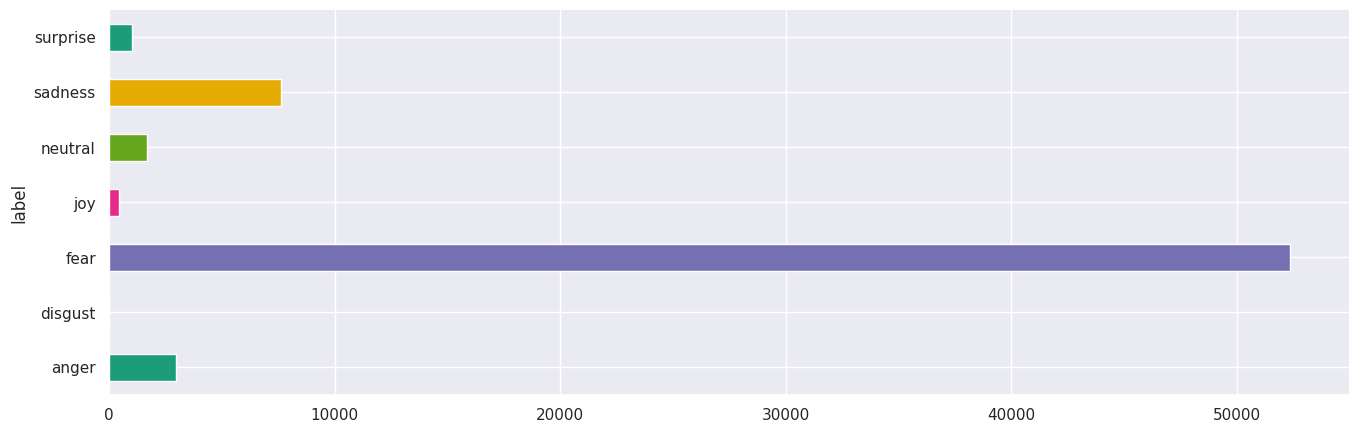

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Makes sense, considering most news are shootings... We save the results.

In [ ]:
# save results
df.to_json(path + 'comments_emotions.json')

In [ ]:
comments['label'] = comments['id'].apply(lambda x: df[df['id'] == x].iloc[0]['label'] )

## Combine net

Now we combine the net into one full network, and smaller networks where the sources are the same. For other analysis.

In [ ]:
path_nets = 'path_to_combined_nets'

In [ ]:
comb = []
for idx, elem in enumerate(list_themes, 0):
  print(f"FOR ELEM {elem}")
  path_el = os.path.join(path, elem)
  dir_folders = [f for f in os.listdir(path_el) if not os.path.isfile(os.path.join(path_el, f))]
  annotations = [pd.read_json(os.path.join(path_el, f)+'/annotation.json', lines=True) for f in dir_folders]

  for elem2 in dir_folders:
    file_followers = os.path.join(path_el, elem2) + '/who-follows-whom.dat'

    file = open(os.path.join(path_el, elem2)+'/who-follows-whom.dat')
    comb.append(file.readlines())
    file.close()
total = [''.join(i) for i in comb]
res = ''.join(total)
if not os.path.exists(os.path.join(path_nets, 'full_net')):
  os.makedirs(os.path.join(path_nets, 'full_net'))
  with open(os.path.join(path_nets, 'full_net') +'/followers.dat', 'w') as file:
    file.write(res)

FOR ELEM charliehebdo_good
FOR ELEM ebola-essien
FOR ELEM ferguson
FOR ELEM germanwings-crash
FOR ELEM ottawashooting
FOR ELEM prince-toronto
FOR ELEM putinmissing
FOR ELEM sydneysiege


In [ ]:
for idx, elem in enumerate(list_themes, 0):
  print(f"FOR ELEM {elem}")
  path_el = os.path.join(path, elem)
  df_turns = list_an[idx]
  dir_folders = [f for f in os.listdir(path_el) if not os.path.isfile(os.path.join(path_el, f))]
  annotations = [pd.read_json(os.path.join(path_el, f)+'/annotation.json', lines=True) for f in dir_folders]
  ans = pd.concat(annotations)
  ans = ans.reset_index()
  for elem2 in list_cats:
    files_related = list(ans[ans.category == elem2].index)
    rel_topics = [dir_folders[i] for i in files_related]
    comb = []
    for el in rel_topics:
      file = open(os.path.join(path_el, el)+'/who-follows-whom.dat')
      comb.append(file.readlines())
      file.close()
    total = [''.join(i) for i in comb]
    res = ''.join(total)
    if not os.path.exists(os.path.join(path_nets, '_'.join(rel_topics))):
      os.makedirs(os.path.join(path_nets, '_'.join(rel_topics)))
    with open(os.path.join(path_nets, '_'.join(rel_topics))+'/followers.dat', 'w') as file:
      file.write(res)

FOR ELEM charliehebdo_good
FOR ELEM ebola-essien
FOR ELEM ferguson
FOR ELEM germanwings-crash
FOR ELEM ottawashooting
FOR ELEM prince-toronto
FOR ELEM putinmissing
FOR ELEM sydneysiege


In [ ]:
G = nx.DiGraph()
with open(path_nets + '/full_net/followers.dat', 'r', encoding='utf-8') as f:
	line = f.readline()
	while line:
		G.add_edge(line.split()[0], line.split()[1])
		line = f.readline()

In [ ]:
user_net = G.nodes

We add user info. This is for Gephi visualization.

In [ ]:
from urllib.parse import urlparse
dict_info = {}
def adding_info_graph(users):
  id = users['id_str']
  if not id in user_net:
    return
  verified = bool(users['verified'])
  followers = int(users['followers_count'])
  #created = 'None' if users['created_at'] == '' else users['created_at']
  created_year = int(1970) if users['created_at'] == '' else int(users['created_at'][-4:])
  status = int(users['statuses_count'])
  location = str('None') if users['location'] == '' else str(users['location'])
  description_len = int(len(users['description'])) if users['description'] else int(0)
  friends = int(users['friends_count'])
  name = str('None') if users['name'] == '' else str(users['name'])

  profile_img = bool(users['default_profile_image'])

  if (not isinstance(verified, bool)) or (not isinstance(profile_img, bool)) or (not isinstance(followers, int)) or (not isinstance(created_year, int)) or (not isinstance(status, int)) or (not isinstance(description_len, int)) or (not isinstance(friends, int)):
    print('WRONG TYPE')
  if (not isinstance(name, str)) or (not isinstance(location, str)):
    print('WROOONG TYPE')
  url = str('None')
  if 'entities' in users.keys():
    if 'url' in users['entities'].keys():
      if 'urls' in users['entities']['url']:
        if users['entities']['url']['urls'][0]['expanded_url']:
          domain = urlparse(users['entities']['url']['urls'][0]['expanded_url']).netloc
          url = str(domain)

  dict_info[id] = { 'verified': verified, 'followers': followers, 'created_year': created_year,
                   'status': status, 'location': location, 'description_len': description_len,
                    'friends': friends, 'name': name, 'url': url, 'has_profile_img' : profile_img}

comments['user'].apply(lambda x: adding_info_graph(x))

0        None
1        None
2        None
3        None
4        None
         ... 
66076    None
66077    None
66078    None
66079    None
66080    None
Name: user, Length: 66081, dtype: object

In [ ]:
nx.set_node_attributes(G, dict_info)

In [ ]:
list_nodes = list(G.nodes())

We add some other metrics based on the content users and neighbors interact with

In [ ]:
# para cada user de la red X
# sacar los tweets del usuario. X
# obtener X medidas. (meto en G?)
dict_info_adds = {}
for node in list_nodes:
  posted_user = comments[comments['user_posted_str'] == node]
  sources = posted_user[posted_user['type_content'] == 'source']
  rts = posted_user[posted_user['type_content'] == 'retweet']
  react = posted_user[posted_user['type_content'] == 'reaction']
  # believe fake (TRUE and DENY or FAKE and SUPPORT)
  belief_fake_source = len(sources[(sources['class_rumour'] == 'TRUE') & (sources['support'] == 'denying')]) \
                + len(sources[(sources['class_rumour'] == 'FAKE') & (sources['support'] == 'supporting')]) \
                + len(sources[(sources['class_rumour'] == 'UNDEF') & (sources['support'] == 'supporting')])

  belief_fake_rts = len(rts[(rts['class_rumour'] == 'TRUE') & (rts['support'] == 'denying')]) \
                + len(rts[(rts['class_rumour'] == 'FAKE') & (rts['support'] == 'supporting')]) \
                + len(rts[(rts['class_rumour'] == 'UNDEF') & (rts['support'] == 'supporting')])

  belief_fake_reac = len(react[(react['class_rumour'] == 'TRUE') & (react['support'] == 'denying') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'FAKE') & (react['support'] == 'supporting') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'UNDEF') & (react['support'] == 'supporting') & (react['responsetype-vs-source'] == 'agreed')])
  belief_fake = (belief_fake_source + belief_fake_rts + belief_fake_reac)

  belief_fake_lower = len(react) + len(sources) + len(rts)

  belief = 0 if belief_fake_lower == 0 else belief_fake / belief_fake_lower

  # TRUE story believer
  belief_true_source = len(sources[(sources['class_rumour'] == 'TRUE') & (sources['support'] == 'supporting')]) \
                + len(sources[(sources['class_rumour'] == 'FAKE') & (sources['support'] == 'denying')]) \
                + len(sources[(sources['class_rumour'] == 'UNDEF') & (sources['support'] == 'denying')])

  belief_true_rts = len(rts[(rts['class_rumour'] == 'TRUE') & (rts['support'] == 'supporting')]) \
                + len(rts[(rts['class_rumour'] == 'FAKE') & (rts['support'] == 'denying')]) \
                + len(rts[(rts['class_rumour'] == 'UNDEF') & (rts['support'] == 'denying')])

  belief_true_reac = len(react[(react['class_rumour'] == 'TRUE') & (react['support'] == 'supporting') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'FAKE') & (react['support'] == 'denying') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'UNDEF') & (react['support'] == 'denying') & (react['responsetype-vs-source'] == 'agreed')])
  belief_true = (belief_true_source + belief_true_rts + belief_true_reac)

  belief_true_lower = len(react) + len(sources) + len(rts)

  belief_true = 0 if belief_true_lower == 0 else belief_true / belief_true_lower

  # evidence giver (sources y reac)
  evidence_sources_upper = len(sources[(sources['evidentiality'] == 'url-given') | (sources['evidentiality'] == 'source-quoted') |
                            (sources['evidentiality'] == 'picture-attached') | (sources['evidentiality'] == 'reasoning') |
                             (sources['evidentiality'] == 'unverifiable-source-quoted') | (sources['evidentiality'] == 'witnessed')])
  evidence_sources_lower = len(sources)

  evidence_react_upper = len(react[(react['evidentiality'] == 'url-given') | (react['evidentiality'] == 'source-quoted') |
                            (react['evidentiality'] == 'picture-attached') | (react['evidentiality'] == 'reasoning') |
                             (react['evidentiality'] == 'unverifiable-source-quoted') | (react['evidentiality'] == 'witnessed')])
  evidence_react_lower = len(react) #len(react[(react['evidentiality'] == 'url-given') | (react['evidentiality'] == 'source-quoted') |
                            #(react['evidentiality'] == 'picture-attached') | (react['evidentiality'] == 'reasoning') |
                             #(react['evidentiality'] == 'unverifiable-source-quoted') | (react['evidentiality'] == 'witnessed') |
                                       #(react['evidentiality'] == 'no-evidence')])

  evidence = 0 if (evidence_sources_lower + evidence_react_lower) == 0 else (evidence_sources_upper + evidence_react_upper) / (evidence_sources_lower + evidence_react_lower)

  # doubter (underspecified en mensajes, y appeal info /

  doubts_upper = len(sources['support'] == 'underspecified') + len(react['responsetype-vs-source'] == 'appeal-for-more-information')
  doubts_lower = len(sources) + len(react)
  doubts = 0 if doubts_lower == 0 else doubts_upper/doubts_lower

  # opinionated (certain of it)
  certain_upper = len(sources[sources['certainty'] == 'certain']) + len(react[react['certainty'] == 'certain'])
  certain_lower = len(sources) + len(react)
  certain = 0 if certain_lower == 0 else certain_upper/certain_lower

  # uncertained
  uncertain_upper = len(sources[sources['certainty'] == 'uncertain']) + len(react[react['certainty'] == 'uncertain'])
  uncertain_lower = len(sources) + len(react)
  uncertain = 0 if uncertain_lower == 0 else uncertain_upper/uncertain_lower

  # recently created user (this collection 2014-2015)
  recent = True if G.nodes[node]['created_year'] >= 2013 else False # 2013, 2014, 2015

  dict_info_adds[node] = {'believer_fake':belief, 'believer_true': belief_true, 'evidenced': evidence,
                          'certain': certain, 'uncertain': uncertain, 'recent': recent}


In [ ]:
# para cada user de la red X
# sacar los vecinos
# sacar lo que ponen los vecinos
# obtener X medidas.
dict_info_neigh = {}
for node in list_nodes:
  neighs = list(G.neighbors(node))
  spreaders_around = 0
  debunkers_around = 0 # NOT QUITE DEBUNKING; BUT REAL INFO SPREADERS
  evidenced = 0
  opinionated = 0
  confidenced = 0
  evidenced_high = 0
  spread_rate = 0
  for neigh in neighs: # for each neigh
    posted_neigh = comments[comments['user_posted_str'] == neigh]  # all of em
    react = posted_neigh[posted_neigh['type_content'] == 'reaction']
    source_rts = posted_neigh[~(posted_neigh['type_content'] == 'reaction')]

    # SOURCES AND RTS DE AGREE CON F/U. RTS DE DISAGREE T.
    belief_fake_rts = len(source_rts[(source_rts['class_rumour'] == 'TRUE') & (source_rts['support'] == 'denying')]) \
                + len(source_rts[(source_rts['class_rumour'] == 'FAKE') & (source_rts['support'] == 'supporting')]) \
                + len(source_rts[(source_rts['class_rumour'] == 'UNDEF') & (source_rts['support'] == 'supporting')])

    belief_fake_reac = len(react[(react['class_rumour'] == 'TRUE') & (react['support'] == 'denying') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'FAKE') & (react['support'] == 'supporting') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'UNDEF') & (react['support'] == 'supporting') & (react['responsetype-vs-source'] == 'agreed')])

    spreaders_around += 1 if (belief_fake_rts + belief_fake_reac) >= 1 else 0 #add 1 if >=1, else 0

    # RTs a FAKE or UNDEF.
    belief_true_rts = len(source_rts[(source_rts['class_rumour'] == 'TRUE') & (source_rts['support'] == 'supporting')]) \
                + len(source_rts[(source_rts['class_rumour'] == 'FAKE') & (source_rts['support'] == 'denying')]) \
                + len(source_rts[(source_rts['class_rumour'] == 'UNDEF') & (source_rts['support'] == 'denying')])

    belief_true_reac = len(react[(react['class_rumour'] == 'TRUE') & (react['support'] == 'supporting') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'FAKE') & (react['support'] == 'denying') & (react['responsetype-vs-source'] == 'agreed')]) \
                + len(react[(react['class_rumour'] == 'UNDEF') & (react['support'] == 'denying') & (react['responsetype-vs-source'] == 'agreed')])

    debunkers_around += 1 if (belief_true_rts + belief_true_reac) >= 1 else 0 #add 1 if >=1, else 0

    spread_rate += 1 if (belief_fake_rts + belief_fake_reac) >= (belief_true_rts + belief_true_reac) else 0 # fake - real

    # critical thinking
    sources = posted_neigh[(posted_neigh['type_content'] == 'source')] # sources,
    reacts = posted_neigh[(posted_neigh['type_content'] == 'reaction') & (posted_neigh['responsetype-vs-source'] != 'comment') & (posted_neigh['responsetype-vs-source'] != 'appeal-for-more-information')] # reacts
    evidenced_in = len(sources[sources['evidentiality'] != 'no-evidence']) + len(reacts[reacts['evidentiality'] != 'no-evidence']) # todas NO sean no evidence

    evidenced += 1 if evidenced_in >= 1 else 0 # si el usuario ha enviado ALGO evidenciado, se considera que está expuesto a ello.

    # HIGH level evidence - 'url-given', 'source-quoted', 'picture-attached'
    sources = posted_neigh[(posted_neigh['type_content'] == 'source')] # sources,
    reacts = posted_neigh[(posted_neigh['type_content'] == 'reaction') & (posted_neigh['responsetype-vs-source'] != 'comment') & (posted_neigh['responsetype-vs-source'] != 'appeal-for-more-information')] # reacts
    evidenced_in = len(sources[sources['evidentiality'] == 'url-given']) + len(sources[sources['evidentiality'] == 'source-quoted']) + len(sources[sources['evidentiality'] == 'picture-attached']) \
                 + len(reacts[reacts['evidentiality'] == 'url-given']) +  len(reacts[reacts['evidentiality'] == 'source-quoted']) +  len(reacts[reacts['evidentiality'] == 'picture-attached']) # todas NO sean no evidence

    evidenced_high += 1 if evidenced_in >= 1 else 0 # si el usuario ha enviado ALGO evidenciado, se considera que está expuesto a ello.


    # opinionated (OPINIONS) - COMMENTS
    reacts = posted_neigh[(posted_neigh['type_content'] == 'reaction') & (posted_neigh['responsetype-vs-source'] != 'comment') & (posted_neigh['responsetype-vs-source'] != 'appeal-for-more-information')] # reacts
    opinionated_in = len(reacts) # todas que hayan dado su opinión

    opinionated += 1 if opinionated_in >= 1 else 0 # si el usuario ha enviado ALGO con OPINIÓN, se considera que está expuesto a ello.

    # confidenced (CERTAINS)
    sources = posted_neigh[(posted_neigh['type_content'] == 'source') & (posted_neigh['certainty'] == 'certain')] # sources
    reacts = posted_neigh[(posted_neigh['type_content'] == 'reaction') & (posted_neigh['responsetype-vs-source'] != 'comment') & (posted_neigh['responsetype-vs-source'] != 'appeal-for-more-information') & (posted_neigh['certainty'] == 'certain')] # reacts
    confidenced_in = len(sources) + len(reacts) # todas que hayan dado su opinión con CONFIANZA

    confidenced += 1 if confidenced_in >= 1 else 0 # si el usuario ha enviado ALGO con SEGURIDAD, se considera que está expuesto a ello.


  spreaders_around = spreaders_around / len(list(neighs)) if len(list(neighs)) > 0 else 0
  debunkers_around = debunkers_around / len(list(neighs)) if len(list(neighs)) > 0 else 0
  opinionated = opinionated / len(list(neighs)) if len(list(neighs)) > 0 else 0
  spread_rate = spread_rate / len(list(neighs)) if len(list(neighs)) > 0 else 0
  evidenced = evidenced / len(list(neighs)) if len(list(neighs)) > 0 else 0
  evidenced_high = evidenced_high / len(list(neighs)) if len(list(neighs)) > 0 else 0
  confidenced = confidenced / len(list(neighs)) if len(list(neighs)) > 0 else 0

  dict_info_neigh[node] = {'spreaders_env': spreaders_around, 'debunkers_env': debunkers_around,
                           'spread_rate': spread_rate, 'opinionated_env': opinionated,
                           'evidenced_env':evidenced, 'high_evidenced_env':evidenced_high,
                           'confidenced_env': confidenced}



In [ ]:
nx.set_node_attributes(G, dict_info_adds)

In [ ]:
nx.set_node_attributes(G, dict_info_neigh)

We save it for later use.

In [ ]:
nx.write_graphml(G, path_nets + 'followers_info_adding.graphml')

## Extract News

We obtain the news from the saved data. We use Wayback Machine when not available.

In [ ]:
concat_stuff[['identifier', 'url_extracted_full', 'gen_theme', 'links']]

identifier  \
0                                NaN   
1   ca0bd3695d726b2b043f80a207af0236   
2   d2c904e8aab9e05086c9d32f45649914   
3   c73c517a15e380db32f1149e31b3fc58   
4   4356d66b9f97d233367f18a8b2aa59b8   
..                               ...   
66  a0684a904bd6fdd8c994d6b1dce6db73   
67                               NaN   
68                               NaN   
69                               NaN   
70                               NaN   

                                   url_extracted_full          gen_theme  \
0                                                None  charliehebdo_good   
1   http://www.independent.co.uk/news/world/europe...  charliehebdo_good   
2   http://edition.cnn.com/2015/01/07/europe/franc...  charliehebdo_good   
3   http://www.theguardian.com/world/live/2015/jan...  charliehebdo_good   
4   http://www.independent.co.uk/news/world/europe...  charliehebdo_good   
..                                                ...                ...   
66  http://www.9news.com.au/national/2014/12/16/00...        sydneysiege   
67                                               None        sydneysiege   
68                                               None        sydneysiege   
69                                               None        sydneysiege   
70                                               None        sydneysiege   

                                                links  
0   [{'link': 'http://www.bbc.co.uk/news/live/worl...  
1   [{'link': 'http://www.bbc.co.uk/news/live/worl...  
2   [{'link': 'http://www.bbc.co.uk/news/live/worl...  
3   [{'link': 'https://amp.twimg.com/v/29607592-21...  
4   [{'link': 'https://amp.twimg.com/v/29607592-21...  
..                                                ...  
66  [{'link': 'http://www.9news.com.au/national/20...  
67  [{'link': 'http://edition.cnn.com/2014/12/15/w...  
68  [{'link': 'http://www.theguardian.com/australi...  
69  [{'link': 'http://www.theguardian.com/australi...  
70  [{'link': 'http://edition.cnn.com/2014/12/15/w...  

[297 rows x 4 columns]

In [ ]:
def ass_class_posture(class_rum, links, url_extracted_full):
  if url_extracted_full:
    print(url_extracted_full)
    for elem in links:
      if isinstance(elem, dict) and elem['link'] == url_extracted_full: # found it
        print(elem)
        posture = elem['position']
        if posture=='against' and (class_rum == 'Fake' or class_rum=='Undefined'):
          return 'TRUE'
        if posture=='for' and class_rum == 'True':
          return 'TRUE'

        if posture=='against' and class_rum == 'True':
          return 'FAKE'
        if posture=='for' and (class_rum == 'Fake'or class_rum=='Undefined'):
          return 'FAKE'

concat_stuff['def_class'] = concat_stuff.apply(lambda row: ass_class_posture(row['class'], list(concat_stuff['links'].explode()), row['url_extracted_full']), axis=1)

http://www.independent.co.uk/news/world/europe/charlie-hebdo-shooting-10-killed-as-shots-fired-at-satirical-magazine-headquarters-according-to-reports-9962337.html
http://edition.cnn.com/2015/01/07/europe/france-satire-magazine-gunfire/index.html
http://www.theguardian.com/world/live/2015/jan/07/shooting-paris-satirical-magazine-charlie-hebdo
http://www.independent.co.uk/news/world/europe/charlie-hebdo-shooting-10-killed-as-shots-fired-at-satirical-magazine-headquarters-according-to-reports-9962337.html
https://amp.twimg.com/v/29607592-213b-472c-beda-d188e41135ef
{'link': 'https://amp.twimg.com/v/29607592-213b-472c-beda-d188e41135ef', 'mediatype': 'news-media', 'position': 'for'}
http://www.telegraph.co.uk/news/worldnews/europe/france/11329976/Paris-Charlie-Hebdo-attack-live.html
http://i100.io/W5R7DKe
http://edition.cnn.com/2015/01/07/europe/france-satire-magazine-gunfire/index.html
http://www.lepoint.fr/societe/en-direct-fusillade-a-charlie-hebdo-selon-i-tele-et-20-minutes-07-01-2015

In [ ]:
for category in concat_stuff['category'].unique():
  print(category)
  #print(f"Cat '{category}': total {len(ans2[ans2['category'] == category])}, unique {len(set(ans2[ans2['category'] == category]['url_extracted_full']))}")
  if len(list((concat_stuff[concat_stuff['category'] == category]['url_extracted_full']))) > 1: # categorías con más de 1 noticia
    if not len(list((concat_stuff[concat_stuff['category'] == category]['url_extracted_full']))) == len(set(concat_stuff[concat_stuff['category'] == category]['url_extracted_full'])): # si no tienen misma longitud
      c = Counter(list((concat_stuff[concat_stuff['category'] == category]['url_extracted_full']))) # check values
      print(c.most_common())

(At least) 10 people are dead at Charlie Hebdo offices
11 people died during the Charlie Hebdo attack
2 police officers died during the Charlie Hebdo attack
12 people died in connection with the Charlie Hebdo attack
Stephane Charbonnier was critically injured in the Charlie Hebdo attack
The gunmen at Charlie Hebdo yelled, "The Prophet is avenged"
Four cartoonists were killed in the Charlie Hebdo attack
[(None, 2)]
Two (masked) gunmen were involved in the Charlie Hebdo attack
Three gunmen are on the run after the Charlie Hebdo attack
The gunmen were armed with Kalashnikovs and rocket launchers
The gunmen said, "You tell the media it was al-Qaeda in Yemen"
Banksy drew a tribute to Charlie Hebdo featuring 3 red pencils
[(None, 4)]
Three suspects (inc. two brothers) have been identified in the Charlie Hebdo attacks
Ahmed Merabet was the first victim of the Charlie Hebdo attack
A police officer has been shot/wounded in Montrouge
Two Charlie Hebdo suspects have been spotted (in a town/gas st

In [ ]:
concat_stuff[~concat_stuff['url_extracted_full'].isna()] # la mitad tiene None en las urls.

index  contributors  truncated  \
1       0           NaN      False   
2       0           NaN      False   
3       0           NaN      False   
4       0           NaN      False   
6       0           NaN      False   
..    ...           ...        ...   
62      0           NaN      False   
63      0           NaN      False   
64      0           NaN      False   
65      0           NaN      False   
66      0           NaN      False   

                                                 text  in_reply_to_status_id  \
1   BREAKING: 10 reportedly shot dead at Paris HQ ...                    NaN   
2   BREAKING: At least 10 killed in shooting at Fr...                    NaN   
3   Eleven dead in shooting at Paris offices of sa...                    NaN   
4   BREAKING Charlie Hebdo latest: 11 dead 10 woun...                    NaN   
6   At least 11 dead in shooting at HQ of #Charlie...                    NaN   
..                                                ...                    ...   
62  UPDATE: Hostages fleeing #Sydney cafe held by ...                    NaN   
63  Sydney siege: police enter cafe as hostages fl...                    NaN   
64  Police seem relaxed, suggesting all hostages a...                    NaN   
65  #SydneySiege: Latest video of hostages escapin...                    NaN   
66  Haron Monis,Hostage-taker in #Sydney: Fled #Ir...                    NaN   

                    id  favorite_count  \
1   552785375161499649               5   
2   552791196247269378              78   
3   552791578893619200              28   
4   552792544132997121              32   
6   552792913910833152              14   
..                 ...             ...   
62  544512910538838016              45   
63  544513524438155264               1   
64  544514564407427072              39   
65  544514570367168512             111   
66  544515538383564801              33   

                                               source  retweeted coordinates  \
1   <a href="https://about.twitter.com/products/tw...      False         NaN   
2   <a href="http://twitter.com" rel="nofollow">Tw...      False         NaN   
3   <a href="http://www.socialflow.com" rel="nofol...      False         NaN   
4   <a href="https://about.twitter.com/products/tw...      False         NaN   
6   <a href="http://twitter.com" rel="nofollow">Tw...      False         NaN   
..                                                ...        ...         ...   
62  <a href="https://about.twitter.com/products/tw...      False         NaN   
63  <a href="http://www.hootsuite.com" rel="nofoll...      False         NaN   
64  <a href="https://about.twitter.com/products/tw...      False         NaN   
65  <a href="http://twitter.com" rel="nofollow">Tw...      False         NaN   
66  <a href="http://twitter.com" rel="nofollow">Tw...      False         NaN   

    ... filter_level metadata           thread_id  \
1   ...          NaN      NaN  552785375161499649   
2   ...          NaN      NaN  552791196247269378   
3   ...          NaN      NaN  552791578893619200   
4   ...          NaN      NaN  552792544132997121   
6   ...          NaN      NaN  552792913910833152   
..  ...          ...      ...                 ...   
62  ...          low      NaN  544512910538838016   
63  ...          low      NaN  544513524438155264   
64  ...          low      NaN  544514564407427072   
65  ...          low      NaN  544514570367168512   
66  ...          low      NaN  544515538383564801   

                                             category      class  \
1   (At least) 10 people are dead at Charlie Hebdo...  Undefined   
2   (At least) 10 people are dead at Charlie Hebdo...  Undefined   
3      11 people died during the Charlie Hebdo attack  Undefined   
4      11 people died during the Charlie Hebdo attack  Undefined   
6      11 people died during the Charlie Hebdo attack  Undefined   
..                                                ...        ...   
62  "Se

In [ ]:
ids = []
for row, elem in concat_stuff[~concat_stuff['url_extracted_full'].isna()].iterrows():
  ids.append(elem.thread)

We extract the available news (full article and title) with newspaper package.

In [ ]:
path_art = path_to_dataset + 'phemerumourschemedataset/pheme-rumour-scheme-dataset/threads/articulos/'
titles = []
texts = []
websites = []
themes = []
ids = []
classes = []

for row, elem in concat_stuff[~concat_stuff['url_extracted_full'].isna()].iterrows():
  print()
  print(f"{elem.gen_theme}, {elem.thread}")
  path_el = os.path.join(path, elem.gen_theme)
  path_thread = os.path.join(path_el, elem.thread) # hebdo/5511..../ ahora se añade el fichero
  path_url = os.path.join(path_thread, 'urls-content')
  filet = os.path.join(path_url, elem.identifier) #tengo el html, ahora se abre
  list_content = []
  with open(filet, encoding="utf-8") as f:
    line = f.readline()
    while not line.startswith("<!DOCTYPE"):
      line = f.readline()
      if not line:
        break

    while line:
      list_content.append(line)
      line = f.readline()

    print((list_content))
  if list_content:
    article = newspaper.Article(url=" ")
    # Download
    article.download(input_html="".join(list_content))
    # Parse
    article.parse()
    # Extract information
    title = article.title
    text = article.text
    titles.append(title)
    texts.append(text)
    websites.append(elem.url_extracted_full)
    themes.append(elem.gen_theme)
    ids.append(elem.thread)
    classes.append(elem['class'])
    if title and title !='':
      with open(path_art + elem.gen_theme + '_' + elem.thread + '.txt', 'w', encoding='utf-8') as f:
        f.write(title +'\n\n')
        f.write(text)
  else:
    titles.append("")
    texts.append("")
    websites.append(elem.url_extracted_full)
    themes.append(elem.gen_theme)
    ids.append(elem.thread)
    classes.append(elem['class'])

We determine which ones are missing, to obtain with Wayback Machine.

In [ ]:
keeping = [elem.rsplit('.txt')[0] for elem in os.listdir(path_art)]

In [ ]:
with_url = concat_stuff[~concat_stuff['url_extracted_full'].isna()]

In [ ]:
missing = with_url[~with_url['thread_id'].isin(list(df_keeping['id']))]
missing = missing.reset_index().drop(columns='index')

In [ ]:
#df['unique_idx'] = df.apply(lambda x: x.theme + '_' + str(x.id), axis=1)
df_keeping = df[df['unique_idx'].isin(keeping)].copy().reset_index().drop(columns='index')

In [ ]:
d = {'titles': titles, 'full_texts':texts, 'theme':themes, 'website':websites, 'id':ids, 'class':classes}
df = pd.DataFrame(data=d)
df

titles  \
0    Charlie Hebdo shooting: At least 12 killed as ...   
1    Charlie Hebdo attack: Suspects' names, photos ...   
2    Charlie Hebdo magazine attack: vigils held as ...   
3    Charlie Hebdo shooting: At least 12 killed as ...   
4    At least 11 dead in shooting at HQ of Charlie ...   
..                                                 ...   
142  Police say 3 dead, including gunman, after rai...   
143  Sydney siege is over, say police, as hostages ...   
144  Sydney siege hostages Tori Johnson and Katrina...   
145                        Hostages Escape Sydney Cafe   
146  Radical self-styled sheik Man Haron Monis was ...   

                                            full_texts              theme  \
0    Witnesses said that at least two gunmen were i...  charliehebdo_good   
1    Story highlights Police release photos of two ...  charliehebdo_good   
2    9.53pm GMT 21:53\n\nIn an interview with Franc...  charliehebdo_good   
3    Witnesses said that at least two gunmen were i...  charliehebdo_good   
4    At least 11 dead in shooting at HQ of Charlie ...  charliehebdo_good   
..                                                 ...                ...   
142  Police say three people are dead -- including ...        sydneysiege   
143  8.10pm AEST 09:10\n\nWhile we wait for the upd...        sydneysiege   
144  Faces of the hostages: Heroic Sydney cafe mana...        sydneysiege   
145                                                           sydneysiege   
146  The radical self-styled Muslim Sheik Man Haron...        sydneysiege   

                                               website                  id  \
0    http://www.independent.co.uk/news/world/europe...  552785375161499649   
1    http://edition.cnn.com/2015/01/07/europe/franc...  552791196247269378   
2    http://www.theguardian.com/world/live/2015/jan...  552791578893619200   
3    http://www.independent.co.uk/news/world/europe...  552792544132997121   
4    https://amp.twimg.com/v/29607592-213b-472c-bed...  552792913910833152   
..                                                 ...                 ...   
142  http://www.foxnews.com/world/2014/12/15/sydney...  544512910538838016   
143  http://www.theguardian.com/australia-news/live...  544513524438155264   
144  http://www.dailymail.co.uk/news/article-287385...  544514564407427072   
145  https://amp.twimg.com/v/0db8b7fb-eccf-474e-be8...  544514570367168512   
146  http://www.9news.com.au/national/2014/12/16/00...  544515538383564801   

         class  
0         True  
1         True  
2         True  
3         True  
4         True  
..         ...  
142  Undefined  
143       True  
144       True  
145  Undefined  
146       True  

[147 rows x 6 columns]

In [ ]:
keeping_dfs = df[df['unique_idx'].isin(keeping)]

In [ ]:
missing = df[~df['unique_idx'].isin(keeping)]

In [ ]:
missing.to_json(path_art+'missing_to_way.json')

Now we obtain the info from those missing. We use wayback machine, test a few times due to limit in connections, or simply obtain whatever is available.

In [ ]:
usr = 'User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:121.0) Gecko/20100101 Firefox/121.0'

config = Config()
config.browser_user_agent = usr
config.request_timeout = 10

selected = missing


def article_method(url, wayback, times, no_wayback):
    print(times)
    if times > 5 and wayback:
        return usual_method(no_wayback)
    if times > 5:
        return ""
    try:

        article = newspaper.Article(url=url, language='en')
        article.download()
        article.parse()
        timed_out = False
        article = {
            "title": str(article.title),
            "text": str(article.text),
            "authors": article.authors,
            "published_date": str(article.publish_date),
            "keywords": article.keywords,
            "summary": str(article.summary)
        }
        return article
    except requests.exceptions.RequestException as e:
        if wayback:
            times += 1
            print("Waiting...")
            sleep(65)
        return article_method(url, wayback, times, no_wayback)

    except newspaper.article.ArticleException as e:
        if wayback:
            times += 1
            print("Waiting on articleExc...")
            sleep(65)
        return article_method(url, wayback, times, no_wayback)

    except waybackpy.exceptions.BlockedSiteError as e:  # This is the correct syntax
        print("Blocked site by origin! Trying no wayback")
        return usual_method(no_wayback)
    except Exception as e:
        print("Other: {}".format(e))


def usual_method(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers)  # se obtiene la respuesta
        print(response)
        if not response.status_code == 200:
            with requests.Session() as session:  # si no es exitosa se repite con una sesión
                session.headers = {
                    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                                  "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 "
                                  "Safari/537.36"}
                response = session.get(url,
                                       headers={
                                           "Accept": "application/json, text/javascript, */*; q=0.01",
                                           "X-Requested-With": "XMLHttpRequest"})
                if response.status_code == 404:
                    # esta url no sirve, vemos si hay más resto de la lista
                    return ""
        soup = BeautifulSoup(response.content, 'html.parser',
                             from_encoding=response.encoding)  # se obtienen únicamente los párrafos
        article = ' '.join([p.get_text() for p in soup.find_all('p')])
        return article
    except requests.exceptions.RequestException as e:
        print("Other: {}".format(e))
        return ""


def text_from_website(url):
    article = ""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36"
    }
    if url != 'nan':
        timed_out = True
        count = 0
        oldest = url
        while timed_out and count < 5:
            try:
                url = str(url).rsplit('?fbclid')[0]

                oldest = WaybackMachineCDXServerAPI(url, 'waybackpy').oldest()
                print(">>URL " + oldest.archive_url)
                print(count)
                if oldest.statuscode == 404:
                    print('Wating 1st loop...')
                    count += 1
                    sleep(65)
                else:
                    timed_out = False
            except waybackpy.exceptions.NoCDXRecordFound as e:
                print("Record not found on wayback, normal article and then regular.")
                return article_method(url, False, 0, url)
            except requests.exceptions.RequestException as e:
                print("Other1: {}".format(e))
                sleep(65)
            except Exception as e:
                print("Other2: {}".format(e))
                sleep(65)
        timed_out = True
        count = 0
        while timed_out and count < 5:
            return article_method(oldest.archive_url, True, 0, url)

    return article


sel_edit = selected.copy()
sel_edit['article'] = selected['website'].apply(lambda x: text_from_website(x))
print(sel_edit)

sel_edit.to_json(path_art+'working_extracted_pheme.json', orient='records')
a = 1 + 2 \
    + 3
sel_edit['full_texts'] = sel_edit['article'].apply(
    lambda x: (x['title'] + '\n' + '\n' + x['text']) if isinstance(x, dict) else x)
sel_edit['key_wds'] = sel_edit['article'].apply(lambda x: x['keywords'] if isinstance(x, dict) else [])

sel_edit['titles'] = sel_edit['article'].apply(lambda x: (x['title']) if isinstance(x, dict) else [])

sel_edit['key_wds'] = sel_edit['article'].apply(lambda x: x['keywords'] if isinstance(x, dict) else [])

sel_edit.to_json(path_art+'final_extracted_pheme.json', orient='records')


Now we combine everything, and save it in one file.

In [ ]:
sel_extracted = sel_edit

In [ ]:
path_art_t = path_art+'articles_for_tools/'
for idx, elem in sel_extracted.iterrows():
  with open(path_art_t + elem.unique_idx + '.txt', 'w', encoding='utf-8') as f:
    f.write(str(elem.full_texts))

In [ ]:
total_with_news = pd.concat([keeping_dfs, sel_extracted]).reset_index().drop(columns='index')

In [ ]:
after_filter = total_with_news[total_with_news['unique_idx'].isin(keeping)].reset_index().drop(columns='index')

In [ ]:
after_filter.to_json(path_art+'after_filter_pheme.json')

In [ ]:
sel_to_extract.to_json(path_art+'selected_pheme_missing.json')

#Load Resources

After preparing the dataset, we have the necessary resources. We start loading the necessary ones (if not loaded already).

Load total comments.

In [ ]:
comments = pd.read_json(path_sav+'comments.json')

Load combined graphs.

In [ ]:
G = nx.read_graphml(path_nets+'followers_info_adding.graphml')

In [ ]:
print(f"Nodes: {len(G.nodes())}, edges: {len(G.edges())}")

Nodes: 43732, edges: 92607


# Diffusion for the DB

We obtain the diffusion in the threads and save it to load to DB.

In [ ]:
def type_spread(x):
  if x['type_content'] == 'source':
    return 'infected'
  elif x['type_content'] == 'retweet':
    return 'infected'
  elif x['responsetype-vs-source'] == 'comment':
    return 'infected'
  elif x['responsetype-vs-source'] == 'agreed':
    return 'infected'
  elif x['responsetype-vs-source'] == 'disagreed':
    return 'debunker'
  else: # unannotated tweet
    return 'infected'
comments['type_spr'] = comments.apply(lambda x: type_spread(x), axis=1)

In [ ]:
conversation = comments[comments['thread_from'] == 552785375161499649]
gr = conversation.groupby(['type_spr']).resample('1min', on='created_at', origin=conversation.iloc[0]['created_at'] - timedelta(seconds=59)).size().unstack(fill_value=0).T
st = gr.reset_index().reset_index()
if 'infected' not in st.columns:
  st['infected'] = 0
if 'debunker' not in st.columns:
  st['debunker'] = 0
st = st.rename(columns={'index': 'tick'})


In [ ]:
path_sav = path + 'path_to_saved_news'

In [ ]:
def getDict(tick, inf, deb):
  dic = dict()
  dic['tick'] = int(tick)
  dic['infected'] = int(inf)
  dic['debunker'] = int(deb)
  return dic
def getDictLi(tick, inf, deb):
  dic = dict()
  dic['tick'] = int(tick)
  dic['infected'] = [str(i) for i in inf]
  dic['debunker'] = [str(i) for i in deb]
  return dic
def getDictN(tick, inf, deb, neu):
  dic = dict()
  dic['tick'] = int(tick)
  dic['infected'] = int(inf)
  dic['debunker'] = int(deb)
  dic['neutral'] = int(neu)
  return dic

In [ ]:
# por cada conversación, hacemos un plot.
import json
from datetime import datetime, timedelta
for convo_i in list(set(comments['thread_from'])):

  print(f'For this convo: {convo_i}')
  if convo_i not in list(test_pred_set.id):
    continue

  dict_usr = {}
  convo = comments[comments['thread_from'] == convo_i].sort_values(by='created_at') # convo. Para cada usuario en sel
  init = convo.iloc[0]['created_at'] - timedelta(seconds=59)
  final = init + timedelta(minutes=1)
  last_time = comments[comments['thread_from'] == convo_i].sort_values(by='created_at', ascending=False).iloc[0]['created_at']
  id_l = 0
  count_msg_i = []
  count_msg_d = []
  dc = dict()
  dc['name'] = str(convo_i)
  dc['author'] = str(convo.iloc[0]['user_posted_str'])
  dc['novelty'] = combined_news_scs[combined_news_scs['thread_from'] == convo_i]['novelty'].iloc[0] if len(combined_news_scs[combined_news_scs['thread_from'] == convo_i]['novelty']) != 0 else 1
  dc['probInfl'] = combined_news_scs[combined_news_scs['thread_from'] == convo_i]['prediction_probab'].iloc[0]  if len(combined_news_scs[combined_news_scs['thread_from'] == convo_i]['prediction_probab']) != 0 else 1

  while(last_time - final > timedelta(seconds=-59)): # more time to fill
    this_tick = convo[(convo['created_at'] >= init) & (convo['created_at'] <final)] ## ordenados


    count_msg_i.append(len(this_tick[this_tick['type_spr'] == 'infected']))
    count_msg_d.append(len(this_tick[this_tick['type_spr'] == 'debunker']))


    if id_l / 1000 == 0:
      print(f"{id_l}: {init}-{final}")
    #print(f"id: {id_l}, vals: {this_tick['type_spr'].value_counts() if (len(this_tick['type_spr'])) else 0}")
    for usr in list(comments['user_id_srt'].unique()): # inicial neutral
      if id_l == 0:
        dict_usr[usr] = ['NEUTRAL']
      else:
        dict_usr[usr].append(dict_usr[usr][id_l - 1])


    for idx, el in this_tick.iterrows(): # cada msg
      dict_usr[el['user_id_srt']][id_l] = el['type_spr']
    id_l += 1
    init = final
    final = init + timedelta(minutes=1)

  ticks = []
  infected = []
  debunker = []
  neutral = []
  for id in range(0, id_l):
    i = 0
    d = 0
    n = 0
    for key in dict_usr.keys():
      if dict_usr[key][id] == 'NEUTRAL':
        n+= 1
      elif dict_usr[key][id] == 'infected':
        i+= 1
      else:
        d+= 1
    ticks.append(id)
    infected.append(i)
    debunker.append(d)
    neutral.append(n)

  if count_msg_i[0] > 1:
    count_msg_i[1] = count_msg_i[1] + (count_msg_i[0] - 1)
    count_msg_i[0] = 1
  list_dif = [getDict(tick, inf, deb) for (tick, inf, deb) in list(zip(ticks, count_msg_i, count_msg_d))]
  dc['diffusion'] = list_dif

  list_st = [getDictN(tick, inf, deb, neu) for (tick, inf, deb, neu) in list(zip(ticks, infected, debunker,neutral))]
  dc['states'] = list_st


  #with open(path_sav + f'{convo_i}.json', "w") as outfile:
  #  json.dump(dc, outfile)
  #st.to_json(path_sav + f'\\diffusion\\{convo_i}.json', orient='records')
  if convo_i in list(test_pred_set.id):
    with open(path_sav + f'{convo_i}.json', "w") as outfile:
      json.dump(dc, outfile)




  # Plot
  #fig, ax = plt.subplots(figsize=(20, 6))

  #index = np.arange(len(grouped))
  #bottom = np.zeros(len(grouped))
  #bar_width = 0.6
  #for tweet_type in grouped.columns:
  #  ax.bar(index, grouped[tweet_type], label=tweet_type, bottom=bottom, width=bar_width)
  #  bottom += np.array(grouped[tweet_type])

  # Labeling and styling
  #ax.set_xlabel('Time')
  #ax.set_ylabel('Number of Tweets')
  #ax.set_title('Tweets Over Time')
  #ax.set_xticks(index)
  #ax.set_xticklabels([t.strftime('%d-%m - %H:%M') for t in grouped.index])

  #ax.legend()

  #plt.xticks(rotation=45, ha='right')
  #plt.tight_layout()
  #plt.show()

  #y_ticks = ax.get_yticks()


For this convo: 552783667052167168
For this convo: 552785375161499649
For this convo: 552791196247269378
For this convo: 552791578893619200
For this convo: 552792544132997121
For this convo: 552792802309181440
For this convo: 552792913910833152
For this convo: 552793679082311680
For this convo: 552802654641225728
For this convo: 552805488631758849
For this convo: 552806309540528128
For this convo: 552811386259386370
For this convo: 552978184413921281
For this convo: 553476490315431937
For this convo: 552996335319007233
For this convo: 553503184174710784
For this convo: 553501357156876290
For this convo: 553587013409325058
For this convo: 500279189405433858
For this convo: 500332933098385408
For this convo: 500377145349521411
For this convo: 529687410611728384
For this convo: 552848620375261184
For this convo: 553486439129038848
For this convo: 553518472798683136
For this convo: 553589051044151296
For this convo: 553550301886955520
For this convo: 500389488217309184
For this convo: 5249

We have limited this process to the test set.

# For Regressors

For the regressors we need some additional info. External (such as Azter or Empath) has been done following the installation guides with Unix 20.04. That is not included in this notebook. Here we only obtain the test set.

## Obtain test set

We load the output from Azter..., and output from previous data.

In [ ]:
path_emp_full = "resultsEmp/" # fill with paths

path_emp_sour = "resultsEmp_sources/" #

path_azt = "azter/" #

Mounted at /content/drive


In [ ]:
path_ord = 'path_order_azter' # dir > articles_ord.txt or ls > articles_ord.txt. For the order of azter and empath

In [ ]:
onlyfiles_emp_full = [f for f in listdir(path_emp_full) if isfile(join(path_emp_full, f))]

ord_fullart = []
f = open(path_ord+'articles_ord.txt', "r")
for x in f:
  ord_fullart.append(x.rsplit('/', 1)[1].rsplit('.')[0])

f.close()

onlyfiles_emp_sources = [f for f in listdir(path_emp_sour) if isfile(join(path_emp_sour, f))]

ord_sour_art = []
f = open(path_ord+'sources_ord.txt', "r")
for x in f:
  ord_sour_art.append(x.rsplit('/', 1)[1].rsplit('.')[0])

f.close()

In [ ]:
# se cargan los azter - real
full_az = pd.read_csv(join(path_azt, 'full_results_aztertest.csv'))
full_az_sour = pd.read_csv(join(path_azt, 'full_results_aztertest_sources.csv'))

In [ ]:
# ahora azter
full_az['unique_idx'] = ord_fullart

# ahora azter
full_az_sour['unique_idx'] = ord_sour_art

In [ ]:
full_em = {}
# cargar empath feats - full
for elem in onlyfiles_emp_full:
  full_em[(elem.rsplit('.')[0]).rsplit('_', 1)[0]] = pd.read_csv(join(path_emp_full, elem))

# cargar los textos
combined_full = pd.read_json(path_art+"after_filter_pheme.json")


sour_em = {}
# cargar empath feats - sources
for elem in onlyfiles_emp_sources:
  sour_em[(elem.rsplit('.')[0]).rsplit('_', 1)[0]] = pd.read_csv(join(path_emp_sour, elem))

# cargar los textos
combined_sources = pd.read_json(path_sav+"source_stats_final.json")

In [ ]:
combined_sources = combined_sources.drop(columns='index')

In [ ]:
#combined_full['unique_idx'] = combined_full.apply(lambda row: row.theme + '_' +str(row.id), axis=1)
combined_sources['unique_idx'] = combined_sources.apply(lambda row: row.theme + '_' +str(row.id), axis=1)

In [ ]:
list_valid = list(full_em.keys())
selected = combined_full[combined_full['unique_idx'].isin(list_valid)]
selected = selected.copy()

list_valid_sour = list(sour_em.keys())
selected_sour = combined_sources[combined_sources['unique_idx'].isin(list_valid_sour)]
selected_sour = selected_sour.copy()

In [ ]:
# combinar categorías em seleccionadas para cada fake
for elem in full_em['sydneysiege_544297696308518912'].columns:
  selected[elem] = selected['unique_idx'].apply(lambda x: full_em[x][elem])

selected = selected.copy()


for elem in sour_em['sydneysiege_544297696308518912'].columns:
  selected_sour[elem] = selected_sour['unique_idx'].apply(lambda x: sour_em[x][elem])

selected_sour = selected_sour.copy()

In [ ]:
#merge them
full_data = pd.merge(selected, full_az, on='unique_idx', how='left')

full_data_sour = pd.merge(selected_sour, full_az_sour, on='unique_idx', how='left')

In [ ]:
full_data_sour['combined_preds'] = full_data_sour['num_rts'] + full_data_sour['num_react']

In [ ]:
test_set_f = full_data_sour[full_data_sour['theme'] == 'ottawashooting']
train_set_f = full_data_sour[full_data_sour['theme']!= 'ottawashooting']

In [ ]:
test_set = test_set_f.copy()
test_set = test_set.reset_index(drop=True)
test_set[['is_rumour', 'theme', 'id', 'is_turnaround', 'misinformation', 'true',
       'category','misinfo_class','followers', 'sourced_from',
       'diffusion', 'verified', 'friends_count', 'statuses_count',
       'favourites_count','combined_preds','unique_idx']].to_json(path_sav+'test_pred_set.json')

We save the result test set for use in the next subsections and in the regressors.

# Data for Simulator

Now we can obtain the data for the simulation. We set the path to save the outputs to.

In [ ]:
path_sim = 'path_to_sim_data'

## Influence

The influence of the users, a [0,1] value. We obtain the metrics for each user and then save it in a csv for the simulator.

In [ ]:
comments['followers_count'] = comments['user'].apply(lambda x: x['followers_count'])
comments['followees'] = comments['user'].apply(lambda x: x['friends_count'])
comments['listed_count'] = comments['user'].apply(lambda x: x['listed_count'])
comments['follower_followee'] = comments.apply(lambda x: 0 if x['followees']== 0 else x['followers_count'] / x['followees'],axis=1)

In [ ]:
def calculate_alpha(val):
    alpha = -np.log(0.5) / val
    return alpha

def log_scaling(entropy_values, alpha):
    scaled_values = 1 - np.exp(-alpha * entropy_values)
    return scaled_values

alpha = calculate_alpha(1000)
comments['follower_followee_log']= comments['follower_followee'].apply(lambda x: log_scaling(x, alpha))
alpha = calculate_alpha(160)
comments['listed_count_log']= comments['listed_count'].apply(lambda x: log_scaling(x, alpha))

In [ ]:
comments['verified'] = comments.user.apply(lambda x: x['verified'])

In [ ]:
comments['zscore_follower_followee'] = zscore(comments.follower_followee)
comments['zscore_listed_count'] = zscore(comments.listed_count)
comments['zscore_followees'] = zscore(comments.followees)
comments['zscore_followers_count'] = zscore(comments.followers_count)

In [ ]:
comments['norm_z_listed_count'] = (comments['zscore_listed_count'] - comments['zscore_listed_count'].min()) / (comments['zscore_listed_count'].max() - comments['zscore_listed_count'].min())
comments['norm_z_follower_followee'] = (comments['zscore_follower_followee'] - comments['zscore_follower_followee'].min()) / (comments['zscore_follower_followee'].max() - comments['zscore_follower_followee'].min())

comments['norm_z_followees'] = (comments['zscore_followees'] - comments['zscore_followees'].min()) / (comments['zscore_followees'].max() - comments['zscore_followees'].min())
comments['norm_followers_count'] = (comments['zscore_followers_count'] - comments['zscore_followers_count'].min()) / (comments['zscore_followers_count'].max() - comments['zscore_followers_count'].min())

In [ ]:
def extractInflEd(row):
  return   0.2* row.verified + 0.4 * row.listed_count_log + 0.4 * row.follower_followee_log

comments['influence_usr_log'] = comments.apply(lambda x: extractInflEd(x), axis=1)

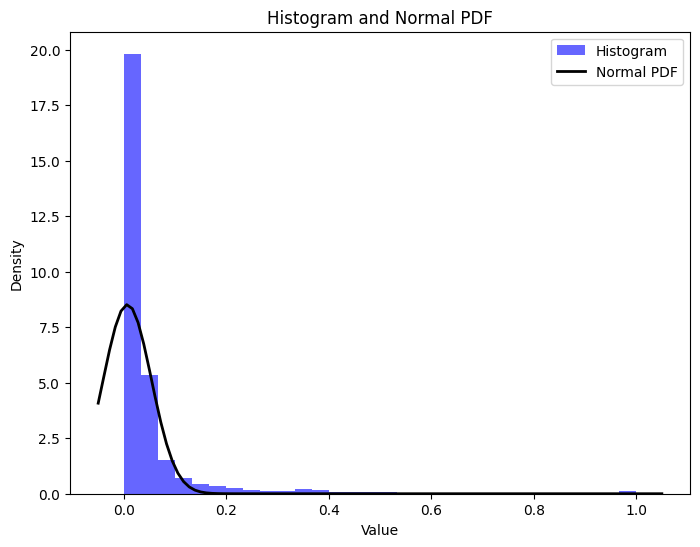

In [ ]:
from scipy import stats
plt.figure(figsize=(8, 6))
plt.hist(comments['influence_usr_log'], bins=30, density=True, alpha=0.6, color='b', label='Histogram')  # Plot
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(comments['influence_usr_log']), np.std(comments['influence_usr_log']))
plt.plot(x, p, 'k', linewidth=2, label='Normal PDF')
plt.title('Histogram and Normal PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

Save the influence for the model.

In [ ]:
comments[['user_posted_str', 'influence_usr_log']].to_csv(path_sim+'user_influences.csv', index=False, delimiter=',')

## Network

We add missing users and edges.

In [ ]:
G = nx.DiGraph()
with open(path_nets + '/full_net/followers.dat', 'r', encoding='utf-8') as f:
	line = f.readline()
	while line:
		G.add_edge(line.split()[0], line.split()[1])
		line = f.readline()

In [ ]:
for id, elem in comments[comments['type_content']== 'source'].iterrows():
  # por cada thread
  total_conv = comments[comments['thread_from'] == elem['thread_from']]
  user_dict =  elem['user'] # info del poster
  for idx, el2 in total_conv.iterrows():
    user_dict_this =  el2['user']
    if user_dict['id_str'] != user_dict_this['id_str'] : # no es él mismo
      if not G.has_node(user_dict_this['id_str']):
        G.add_node(user_dict_this['id_str'])
      if not G.has_node(user_dict['id_str']):
        G.add_node(user_dict['id_str'])
      if not nx.has_path(G, user_dict_this['id_str'], user_dict['id_str']): # si no hay camino (dirigido)
        G.add_edge(user_dict_this['id_str'], user_dict['id_str'])

In [ ]:
print(f"Nodes: {len(G.nodes())}, edges: {len(G.edges())}")

Nodes: 55147, edges: 106016


Save full network for the model.

In [ ]:
nx.write_adjlist(G, path_sim+"full_graph.csv", delimiter=',')

## Entropy

We consider a time-dependent and decreasing lognormal fuction for the entropy.

First we obtain novelty. Then we apply further processing.

In [ ]:
filtered_news = pd.read_json(path_art+"after_filter_pheme.json")

In [ ]:
#texto noticia, título (df) fuente
sources = comments[comments['type_content'] == 'source'][['created_at', 'text', 'thread_from', 'theme']]
sources = pd.merge(sources, sources_stats[['id', 'category']],left_on='thread_from', right_on='id').drop(columns='id')
sources

created_at                                               text  \
0   2015-01-07 11:07:51  France: 10 people dead after shooting at HQ of...   
1   2015-01-07 11:14:38  BREAKING: 10 reportedly shot dead at Paris HQ ...   
2   2015-01-07 11:37:46  BREAKING: At least 10 killed in shooting at Fr...   
3   2015-01-07 11:39:17  Eleven dead in shooting at Paris offices of sa...   
4   2015-01-07 11:43:07  BREAKING Charlie Hebdo latest: 11 dead 10 woun...   
..                  ...                                                ...   
292 2014-12-15 15:33:15  Haron Monis,Hostage-taker in #Sydney: Fled #Ir...   
293 2014-12-15 15:40:07  #BREAKING: Police have confirmed that the #Syd...   
294 2014-12-15 15:44:22  #BREAKING: At least two people have died follo...   
295 2014-12-15 15:51:09  #sydneysiege is over. 2 confirmed dead, #PrayF...   
296 2014-12-15 15:52:04  Police confirm that #sydneysiege is finally ov...   

            thread_from              theme  \
0    552783667052167168  charliehebdo_good   
1    552785375161499649  charliehebdo_good   
2    552791196247269378  charliehebdo_good   
3    552791578893619200  charliehebdo_good   
4    552792544132997121  charliehebdo_good   
..                  ...                ...   
292  544515538383564801        sydneysiege   
293  544517264054423552        sydneysiege   
294  544518335019229184        sydneysiege   
295  544520042810200064        sydneysiege   
296  544520273718812672        sydneysiege   

                                              category  
0    (At least) 10 people are dead at Charlie Hebdo...  
1    (At least) 10 people are dead at Charlie Hebdo...  
2    (At least) 10 people are dead at Charlie Hebdo...  
3       11 people died during the Charlie Hebdo attack  
4       11 people died during the Charlie Hebdo attack  
..                                                 ...  
292  The gunman behind the hostage-taking is named ...  
293            The siege/hostage-taking crisis is over  
294                        At least 2 people have died  
295                        At least 2 people have died  
296            The siege/hostage-taking crisis is over  

[297 rows x 5 columns]

In [ ]:
combined_entr = pd.merge(left=sources, right=filtered_news[['titles', 'full_texts', 'id']], left_on='thread_from', right_on='id', how='left')
combined_entr = combined_entr.drop(columns=['id'])

In [ ]:
values = {"titles": "", "full_texts": ""}
combined_entr = combined_entr.fillna(value=values)
combined_entr = combined_entr.sort_values(by='created_at')
combined_entr

created_at                                               text  \
76  2014-08-10 01:30:14  Mike Brown was staying with his grandmother fo...   
77  2014-08-10 11:28:53  Witness: Police allegedly stopped Mike Brown a...   
78  2014-08-13 01:27:45  Line of police cars with high beams on greets ...   
79  2014-08-13 01:36:45  Currently the #FoxNews website has zero, repea...   
80  2014-08-13 07:23:17  St. Louis Co Police tell me ofcr shot a man wh...   
..                  ...                                                ...   
142 2015-03-26 10:56:55  Names of pilots rumored to be Patrick Sonderhe...   
143 2015-03-26 12:01:19  #4U9525: Robin names Andreas Lubitz as the cop...   
144 2015-03-27 03:14:54  GERMAN NEWS: Co-Pilot of Germanwings Airbus Wa...   
145 2015-03-27 09:23:41  RT @khjelmgaard: German media reporting #Andre...   
146 2015-03-27 15:09:22  GERMAN NEWS REPORT: Co-Pilot of Germanwings Ai...   

            thread_from              theme  \
76   498280126254428160           ferguson   
77   498430783699554305           ferguson   
78   499366666300846081           ferguson   
79   499368931367608320           ferguson   
80   499456140044824576           ferguson   
..                  ...                ...   
142  581047170637381632  germanwings-crash   
143  581063377226637312  germanwings-crash   
144  581293286268129280  germanwings-crash   
145  581386094337474560  germanwings-crash   
146  581473088249958400  germanwings-crash   

                                              category  \
76          Mike Brown was living with his grandmother   
77   M. Brown was stopped by police for walking in ...   
78              Media is barred from entering Ferguson   
79      Fox News is not covering the Ferguson protests   
80           A person has been shot on Chambers street   
..                                                 ...   
142  The pilots were Patrick Sondheimer (captain) a...   
143  The pilots were Patrick Sondheimer (captain) a...   
144                The co-pilot was a convert to Islam   
145  The co-pilot interrupted his training because ...   
146                The co-pilot was a convert to Islam   

                                                titles  \
76                                                       
77                                                       
78                                                       
79                                                       
80                                                       
..                                                 ...   
142                                                      
143                                                      
144                                                      
145  Police make 'significant' discovery at co-pilo...   
146                                                      

                                            full_texts  
76                                                      
77                                                      
78                                                      
79                                                      
80                                                      
..                                                 ...  
142                                                     
143                                                     
144                                                     
145  Police make 'significant' discovery at co-pilo...  
146                                                     

[297 rows x 7 columns]

The first news has a 1 (nothing before).

Theothers operate on the existence of the last 6 hours. Many of the related ones (cat based) fall in the 2-6 hr.

In [ ]:
def preprocess_eng(text_line, stop_words):

    # Extend contractions
    text = contractions.fix(text_line)

    # Tokenize
    text_token = tk.tokenize(text)

    # Remove punctuation or numbers
    tokens = [t.lower() for t in text_token if not all(c in string.punctuation for c in t)]

    # Hashtags, handles and websites
    cleaned_text = [word for word in tokens if not word.startswith('http') and (word not in stop_words)]

    #Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in cleaned_text]

    return lemmatized

In [ ]:
stop_words = set(stopwords.words('english'))
combined_entr['text_proc'] = combined_entr['text'].apply(lambda x: preprocess_eng(x, stop_words))
combined_entr['titles_proc'] = combined_entr['titles'].apply(lambda x: preprocess_eng(x, stop_words))
combined_entr['full_texts_proc'] = combined_entr['full_texts'].apply(lambda x: preprocess_eng(x, stop_words))

We process the tweets, full texts and titles. For the texts

In [ ]:
eps = 1e-40
dfs_end = []
for th in list_themes:
  print("For "+th)
  related=combined_entr[combined_entr['theme'] ==th]
  for idx, el in related.iterrows():# each entropy
    resampled = []
    indices = []
    datetime_start =  el.created_at - timedelta(hours=24)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['text_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=12)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['text_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=8)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['text_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    # 6 h before
    datetime_start =  el.created_at - timedelta(hours=6)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['text_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=4)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['text_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    datetime_start =  el.created_at - timedelta(hours=2)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['text_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    word_freq_now = related[(related['created_at'] == el.created_at)]['text_proc'].explode().value_counts()
    resampled.append(word_freq_now)

    # save results
    result = pd.concat(resampled, axis=1)
    result.columns = [f"freq_for_{i}h_prev" for i in [24,12,8,6,4,2,0]]
    result = result.fillna(0)
    prob_df = result.div(result.sum(axis=0), axis=1)
    prob_df = prob_df.fillna(0) # If there is a time without tweets

    dfs_end.append(prob_df)

For charliehebdo_good
For ebola-essien
For ferguson
For germanwings-crash
For ottawashooting
For prince-toronto
For putinmissing
For sydneysiege


For the titles.

In [ ]:
eps = 1e-40
dfs_end_title = []
for th in list_themes:
  print("For "+th)
  related=combined_entr[combined_entr['theme'] ==th]
  for idx, el in related.iterrows():# each entropy
    resampled = []
    # 6 h before
    datetime_start =  el.created_at - timedelta(hours=24)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['titles_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=12)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['titles_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=8)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['titles_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=6)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['titles_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    datetime_start =  el.created_at - timedelta(hours=4)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['titles_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    datetime_start =  el.created_at - timedelta(hours=2)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['titles_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    word_freq_now = related[(related['created_at'] == el.created_at)]['titles_proc'].explode().value_counts()
    resampled.append(word_freq_now)

    result = pd.concat(resampled, axis=1)
    result.columns = [f"freq_for_{i}h_prev" for i in [24,12,8,6,4,2,0]]
    result = result.fillna(0)
    prob_df = result.div(result.sum(axis=0), axis=1)
    prob_df = prob_df.fillna(0)

    dfs_end_title.append(prob_df)

For charliehebdo_good
For ebola-essien
For ferguson
For germanwings-crash
For ottawashooting
For prince-toronto
For putinmissing
For sydneysiege


For the full text.

In [ ]:
eps = 1e-40
dfs_end_full = []
for th in list_themes:
  print("For "+th)
  related=combined_entr[combined_entr['theme'] ==th]
  for idx, el in related.iterrows():# each entropy
    resampled = []
    datetime_start =  el.created_at - timedelta(hours=24)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['full_texts_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=12)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['full_texts_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=8)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['full_texts_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)
    datetime_start =  el.created_at - timedelta(hours=6)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['full_texts_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    datetime_start =  el.created_at - timedelta(hours=4)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['full_texts_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    datetime_start =  el.created_at - timedelta(hours=2)
    word_freq_tex = related[(related['created_at'] > datetime_start) & (related['created_at'] < el.created_at)]['full_texts_proc'].explode().value_counts() # anteriores
    resampled.append(word_freq_tex)

    word_freq_now = related[(related['created_at'] == el.created_at)]['full_texts_proc'].explode().value_counts()
    resampled.append(word_freq_now)

    result = pd.concat(resampled, axis=1)
    result.columns = [f"freq_for_{i}h_prev" for i in [24,12,8,6,4,2,0]]
    result = result.fillna(0)
    prob_df = result.div(result.sum(axis=0), axis=1)
    prob_df = prob_df.fillna(0)


    dfs_end_full.append(prob_df)

For charliehebdo_good
For ebola-essien
For ferguson
For germanwings-crash
For ottawashooting
For prince-toronto
For putinmissing
For sydneysiege


We alter probs so they add up to 1, since we applied a 1e-40.

In [ ]:
for prob_df in dfs_end_full:
  for col in prob_df.columns[0:6]:
    # those that are zero
    mask = prob_df == 0
    prob_df.replace(to_replace = {col: 0}, value=eps, inplace=True)
    selected_rows = prob_df[~mask]
    zero_rows = mask[col]
    num_non_zero_rows = zero_rows.sum()
    if num_non_zero_rows !=len(prob_df):

      # eps * rows_0 (normalize)
      num_epsilons = eps * num_non_zero_rows
      # Divide
      to_substract = (num_epsilons / (len(prob_df)-num_non_zero_rows))
      selected_rows[col] -= to_substract

    prob_df.update(selected_rows)

In [ ]:
for prob_df in dfs_end:
  for col in prob_df.columns[0:6]:
    mask = prob_df == 0
    prob_df.replace(to_replace = {col: 0}, value=eps, inplace=True)
    selected_rows = prob_df[~mask]
    zero_rows = mask[col]
    num_non_zero_rows = zero_rows.sum()
    if num_non_zero_rows !=len(prob_df):

      num_epsilons = eps * num_non_zero_rows
      to_substract = (num_epsilons / (len(prob_df)-num_non_zero_rows))
      selected_rows[col] -= to_substract

    prob_df.update(selected_rows)

In [ ]:
for prob_df in dfs_end_title:
  for col in prob_df.columns[0:6]:
    mask = prob_df == 0
    prob_df.replace(to_replace = {col: 0}, value=eps, inplace=True)
    selected_rows = prob_df[~mask]
    zero_rows = mask[col]
    num_non_zero_rows = zero_rows.sum()
    if num_non_zero_rows !=len(prob_df):

      num_epsilons = eps * num_non_zero_rows
      to_substract = (num_epsilons / (len(prob_df)-num_non_zero_rows))
      selected_rows[col] -= to_substract

    prob_df.update(selected_rows)

Compute entropy now. pk current, qk last.

In [ ]:
en_24h_full = []
en_12h_full = []
en_8h_full = []
en_6h_full = []
en_4h_full = []
en_2h_full = []

for elem in dfs_end_full:
  # obtain the entropies
  prob_24h = elem['freq_for_24h_prev'].to_numpy()
  prob_12h = elem['freq_for_12h_prev'].to_numpy()
  prob_8h = elem['freq_for_8h_prev'].to_numpy()
  prob_6h = elem['freq_for_6h_prev'].to_numpy()
  prob_4h = elem['freq_for_4h_prev'].to_numpy()
  prob_2h = elem['freq_for_2h_prev'].to_numpy()
  prob_0h = elem['freq_for_0h_prev'].to_numpy()

  en_24h = entropy(pk = prob_0h, qk = prob_24h)
  en_24h_full.append(en_24h)
  en_12h = entropy(pk = prob_0h, qk = prob_12h)
  en_12h_full.append(en_12h)

  en_8h = entropy(pk = prob_0h, qk = prob_8h)
  en_8h_full.append(en_8h)

  en_6h = entropy(pk = prob_0h, qk = prob_6h)
  en_6h_full.append(en_6h)

  en_4h = entropy(pk = prob_0h, qk = prob_4h)
  en_4h_full.append(en_4h)

  en_2h = entropy(pk = prob_0h, qk = prob_2h)
  en_2h_full.append(en_2h)


In [ ]:
entropy_full = pd.DataFrame(data={'entropy_24h_full': en_24h_full, 'entropy_12h_full': en_12h_full, 'entropy_8h_full': en_8h_full,
                                  'entropy_6h_full': en_6h_full, 'entropy_4h_full': en_4h_full, 'entropy_2h_full': en_2h_full,})

In [ ]:
en_24h_full = []
en_12h_full = []
en_8h_full = []
en_6h_full = []
en_4h_full = []
en_2h_full = []


for elem in dfs_end:
  prob_24h = elem['freq_for_24h_prev'].to_numpy()
  prob_12h = elem['freq_for_12h_prev'].to_numpy()
  prob_8h = elem['freq_for_8h_prev'].to_numpy()
  prob_6h = elem['freq_for_6h_prev'].to_numpy()
  prob_4h = elem['freq_for_4h_prev'].to_numpy()
  prob_2h = elem['freq_for_2h_prev'].to_numpy()
  prob_0h = elem['freq_for_0h_prev'].to_numpy()

  en_24h = entropy(pk = prob_0h, qk = prob_24h)
  en_24h_full.append(en_24h)
  en_12h = entropy(pk = prob_0h, qk = prob_12h)
  en_12h_full.append(en_12h)

  en_8h = entropy(pk = prob_0h, qk = prob_8h)
  en_8h_full.append(en_8h)

  en_6h = entropy(pk = prob_0h, qk = prob_6h)
  en_6h_full.append(en_6h)

  en_4h = entropy(pk = prob_0h, qk = prob_4h)
  en_4h_full.append(en_4h)

  en_2h = entropy(pk = prob_0h, qk = prob_2h)
  en_2h_full.append(en_2h)


In [ ]:
entropy_tw = pd.DataFrame(data={'entropy_24h_tweet': en_24h_full, 'entropy_12h_tweet': en_12h_full, 'entropy_8h_tweet': en_8h_full,
                                'entropy_6h_tweet': en_6h_full, 'entropy_4h_tweet': en_4h_full, 'entropy_2h_tweet': en_2h_full})

In [ ]:
en_24h_full = []
en_12h_full = []
en_8h_full = []
en_6h_full = []
en_4h_full = []
en_2h_full = []


for elem in dfs_end_title:
  prob_24h = elem['freq_for_24h_prev'].to_numpy()
  prob_12h = elem['freq_for_12h_prev'].to_numpy()
  prob_8h = elem['freq_for_8h_prev'].to_numpy()
  prob_6h = elem['freq_for_6h_prev'].to_numpy()
  prob_4h = elem['freq_for_4h_prev'].to_numpy()
  prob_2h = elem['freq_for_2h_prev'].to_numpy()
  prob_0h = elem['freq_for_0h_prev'].to_numpy()

  en_24h = entropy(pk = prob_0h, qk = prob_24h)
  en_24h_full.append(en_24h)
  en_12h = entropy(pk = prob_0h, qk = prob_12h)
  en_12h_full.append(en_12h)

  en_8h = entropy(pk = prob_0h, qk = prob_8h)
  en_8h_full.append(en_8h)

  en_6h = entropy(pk = prob_0h, qk = prob_6h)
  en_6h_full.append(en_6h)

  en_4h = entropy(pk = prob_0h, qk = prob_4h)
  en_4h_full.append(en_4h)

  en_2h = entropy(pk = prob_0h, qk = prob_2h)
  en_2h_full.append(en_2h)

In [ ]:
entropy_title = pd.DataFrame(data={'entropy_24h_title': en_24h_full, 'entropy_12h_title': en_12h_full, 'entropy_8h_title': en_8h_full,
                                   'entropy_6h_title': en_6h_full, 'entropy_4h_title': en_4h_full, 'entropy_2h_title': en_2h_full})

In [ ]:
print(entropy_title['entropy_24h_title'].median())
print(entropy_title['entropy_12h_title'].median())
print(entropy_title['entropy_8h_title'].median())
print(entropy_title['entropy_6h_title'].median())
print(entropy_title['entropy_4h_title'].median())
print(entropy_title['entropy_2h_title'].median())

23.25259733232822
22.115222883343545
23.929202198768092
26.017397666097605
29.102450978289163
36.685004109252816


In [ ]:
print(entropy_tw['entropy_24h_tweet'].median())
print(entropy_tw['entropy_12h_tweet'].median())
print(entropy_tw['entropy_8h_tweet'].median())
print(entropy_tw['entropy_6h_tweet'].median())
print(entropy_tw['entropy_4h_tweet'].median())
print(entropy_tw['entropy_2h_tweet'].median())

42.796757910996135
45.50425198209203
45.50425198209203
45.430423150613485
45.50239571554687
50.87405834015612


In [ ]:
print(entropy_full['entropy_24h_full'].median())
print(entropy_full['entropy_12h_full'].median())
print(entropy_full['entropy_8h_full'].median())
print(entropy_full['entropy_6h_full'].median())
print(entropy_full['entropy_4h_full'].median())
print(entropy_full['entropy_2h_full'].median())

9.995032700205876
9.604252280501676
9.99469102626401
12.901503639025936
17.08913329611127
19.015703732421628


We add all of them and compute.

In [ ]:
combo = combined_entr.reset_index(drop=True)

In [ ]:
combined_entropy = pd.concat([combo, entropy_title, entropy_full, entropy_tw], axis=1)

In [ ]:
cols = ['entropy_6h_title', 'entropy_4h_title', 'entropy_2h_title',
       'entropy_6h_full', 'entropy_4h_full', 'entropy_2h_full',
       'entropy_6h_tweet', 'entropy_4h_tweet', 'entropy_2h_tweet',
        'entropy_12h_title', 'entropy_8h_title', 'entropy_24h_title',
       'entropy_12h_full', 'entropy_8h_full', 'entropy_24h_full',
       'entropy_12h_tweet', 'entropy_8h_tweet', 'entropy_24h_tweet']

In [ ]:
def calculate_alpha(val):
    alpha = -np.log(0.5) / val
    return alpha

def log_scaling(entropy_values, alpha):
    scaled_values = 1 - np.exp(-alpha * entropy_values)
    return scaled_values

for col in cols:
  print(combined_entropy[col].median())
  alpha = calculate_alpha(int(combined_entropy[col].median()))
  combined_entropy[col] = combined_entropy[col].fillna(0)
  combined_entropy[col + '_logs'] = combined_entropy[col].apply(lambda x: log_scaling(x, alpha))

26.017397666097605
29.102450978289163
36.685004109252816
12.901503639025936
17.08913329611127
19.015703732421628
45.430423150613485
45.50239571554687
50.87405834015612
22.115222883343545
23.929202198768092
23.25259733232822
9.604252280501676
9.99469102626401
9.995032700205876
45.50425198209203
45.50425198209203
42.796757910996135


We define the decreasing factors.

In [ ]:
m_val = related.created_at.min()
m_val2 = related.created_at.max()

In [ ]:
_, remainder = divmod((m_val2 - m_val).seconds, 3600)
minutes, _ = divmod(remainder, 60)
minutes

39

In [ ]:
def fun(end, theme, value, hour_val):
  related = combined_entropy[combined_entropy['theme'] == theme]
  start = related[(related['created_at'] > end - timedelta(hours=hour_val)) & (related['created_at'] < end)]['created_at'].max() # when the last of the previous was sent
  if len(related[(related['created_at'] > end - timedelta(hours=hour_val)) & (related['created_at'] < end)]) == 0: # no hay max
    return -1 # novelty is assumed to be 1
  # si start es NaT significa que el contenido es totalmente novedoso (según nuestro conocimiento)

  # aplicamos función según diferencia entre start y end
  t_del = end - start
  # tiempo en mins
  _, remainder = divmod(t_del.seconds, 3600)
  minutes, _ = divmod(remainder, 60)

  a = 1
  b = 60
  if t_del <= timedelta(minutes=60):
    c = 20
  else:
    c = 110
  val = a * math.exp((-(minutes-b)**2) / 2*c)
  return (1-val) * value

We apply the function.

In [ ]:
#combined_entropy["entropy_8h_full_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_8h_full_logs, 8), axis=1)
combined_entropy["entropy_8h_title_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_8h_title_logs, 8), axis=1)
combined_entropy["entropy_8h_tweet_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_8h_tweet_logs, 8), axis=1)

In [ ]:
combined_entropy["entropy_12h_full_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_12h_full_logs, 12), axis=1)
combined_entropy["entropy_12h_title_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_12h_title_logs, 12), axis=1)
combined_entropy["entropy_12h_tweet_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_12h_tweet_logs, 12), axis=1)

In [ ]:
combined_entropy["entropy_24h_full_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_24h_full_logs, 24), axis=1)
combined_entropy["entropy_24h_title_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_24h_title_logs, 24), axis=1)
combined_entropy["entropy_24h_tweet_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_24h_tweet_logs, 24), axis=1)

In [ ]:
combined_entropy["entropy_6h_full_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_6h_full_logs, 6), axis=1)
combined_entropy["entropy_6h_title_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_6h_title_logs, 6), axis=1)
combined_entropy["entropy_6h_tweet_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_6h_tweet_logs, 6), axis=1)

In [ ]:
combined_entropy["entropy_4h_full_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_4h_full_logs, 4), axis=1)
combined_entropy["entropy_4h_title_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_4h_title_logs, 4), axis=1)
combined_entropy["entropy_4h_tweet_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_4h_tweet_logs, 4), axis=1)

In [ ]:
combined_entropy["entropy_2h_full_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_2h_full_logs, 2), axis=1)
combined_entropy["entropy_2h_title_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_2h_title_logs, 2), axis=1)
combined_entropy["entropy_2h_tweet_novel"] = combined_entropy.apply(lambda x: fun(x.created_at, x.theme, x.entropy_2h_tweet_logs, 2), axis=1)

We apply the weights.

In [ ]:
def novelty(row):
  tweet_v = row.entropy_6h_tweet_novel
  full_v = row.entropy_6h_full_novel
  title_v = row.entropy_6h_title_novel
  if row.full_texts != "" and row.titles != "":
    # todo
    return 0.5 * (tweet_v if tweet_v != -1 else 1) + 0.25 * (full_v if full_v != -1 else 1) + 0.25 * (title_v if title_v != -1 else 1)

  else:
    return tweet_v if tweet_v != -1 else 1


combined_entropy['novelty'] = combined_entropy.apply(lambda x: novelty(x), axis=1)
combined_entropy['novelty']

0      1.000000
1      1.000000
2      1.000000
3      0.440075
4      0.572825
         ...   
292    1.000000
293    0.438465
294    1.000000
295    1.000000
296    0.406900
Name: novelty, Length: 297, dtype: float64

In [ ]:
subsel1 = combined_entropy[combined_entropy['titles'] != ""]
subsel2 = combined_entropy[combined_entropy['titles'] == ""]
subsel3 = combined_entropy

In [ ]:
subsel2[['novelty', 'entropy_6h_tweet_novel']]

novelty  entropy_6h_tweet_novel
0    1.000000               -1.000000
1    1.000000               -1.000000
2    1.000000               -1.000000
3    0.440075                0.440075
4    0.572825                0.572825
..        ...                     ...
291  1.000000               -1.000000
292  1.000000               -1.000000
293  0.438465                0.438465
294  1.000000               -1.000000
296  0.406900                0.406900

[175 rows x 2 columns]

We store it.

In [ ]:
combined_entropy.to_json(path_sav+"/news_novel.json")

And create an output for the simulator input.

In [ ]:
test_pred_set = pd.read_json(path_sav+'test_pred_set.json')

In [ ]:
combined_news_scs = pd.merge(test_pred_set, combined_entropy, left_on='id', right_on='thread_from', how='inner')

In [ ]:
def analys(x):
  return only_scs[only_scs['thread_from'] == x]['user'].iloc[0]['id_str']

In [ ]:
combined_news_scs['id_str'] = combined_news_scs['thread_from'].apply(lambda x: analys(x))

In [ ]:
combined_news_scs[['thread_from', 'thread_from', 'tick', 'novelty']].to_csv(path_sav+"news_content.csv", index=False)

## News Influence

We load the predictions.

In [ ]:
path_res = 'output_model' # where output of the models is

In [ ]:
df_predicts = pd.read_json(path_res+"combined_3_full.json")
test_pred_set = pd.read_json(path_test+"test_pred_set.json")

In [ ]:
df_predicts['result_pred'] = df_predicts['result_pred'].apply(lambda x: [round(y) for y in x])

The one selected. (idx based on our results, might vary).

In [ ]:
df_predicts.iloc[13]['current'] ## selected

"RF para [['titles', 'text']], procesado como Count, con TODO, CON CHARS TB"

We process.

In [ ]:
# por encima de thresh, sería superior a 0.5 log
thresh = 142

def calculate_alpha(val):
    alpha = -np.log(0.5) / val
    return alpha


def log_scaling(entropy_values, alpha):
    scaled_values = 1 - np.exp(-alpha * entropy_values)
    return scaled_values

alpha = calculate_alpha(thresh)

In [ ]:
test_pred_set

is_rumour           theme                  id  is_turnaround  \
0     rumour  ottawashooting  524922729485848576              0   
1     rumour  ottawashooting  524923462398513152              0   
2     rumour  ottawashooting  524923676484177920              0   
3     rumour  ottawashooting  524924619812511746              0   
4     rumour  ottawashooting  524925050739490816              0   
5     rumour  ottawashooting  524925215235911680              0   
6     rumour  ottawashooting  524925730053181440              0   
7     rumour  ottawashooting  524925987239120897              0   
8     rumour  ottawashooting  524926235030589440              0   
9     rumour  ottawashooting  524926472432410625              0   
10    rumour  ottawashooting  524927281048080385              0   
11    rumour  ottawashooting  524929497205055488              0   
12    rumour  ottawashooting  524931324763992064              0   
13    rumour  ottawashooting  524932056560963584              0   
14    rumour  ottawashooting  524932935137628160              0   
15    rumour  ottawashooting  524935485370929152              0   
16    rumour  ottawashooting  524936872666353664              0   
17    rumour  ottawashooting  524937542131793920              0   
18    rumour  ottawashooting  524940659778920448              0   
19    rumour  ottawashooting  524941132237910016              1   
20    rumour  ottawashooting  524942470472548352              0   
21    rumour  ottawashooting  524943490887991296              0   
22    rumour  ottawashooting  524944399890124801              0   
23    rumour  ottawashooting  524947416869388288              0   
24    rumour  ottawashooting  524947674164760577              0   
25    rumour  ottawashooting  524947867975561216              0   
26    rumour  ottawashooting  524948866773184512              0   
27    rumour  ottawashooting  524949443607412737              0   
28    rumour  ottawashooting  524952883343925249              0   
29    rumour  ottawashooting  524956129017995264              0   
30    rumour  ottawashooting  524959809402331137              0   
31    rumour  ottawashooting  524962142563610625              0   
32    rumour  ottawashooting  524964948683005952              0   
33    rumour  ottawashooting  524965775036387329              0   
34    rumour  ottawashooting  524966904885428226              0   
35    rumour  ottawashooting  524969201102901248              1   
36    rumour  ottawashooting  524970851675176960              0   
37    rumour  ottawashooting  524972443308683264              0   
38    rumour  ottawashooting  524975705206304769              0   
39    rumour  ottawashooting  524980744658382848              0   
40    rumour  ottawashooting  524981436252950528              0   
41    rumour  ottawashooting  524983581983375360              1   
42    rumour  ottawashooting  524990163446140928              0   
43    rumour  ottawashooting  524991576163250176              0   
44    rumour  ottawashooting  524993533212897281              0   
45    rumour  ottawashooting  524995771587108864              0   
46    rumour  ottawashooting  525003468659228672              0   
47    rumour  ottawashooting  525019752507658240              0   
48    rumour  ottawashooting  525023025792835585              0   
49    rumour  ottawashooting  525025279803424768              0   
50    rumour  ottawashooting  525025463648137216              0   
51    rumour  ottawashooting  525028734991343617              1   
52    rumour  ottawashooting  525032872647065600              0   
53    rumour  ottawashooting  525049639016615937              0   
54    rumour  ottawashooting  525056576038518785              0   
55    rumour  ottawashooting  525058976376193024              0   
56    rumour  ottawashooting  525060425184858112              0   
57    rumour  ottawashooting  525068915068923904              0   

    misinformation  true                         

In [ ]:
pred = df_predicts.iloc[13]['result_pred']
unique_idxs = df_predicts.iloc[13]['unique_idx']
d_pr = {}
for i, _ in enumerate(pred):
  d_pr[unique_idxs[i]] = pred[i]

In [ ]:
test_pred_set['preds'] = test_pred_set['unique_idx'].apply(lambda x: d_pr[x])

In [ ]:
df_predicts.sort_values(by='result_mae')

result_mae  result_rmse  \
10  163.701206   263.553785   
47  165.281572   276.621230   
50  165.635372   276.310763   
48  165.881766   275.460440   
39  166.635587   272.726106   
11  167.717236   264.832987   
13  168.051478   272.759397   
15  168.421425   266.886673   
32  168.739448   270.950897   
30  168.782147   271.188213   
31  168.786552   271.099591   
28  168.805289   270.616132   
27  168.917864   271.822150   
20  168.943274   271.560417   
19  168.959843   272.149467   
7   168.973692   270.451734   
33  169.031003   272.189029   
22  169.067935   273.064911   
17  169.132209   269.827468   
24  169.148102   272.286844   
23  169.388051   273.377687   
25  169.592573   274.063145   
29  169.796749   270.163408   
2   169.922215   271.729121   
38  170.032147   261.657708   
5   170.169933   275.358254   
16  170.344595   273.786765   
26  170.408736   271.003287   
4   171.062436   259.824483   
14  171.272055   274.292053   
40  171.541189   275.701034   
1   172.139604   257.236558   
35  172.410609   264.581208   
42  173.759873   278.136663   
8   174.293857   278.271451   
3   174.982170   277.203725   
6   175.851074   279.289978   
21  189.188853   257.227971   
49  191.612511   340.640844   
44  192.087146   342.866801   
12  193.909582   289.712004   
36  194.568665   354.162832   
9   194.693274   288.224902   
41  195.967805   366.555289   
45  199.330656   339.213974   
0   200.832145   294.892660   
18  205.743669   263.281930   
43  207.836200   312.996100   
34  208.035864   309.024461   
37  208.750663   375.101509   
46  210.872656   311.886240   

                                              current  \
10  RF para [['titles', 'text']], procesado como T...   
47  Gradient para [['titles', 'text']], procesado ...   
50  Gradient para [['titles', 'text', 'full_texts'...   
48  Gradient para [['text', 'full_texts']], proces...   
39  Gradient para [['titles', 'text']], procesado ...   
11  RF para [['text', 'full_texts']], procesado co...   
13  RF para [['titles', 'text']], procesado como C...   
15  RF para [['titles', 'text', 'full_texts']], pr...   
32  Ada para [['titles', 'text', 'full_texts']], p...   
30  Ada para [['titles', 'text']], procesado como ...   
31  Ada para [['text', 'full_texts']], procesado c...   
28  Ada para [['text', 'full_texts']], procesado c...   
27  Ada para [['titles', 'text']], procesado como ...   
20  Ada para [['text', 'full_texts']], procesado c...   
19  Ada para [['titles', 'text']], procesado como ...   
7   RF para [['titles', 'text', 'full_texts']], pr...   
33  Ada para [['titles', 'text', 'full_texts']], p...   
22  Ada para [['titles', 'text']], procesado como ...   
17                           Ada con char solo, TODAS   
24  Ada para [['titles', 'text', 'full_texts']], p...   
23  Ada para [['text', 'full_texts']], procesado c...   
25  Ada para [['titles', 'text', 'full_texts']], p...   
29  Ada para [['titles', 'full_texts']], procesado...   
2   RF para [['titles', 'text']], procesado como T...   
38  Gradient para [['titles', 'full_texts']], proc...   
5   RF para [['titles', 'text']], procesado como C...   
16  RF para [['titles', 'text', 'full_texts']], pr...   
26  Ada para [['titles', 'full_texts']], procesado...   
4   RF para [['titles', 'full_texts']], procesado ...   
14  RF para [['text', 'full_texts']], procesado co...   
40  Gradient para [['text', 'full_texts']], proces...   
1   RF para [['titles', 'full_texts']], procesado ...   
35  Gradient para [['titles', 'full_texts']], proc...   
42  Gradient para [['titles', 'text', 'full_texts'...   
8   RF para [['titles', 'text', 'full_texts']], pr...   
3   RF para [['text', 'full_texts']], procesado co...   
6   RF para [['text', 'full_texts']], procesado co...   
21  Ada para [['titles', 'full_texts']], procesado...   
49  Gradient para [['titles', 'text', 'full_texts'...   
44  Gradient para [['titles', 'text']], procesado ...   
12  RF para [['titles', 'full_texts']], procesado ... 

We assign the values and also check what *should be*, based on the correct preds.

In [ ]:
test2 = test_pred_set.copy()
thresh=142
test2['prediction_prob'] = test2['preds'].apply(lambda x: log_scaling(x, calculate_alpha(thresh)))

test2['should_be_prob'] = test2['combined_preds'].apply(lambda x: log_scaling(x, calculate_alpha(thresh)))
test2['difference'] = test2.apply(lambda x: x['prediction_prob'] - x['should_be_prob'], axis=1)
test2[['id','preds', 'prediction_prob', 'combined_preds', 'should_be_prob', 'difference']]

id       preds  prediction_prob  combined_preds  \
0   524922729485848576  192.382902         0.609013              59   
1   524923462398513152  182.447534         0.589584             108   
2   524923676484177920  118.905912         0.440335             209   
3   524924619812511746  108.634925         0.411561              15   
4   524925050739490816  122.428865         0.449877             198   
5   524925215235911680  198.059806         0.619699             407   
6   524925730053181440  275.230827         0.739066             459   
7   524925987239120897  131.905519         0.474746             109   
8   524926235030589440  140.818822         0.497109              79   
9   524926472432410625  185.970083         0.596581              83   
10  524927281048080385  132.258938         0.475651             707   
11  524929497205055488  148.273156         0.515079             202   
12  524931324763992064  140.605459         0.496585             137   
13  524932056560963584  185.513974         0.595682              11   
14  524932935137628160  248.198825         0.702261             202   
15  524935485370929152  153.265994         0.526754             102   
16  524936872666353664  120.461861         0.444570             780   
17  524937542131793920  265.555618         0.726447             196   
18  524940659778920448  174.094558         0.572504             153   
19  524941132237910016  184.010615         0.592704              66   
20  524942470472548352  163.629337         0.550099              13   
21  524943490887991296  229.311610         0.673506             509   
22  524944399890124801  172.016407         0.568146             684   
23  524947416869388288  320.121411         0.790413             222   
24  524947674164760577  125.367040         0.457711             135   
25  524947867975561216  144.307195         0.505599             960   
26  524948866773184512  244.919628         0.697457             171   
27  524949443607412737  132.328058         0.475828             229   
28  524952883343925249  182.963630         0.590617             981   
29  524956129017995264  133.472569         0.478748             645   
30  524959809402331137  159.869767         0.541766             387   
31  524962142563610625  132.102933         0.475252             177   
32  524964948683005952  162.179004         0.546902             721   
33  524965775036387329  156.781832         0.534807             160   
34  524966904885428226  154.169419         0.528836             131   
35  524969201102901248  157.926948         0.537400             307   
36  524970851675176960  236.699630         0.685070             161   
37  524972443308683264  124.100714         0.454349             152   
38  524975705206304769  268.602724         0.730486             382   
39  524980744658382848  145.198866         0.507747             222   
40  524981436252950528  173.920947         0.572142             175   
41  524983581983375360  135.277402         0.483320             457   
42  524990163446140928  275.983814         0.740024             267   
43  524991576163250176  156.948661         0.535185             108   
44  524993533212897281  140.670954         0.496746             214   
45  524995771587108864  149.417477         0.517780             106   
46  525003468659228672  285.223735         0.751489             385   
47  525019752507658240  191.924483         0.608138             505   
48  525023025792835585  132.079354         0.475191             117   
49  525025279803424768  129.826154         0.469387             115   
50  525025463648137216  125.242183         0.457381             146   
51  525028734991343617  238.155798         0.687301             119   
52  525032872647065600  160.047496         0.542163             126   
53  525049639016615937  282.238979         0.747842             182   
54  525056576038518785  200.432202         0.624078            1052   
55  525058976376193024  286.030769         0

We save for the simulator.

In [ ]:
combined_news_scs = pd.read_json(path_sav+"news_content.json")

In [ ]:
combined_news_scs['prediction_probab'] = test2['prediction_prob']

In [ ]:
combined_news_scs.to_csv(path_sav+"combined_news_all.csv")

In [ ]:
combined_news_scs[['thread_from', 'thread_from.1', 'tick', "novelty", 'prediction_probab']].to_csv(path_sav+"combined_news_last.csv", index=False)

In [ ]:
combined_news_scs[['thread_from', 'thread_from.1', 'tick', "novelty", 'prediction_probab', 'id_str']]

thread_from       thread_from.1  tick   novelty  prediction_probab  \
0   524922729485848576  524922729485848576     0  1.000000           0.609013   
1   524923462398513152  524923462398513152     0  0.350950           0.589584   
2   524923676484177920  524923676484177920     0  0.270985           0.440335   
3   524924619812511746  524924619812511746     0  0.285887           0.411561   
4   524925050739490816  524925050739490816     0  0.257769           0.449877   
5   524925215235911680  524925215235911680     0  0.301523           0.619699   
6   524925730053181440  524925730053181440     0  0.588204           0.739066   
7   524925987239120897  524925987239120897     0  0.530796           0.474746   
8   524926235030589440  524926235030589440     0  0.503904           0.497109   
9   524926472432410625  524926472432410625     0  0.230241           0.596581   
10  524927281048080385  524927281048080385     0  0.327057           0.475651   
11  524929497205055488  524929497205055488     0  0.135668           0.515079   
12  524931324763992064  524931324763992064     0  0.545213           0.496585   
13  524932056560963584  524932056560963584     0  0.285204           0.595682   
14  524932935137628160  524932935137628160     0  0.380094           0.702261   
15  524935485370929152  524935485370929152     0  0.256244           0.526754   
16  524936872666353664  524936872666353664     0  0.505855           0.444570   
17  524937542131793920  524937542131793920     0  0.440118           0.726447   
18  524940659778920448  524940659778920448     0  0.143210           0.572504   
19  524941132237910016  524941132237910016     0  0.468219           0.592704   
20  524942470472548352  524942470472548352     0  0.344657           0.550099   
21  524943490887991296  524943490887991296     0  0.040664           0.673506   
22  524944399890124801  524944399890124801     0  0.040039           0.568146   
23  524947416869388288  524947416869388288     0  0.436659           0.790413   
24  524947674164760577  524947674164760577     0  0.037323           0.457711   
25  524947867975561216  524947867975561216     0  0.486871           0.505599   
26  524948866773184512  524948866773184512     0  0.000000           0.697457   
27  524949443607412737  524949443607412737     0  0.614621           0.475828   
28  524952883343925249  524952883343925249     0  0.000000           0.590617   
29  524956129017995264  524956129017995264     0  0.006226           0.478748   
30  524959809402331137  524959809402331137     0  0.000000           0.541766   
31  524962142563610625  524962142563610625     0  0.722256           0.475252   
32  524964948683005952  524964948683005952     0  0.700507           0.546902   
33  524965775036387329  524965775036387329     0  0.677476           0.534807   
34  524966904885428226  524966904885428226     0  0.344545           0.528836   
35  524969201102901248  524969201102901248     0  0.004101           0.537400   
36  524970851675176960  524970851675176960     0  0.730640           0.685070   
37  524972443308683264  524972443308683264     0  0.463054           0.454349   
38  524975705206304769  524975705206304769     0  0.563192           0.730486   
39  524980744658382848  524980744658382848     0  0.232117           0.507747   
40  524981436252950528  524981436252950528     0  0.538943           0.572142   
41  524983581983375360  524983581983375360     0  0.200423           0.483320   
42  524990163446140928  524990163446140928     0  0.684203           0.740024   
43  524991576163250176  524991576163250176     0  0.293577           0.535185   
44  524993533212897281  524993533212897281     0  0.507417           0.496746   
45  524995771587108864  524995771587108864     0  0.503304           0.517780   
46  525003468659228672  525003468659228672     0  0.588377           0.751489   
47  525019752507658240  525019752507658240     0  0.628064           0.608138   
48  525023025792835585  525023025792835585

Each news has a file (for simultaneous diff).

In [ ]:
for elem in combined_news_scs.thread_from.unique():
  sel = combined_news_scs[combined_news_scs['thread_from'] == elem]
  sel[['thread_from', 'id_str', 'tick', "novelty", 'prediction_probab']].to_csv(path_sav+f"/news_sim_edited/news_content_{elem}.csv", index=False)

## Engagement Over Time

We load the predictions.

In [ ]:
timeline = pd.read_json(path_res+"timeline_full2.json")

In [ ]:
def roundTimel(x):
  total = []
  for el in x:
    this = []
    for e in el:
      this.append(round(e))
    total.append(this)
  return total
timeline['result_pred_round'] = timeline['result_pred'].apply(lambda x: roundTimel(x))

In [ ]:
timeline['result_mae_custom'] = timeline.apply(lambda x: mean_absolute_error_edit(x['test_pred'], x['result_pred_round']), axis=1)

The one selected. (idx based on our results, might vary).

In [ ]:
timeline.iloc[36]['current'] # selected

"KN para [['titles', 'text']], procesado como TFIDF, con TODO (1000 scoring)"

In [ ]:
timeline.columns

We process.

In [ ]:
timeline

result_mae  result_custom  result_rmse  \
0     0.230049       0.000000     0.418531   
1     0.237664       0.000000     0.400955   
2     0.252151       0.000000     0.461271   
3     0.258304       0.000000     0.464827   
4     0.243339       0.000000     0.406447   
..         ...            ...          ...   
63    0.227679       0.164016     0.416414   
64    0.242283       0.159559     0.425784   
65    0.242835       0.160762     0.426209   
66    0.235090       0.172398     0.420984   
67    0.237665       0.160470     0.423102   

                                              current  \
0                             DT con char solo, TODAS   
1   DT para [['titles', 'full_texts']], procesado ...   
2   DT para [['titles', 'text']], procesado como T...   
3   DT para [['text', 'full_texts']], procesado co...   
4   DT para [['titles', 'full_texts']], procesado ...   
..                                                ...   
63  DT para [['titles', 'full_texts']], procesado ...   
64  DT para [['titles', 'text']], procesado como C...   
65  DT para [['text', 'full_texts']], procesado co...   
66  DT para [['titles', 'text', 'full_texts']], pr...   
67  DT para [['titles', 'text', 'full_texts']], pr...   

                                          result_pred  \
0   [[1.2027027027, 35.972972973, 12.527027027, 7....   
1   [[2.0, 60.0, 42.0, 19.0, 16.0, 13.0, 12.0, 10....   
2   [[1.2010309278, 58.4175257732, 20.1701030928, ...   
3   [[1.2, 58.241025641, 20.5333333333, 11.7794871...   
4   [[1.0, 153.0, 63.0, 46.0, 23.0, 15.0, 16.0, 49...   
..                                                ...   
63  [[1.2027027027, 35.972972973, 12.527027027, 7....   
64  [[1.2357142857, 45.2, 15.7928571429, 9.7357142...   
65  [[1.2357142857, 45.2, 15.7928571429, 9.7357142...   
66  [[1.1923076923, 39.2435897436, 13.3076923077, ...   
67  [[1.2357142857, 45.2, 15.7928571429, 9.7357142...   

                                          testing_idx  \
0   [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
1   [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
2   [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
3   [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
4   [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
..                                                ...   
63  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
64  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
65  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
66  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   
67  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...   

                                    result_pred_round  \
0   [[1, 36, 13, 8, 6, 4, 3, 2, 2, 2, 2, 1, 1, 1, ...   
1   [[2, 60, 42, 19, 16, 13, 12, 10, 0, 6, 2, 3, 4...   
2   [[1, 58, 20, 11, 7, 5, 4, 4, 3, 3, 2, 2, 2, 1,...   
3   [[1, 58, 21, 12, 8, 6, 5, 4, 4, 3, 3, 2, 2, 2,...   
4   [[1, 153, 63, 46, 23, 15, 16, 49, 23, 8, 7, 3,...   
..                                                ...   
63  [[1, 36, 13, 8, 6, 4, 3, 2, 2, 2, 2, 1, 1, 1, ...   
64  [[1, 45, 16, 10, 6, 5, 4, 3, 3, 2, 2, 1, 1, 1,...   
65  [[1, 45, 16, 10, 6, 5, 4, 3, 3, 2, 2, 1, 1, 1,...   
66  [[1, 39, 13, 8, 6, 4, 4, 3, 3, 3, 2, 2, 2, 2, ...   
67  [[1, 45, 16, 10, 6, 5, 4, 3, 3, 2, 2, 1, 1, 1,...   

                                            test_pred  
0   [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
1   [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
2   [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
3   [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
4   [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
..                                                ...  
63  [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
64  [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
65  [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
66  [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  
67  [[1, 98, 26, 36, 12, 5, 2, 2, 3, 2, 0, 2, 2, 2...  

[68 rows x 8 columns]

In [ ]:
len(timeline['result_pred_round'].iloc[36])

58

We visualize the timelines.

For ottawashooting_524925050739490816, with 198 total msgs


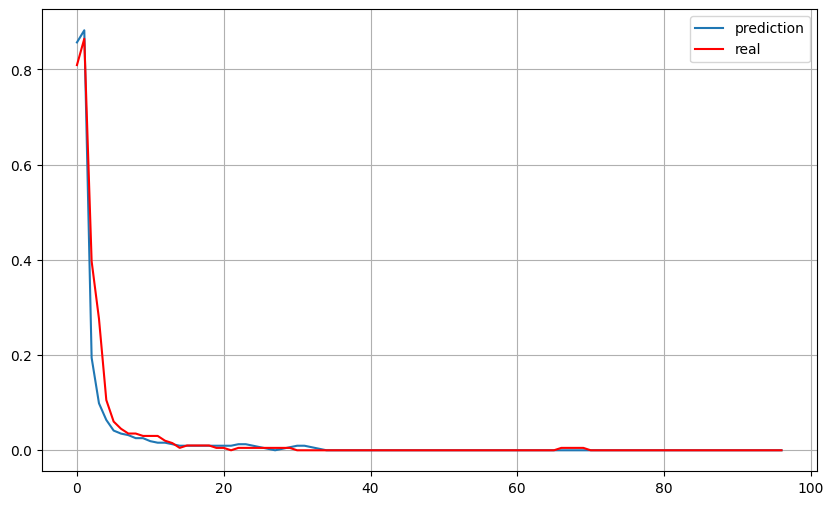

For ottawashooting_524925215235911680, with 407 total msgs


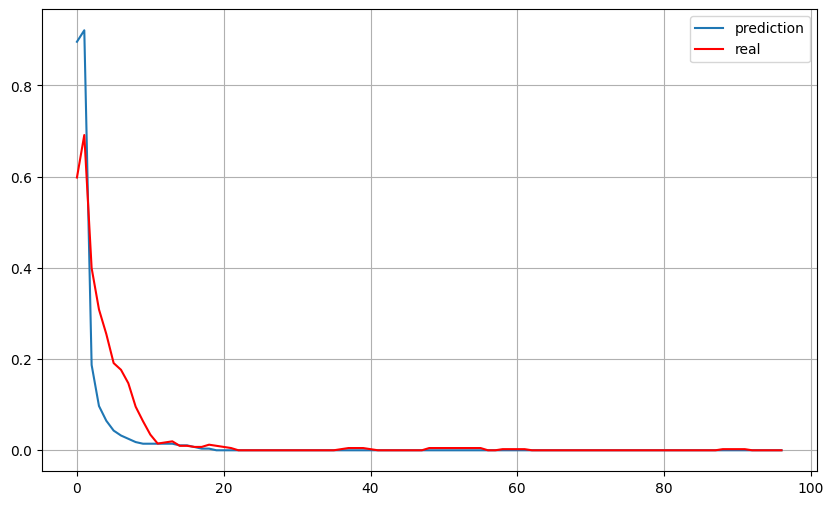

For ottawashooting_524925987239120897, with 109 total msgs


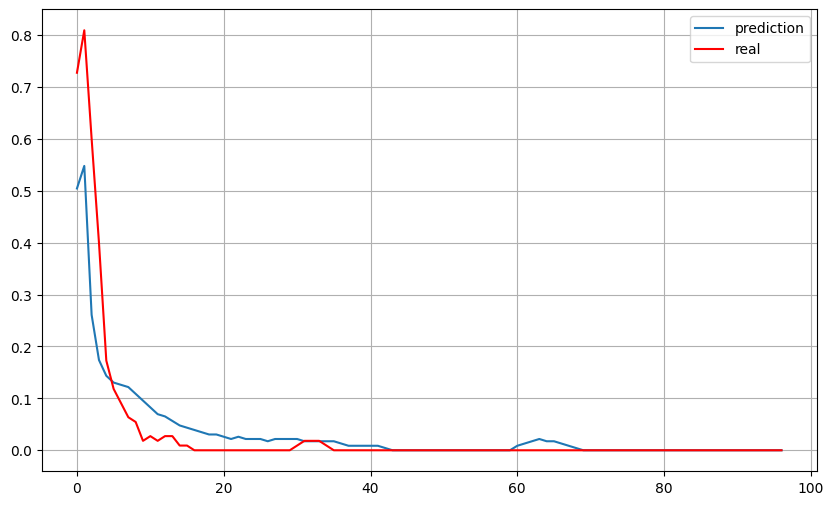

For ottawashooting_524926472432410625, with 83 total msgs


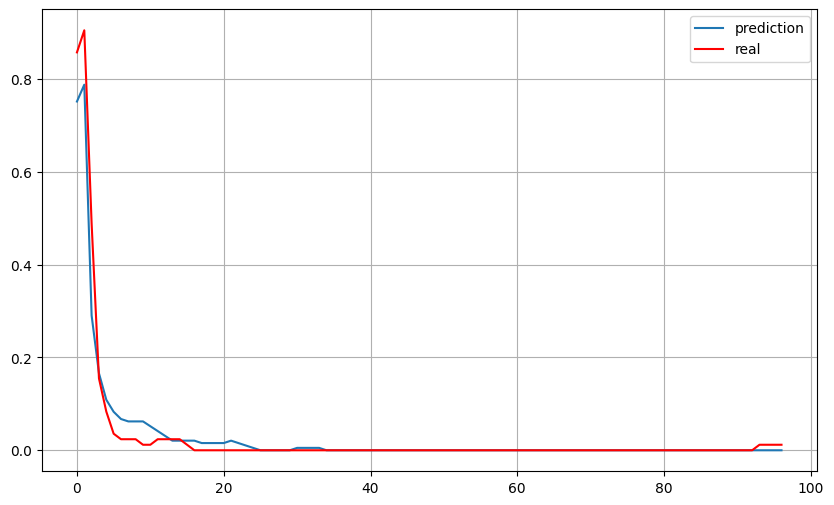

For ottawashooting_524929497205055488, with 202 total msgs


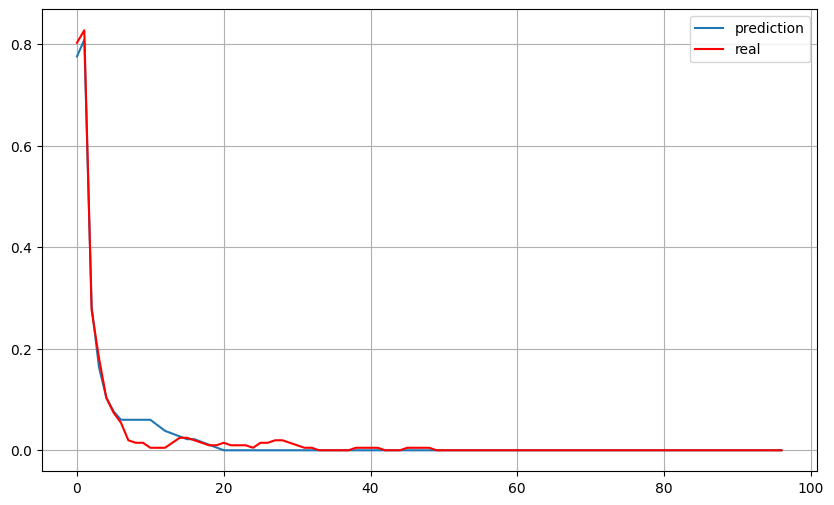

For ottawashooting_524940659778920448, with 153 total msgs


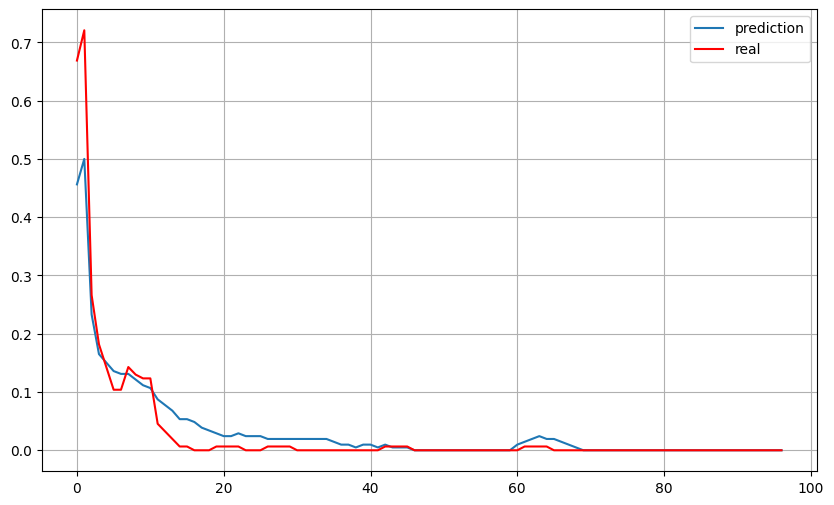

For ottawashooting_524947867975561216, with 960 total msgs


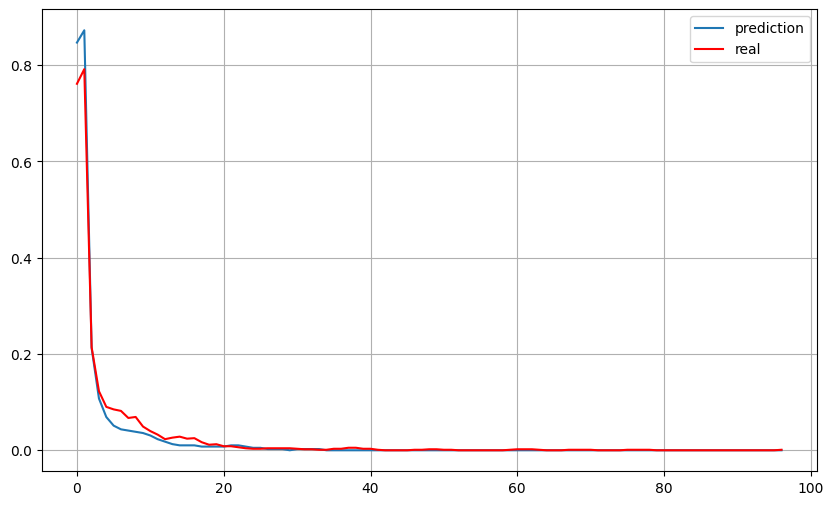

For ottawashooting_524952883343925249, with 981 total msgs


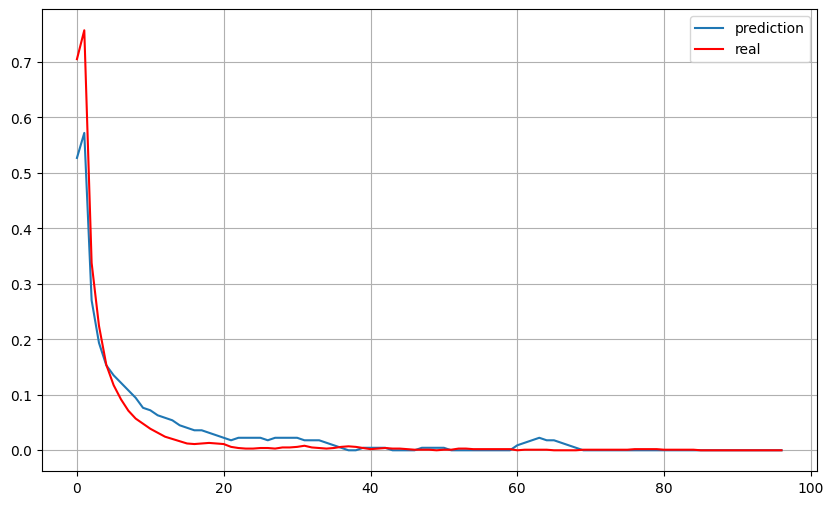

For ottawashooting_524959809402331137, with 387 total msgs


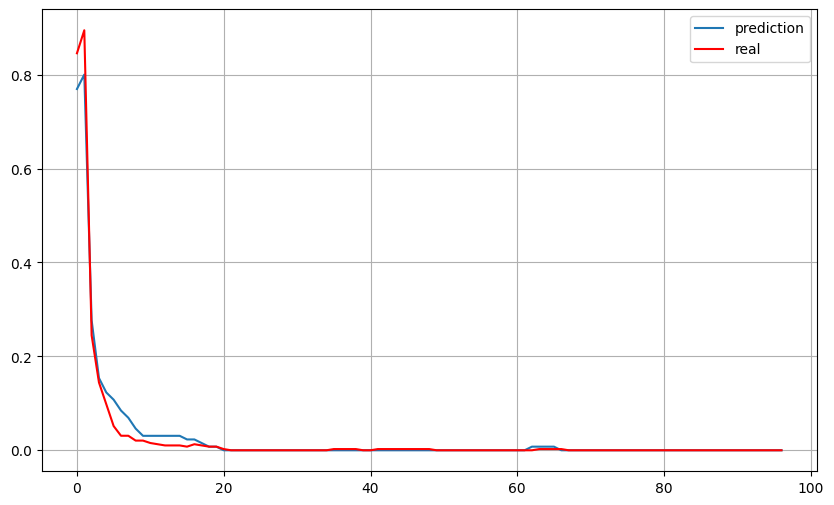

For ottawashooting_524969201102901248, with 307 total msgs


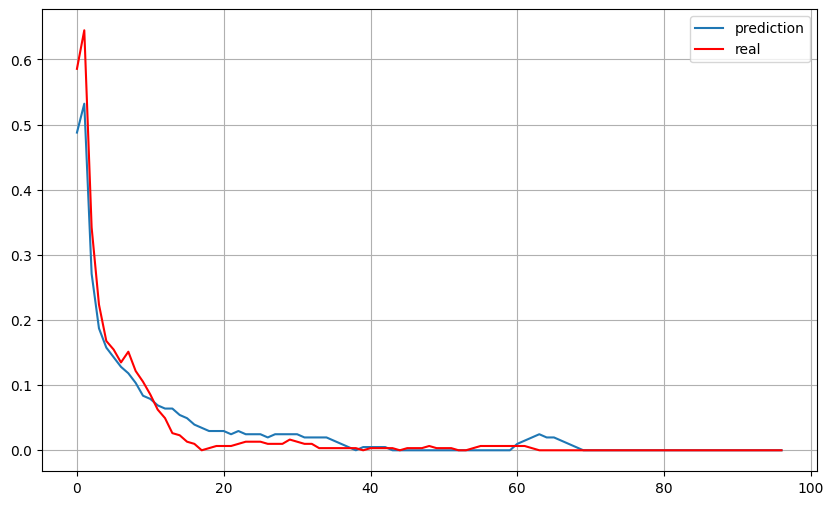

For ottawashooting_524970851675176960, with 161 total msgs


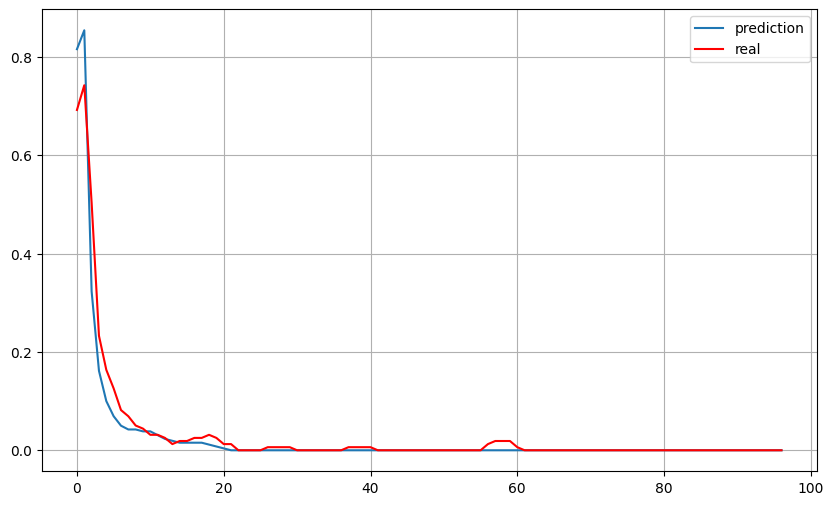

For ottawashooting_524980744658382848, with 222 total msgs


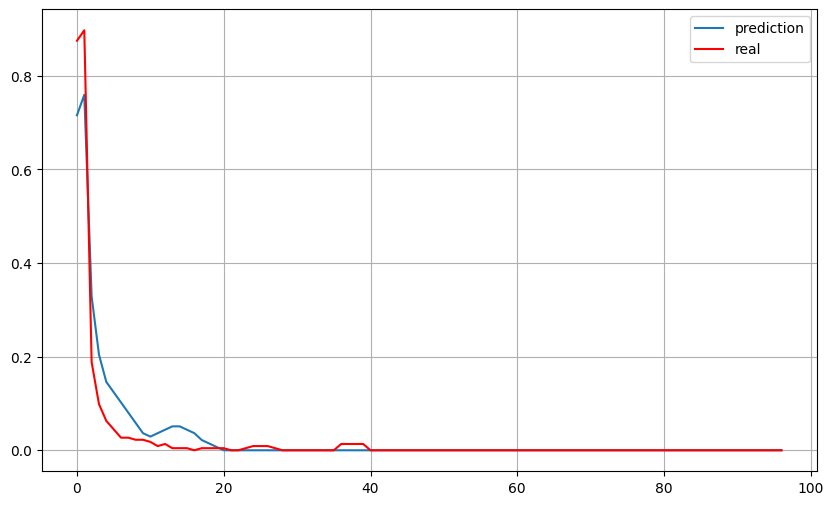

For ottawashooting_524983581983375360, with 457 total msgs


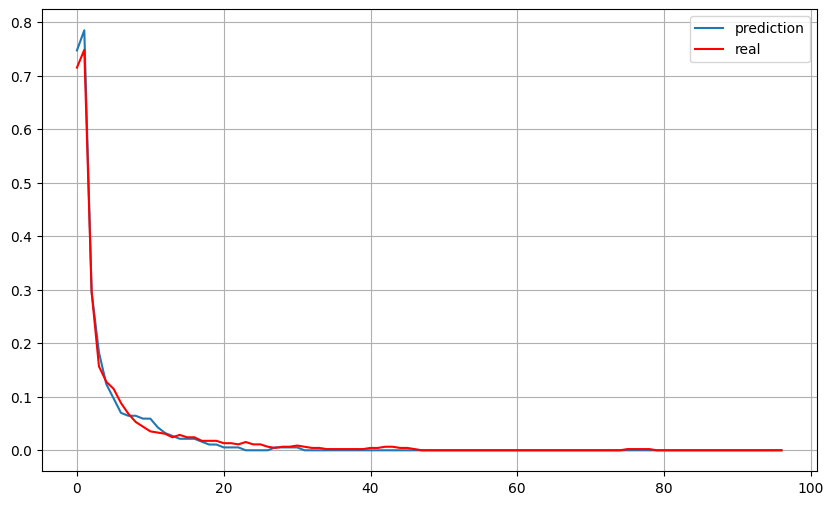

For ottawashooting_524991576163250176, with 108 total msgs


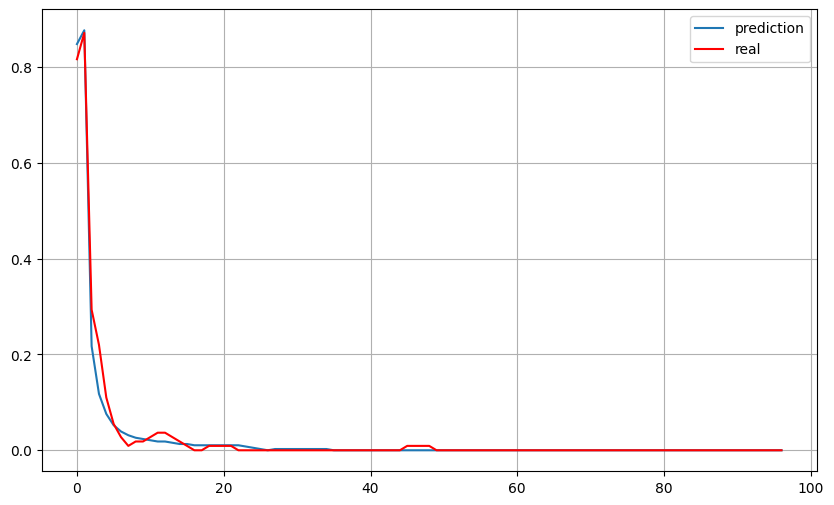

For ottawashooting_525032872647065600, with 126 total msgs


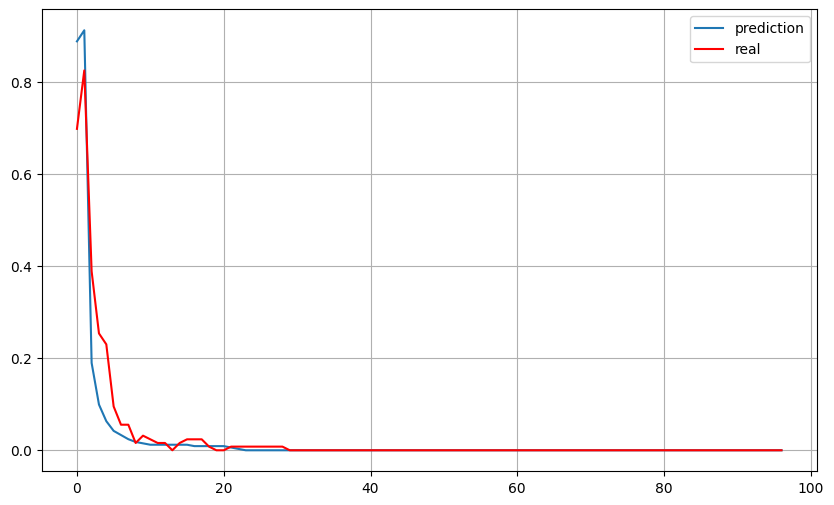

For ottawashooting_525060425184858112, with 360 total msgs


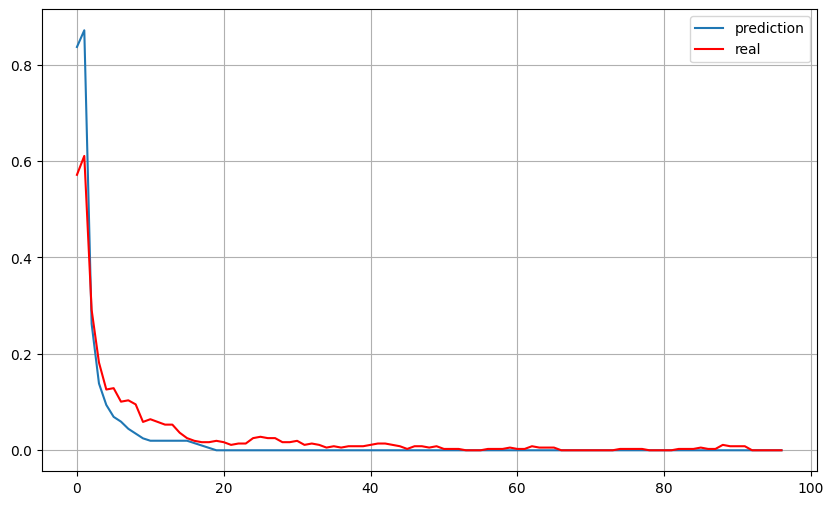

For ottawashooting_525068915068923904, with 98 total msgs


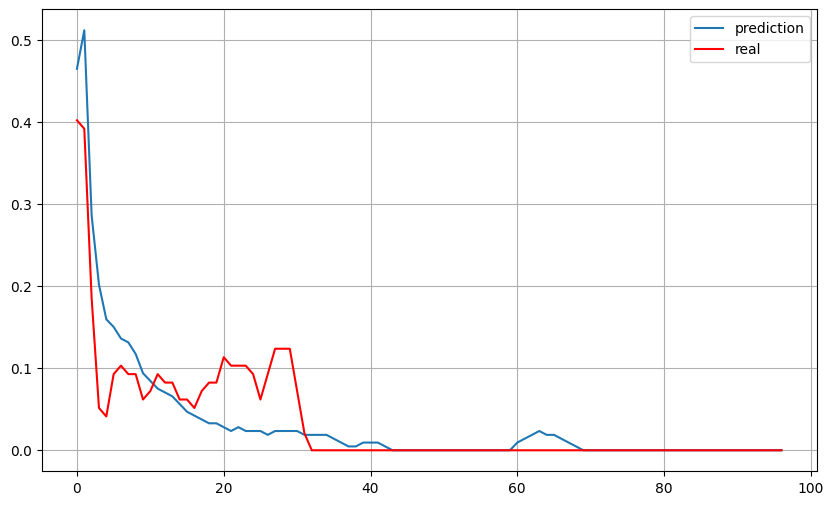

For ottawashooting_524966904885428226, with 131 total msgs


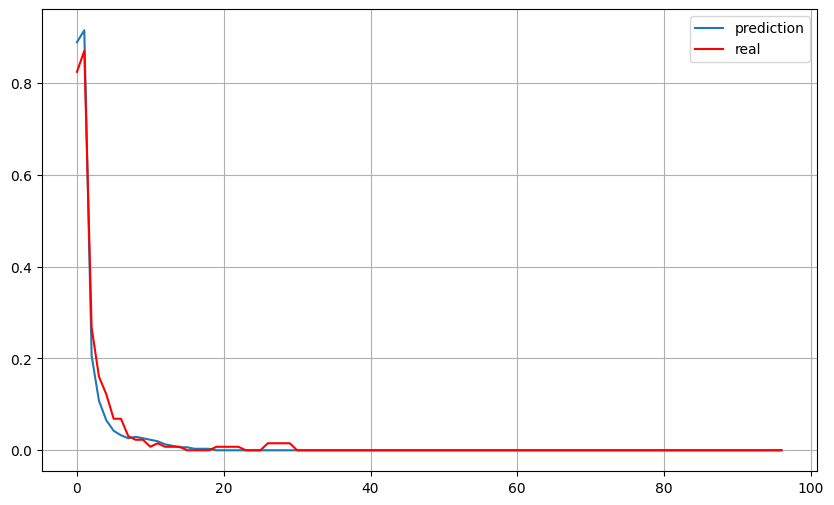

For ottawashooting_524922729485848576, with 59 total msgs


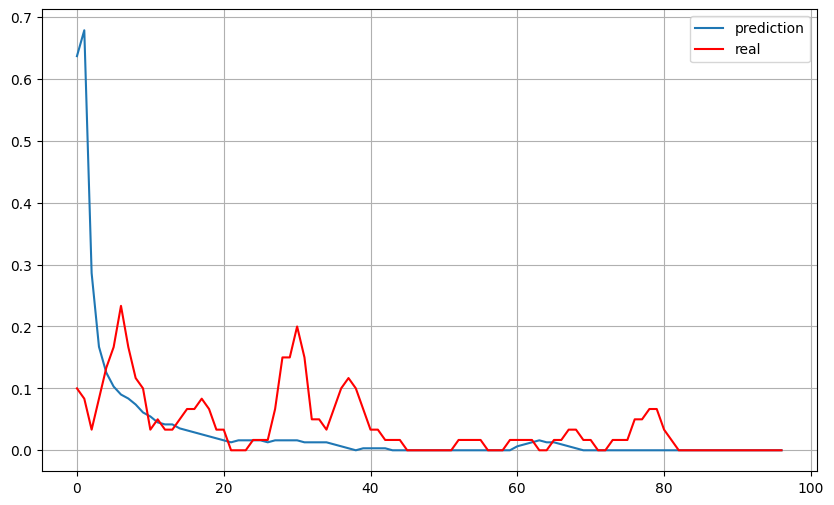

For ottawashooting_524923462398513152, with 108 total msgs


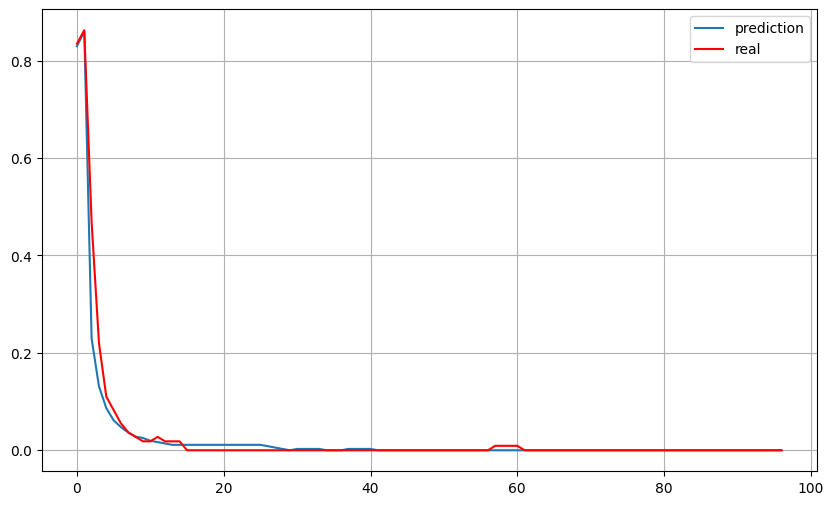

For ottawashooting_524923676484177920, with 209 total msgs


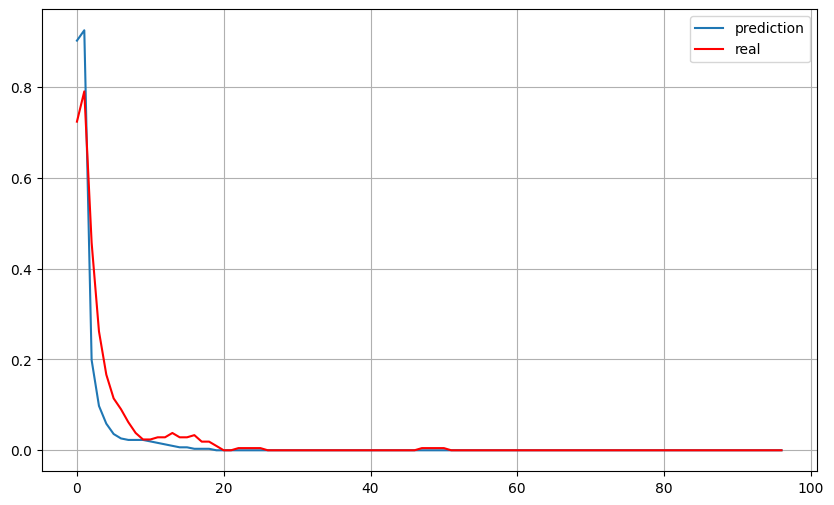

For ottawashooting_524924619812511746, with 15 total msgs


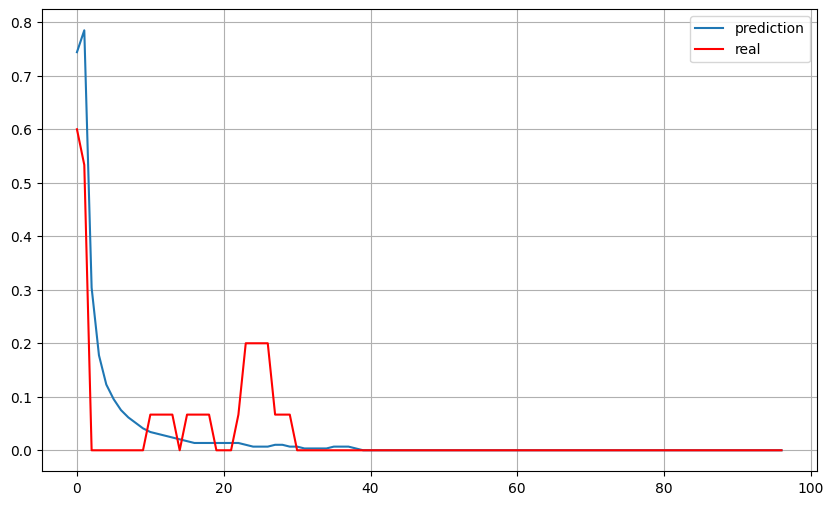

For ottawashooting_524925730053181440, with 459 total msgs


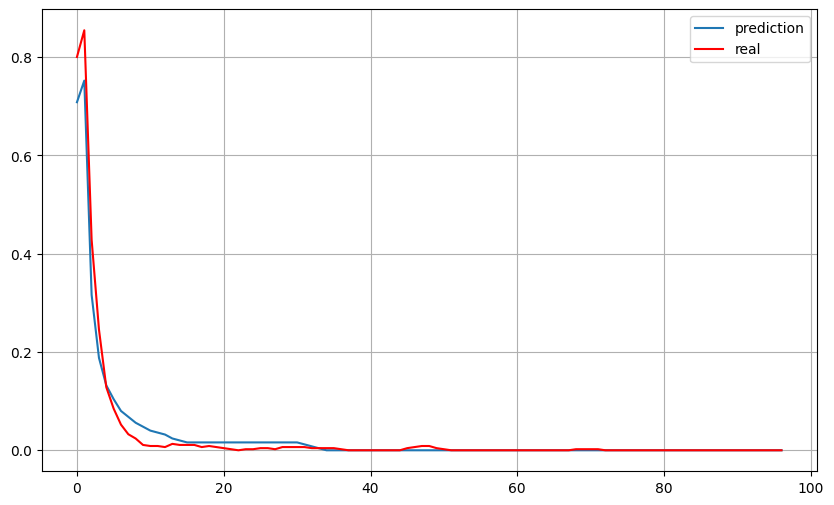

For ottawashooting_524926235030589440, with 79 total msgs


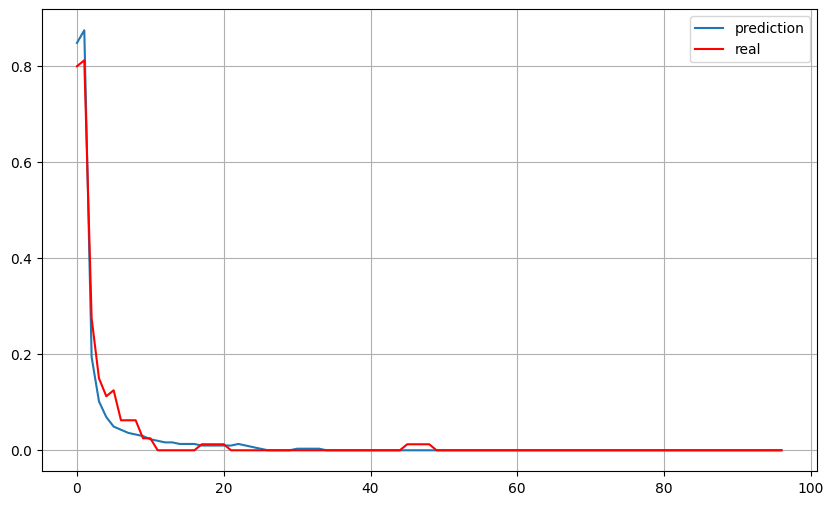

For ottawashooting_524927281048080385, with 707 total msgs


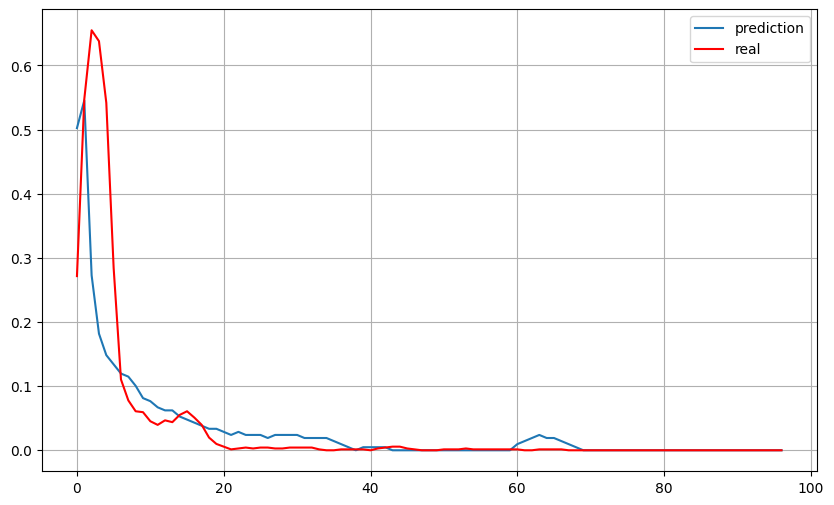

For ottawashooting_524931324763992064, with 137 total msgs


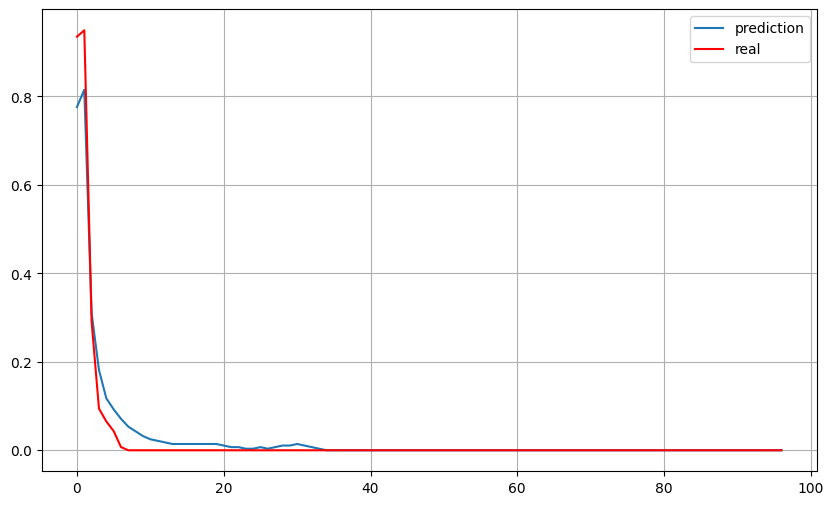

For ottawashooting_524932056560963584, with 11 total msgs


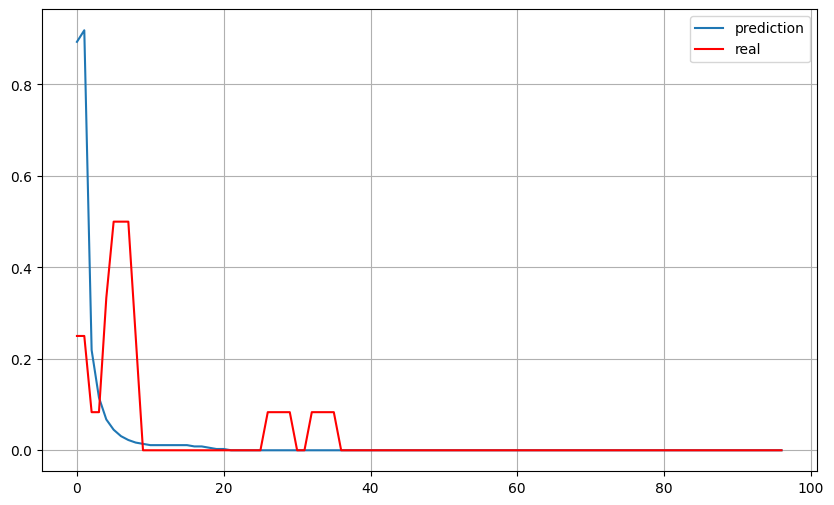

For ottawashooting_524932935137628160, with 202 total msgs


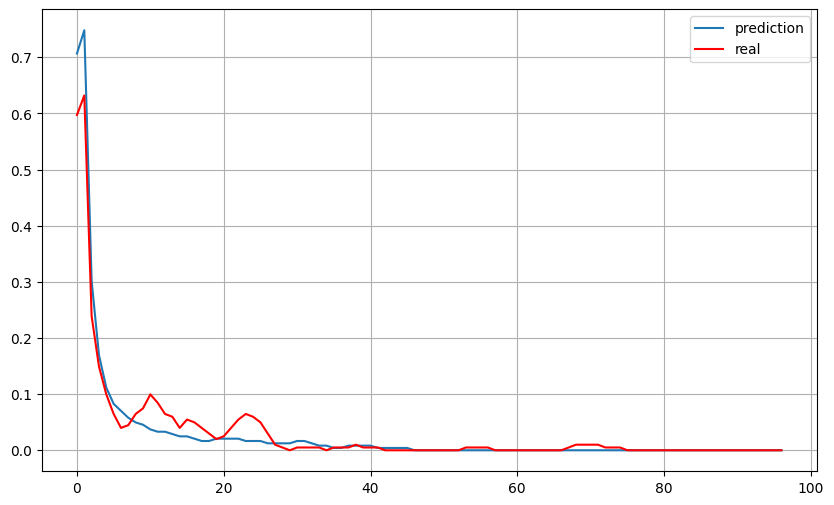

For ottawashooting_524935485370929152, with 102 total msgs


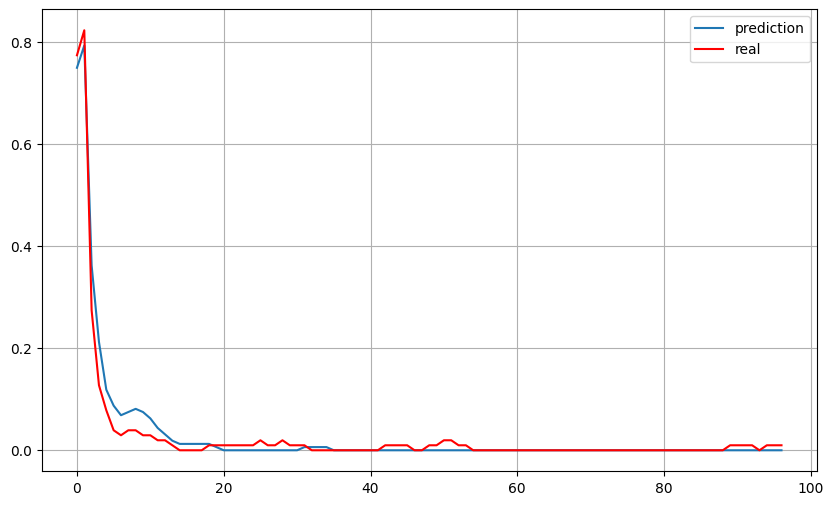

For ottawashooting_524936872666353664, with 780 total msgs


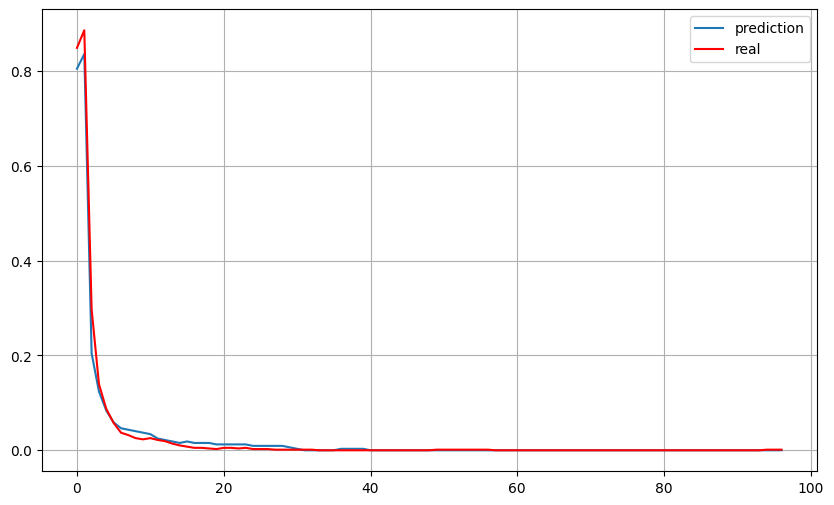

For ottawashooting_524937542131793920, with 196 total msgs


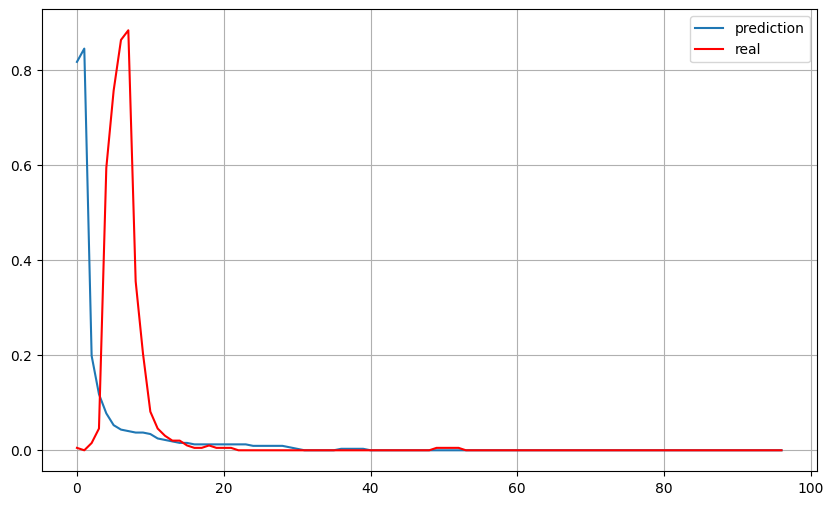

For ottawashooting_524941132237910016, with 66 total msgs


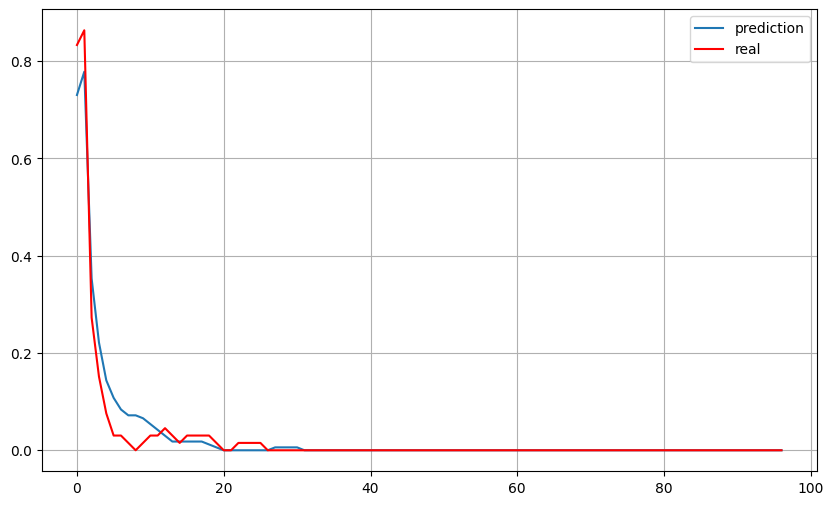

For ottawashooting_524942470472548352, with 13 total msgs


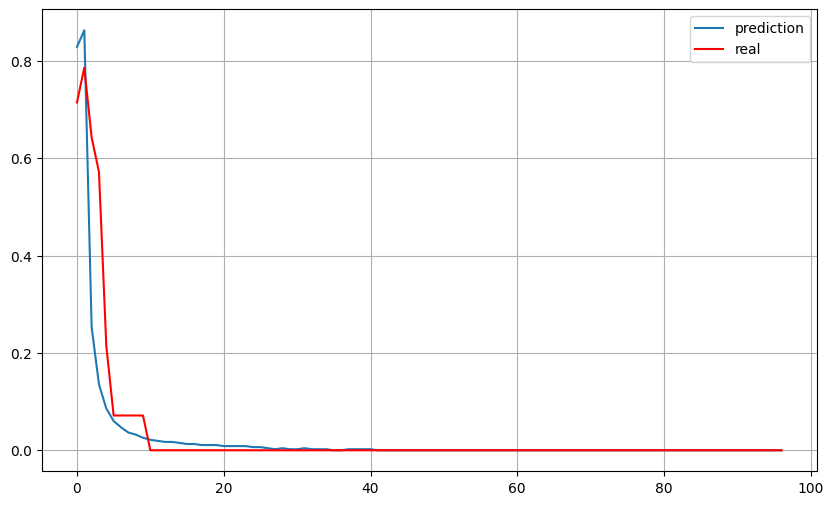

For ottawashooting_524943490887991296, with 509 total msgs


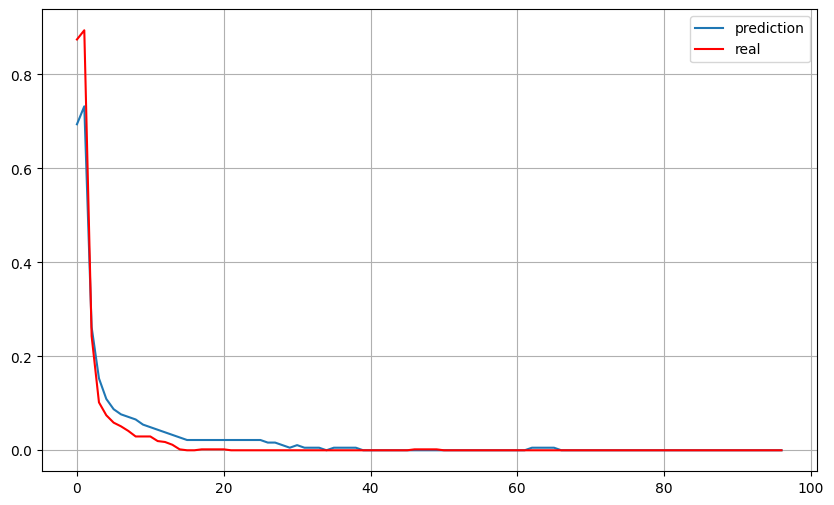

For ottawashooting_524944399890124801, with 684 total msgs


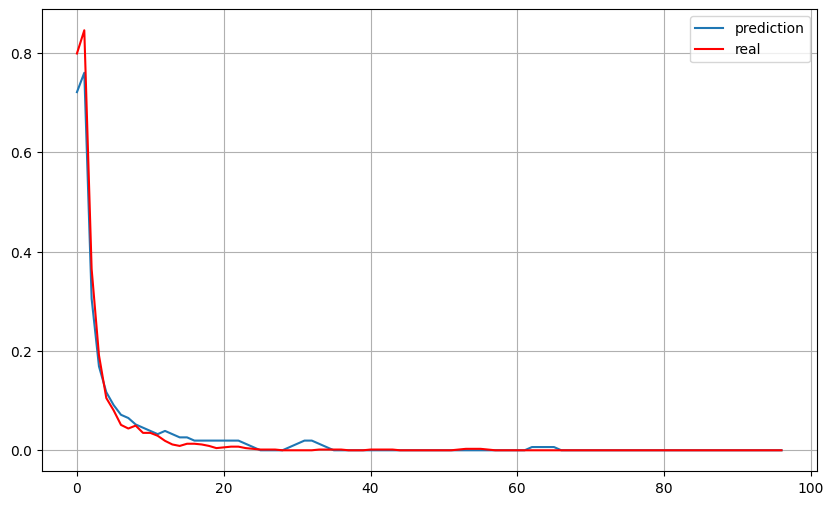

For ottawashooting_524947416869388288, with 222 total msgs


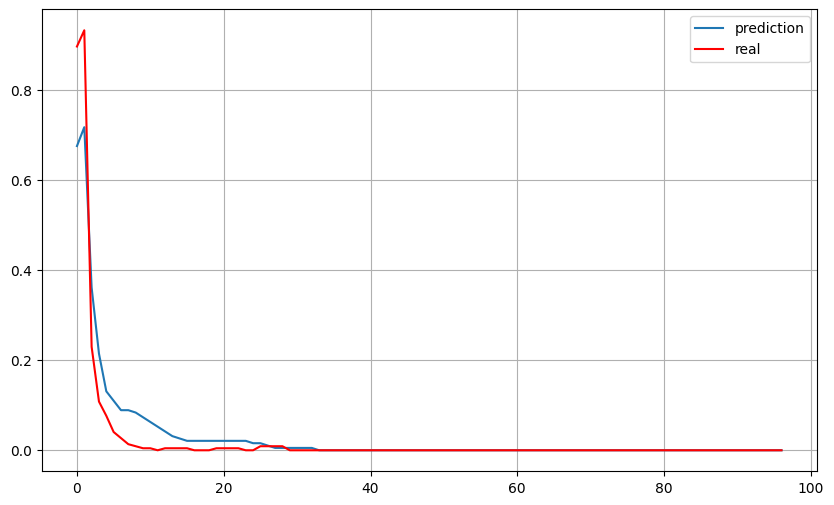

For ottawashooting_524947674164760577, with 135 total msgs


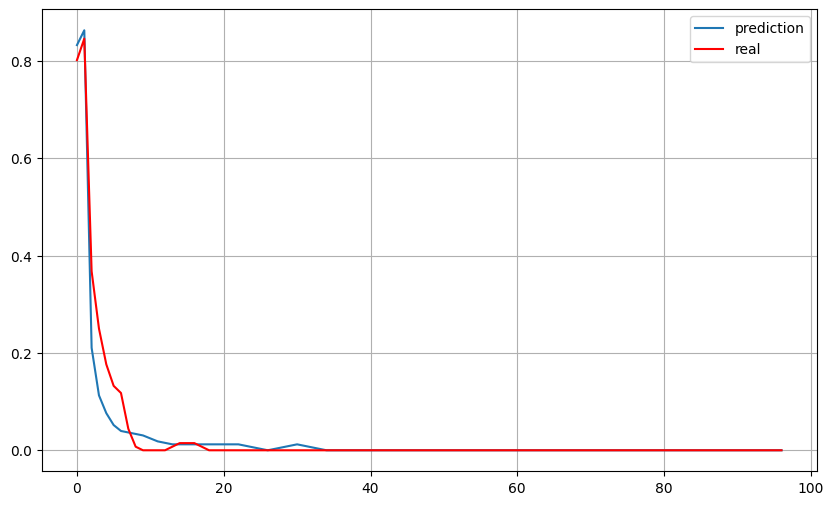

For ottawashooting_524948866773184512, with 171 total msgs


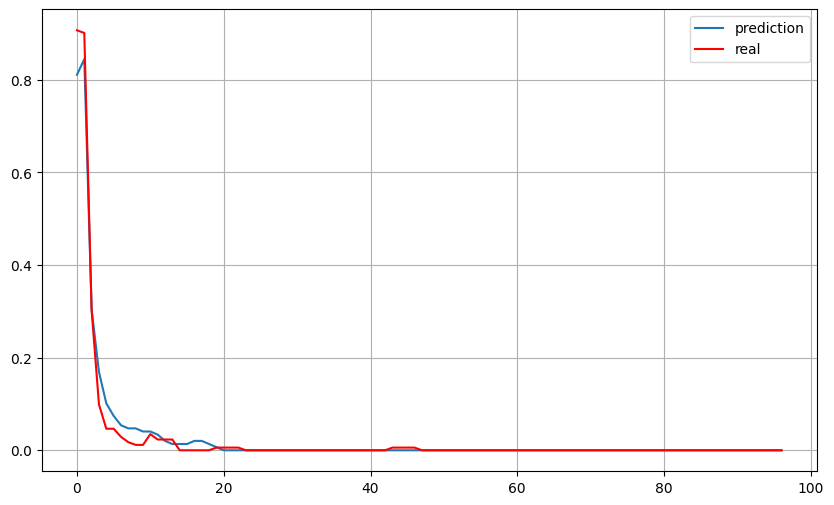

For ottawashooting_524949443607412737, with 229 total msgs


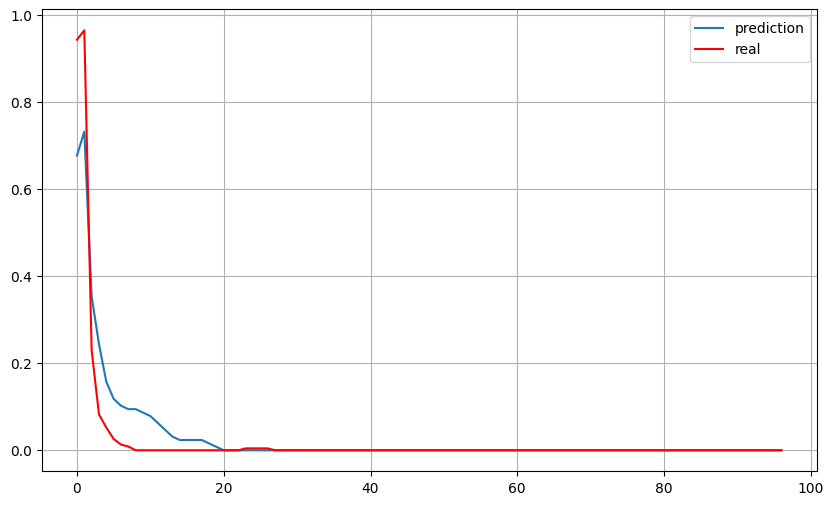

For ottawashooting_524956129017995264, with 645 total msgs


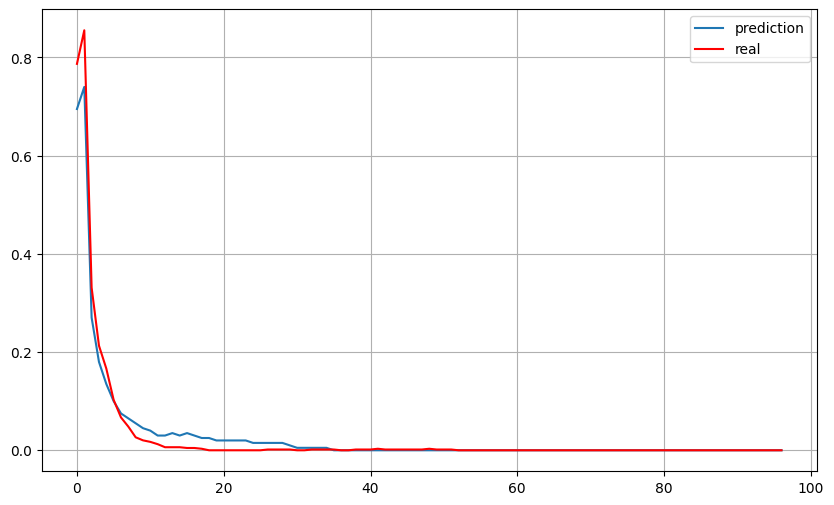

For ottawashooting_524962142563610625, with 177 total msgs


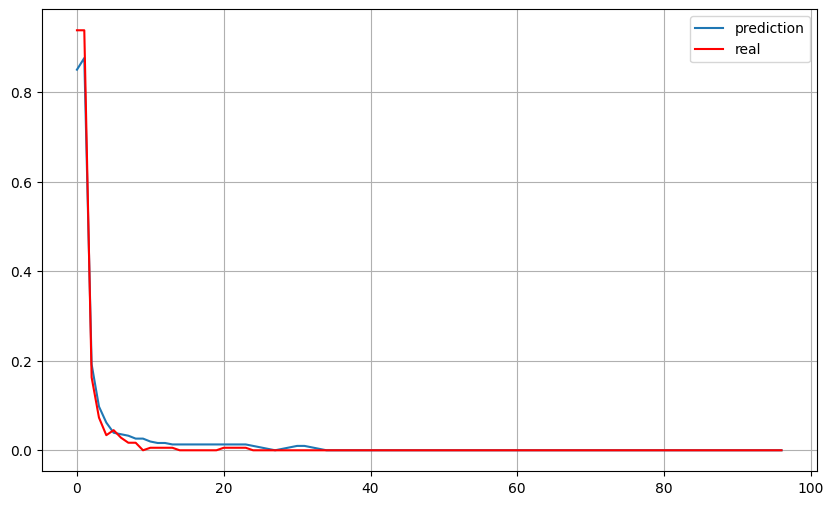

For ottawashooting_524964948683005952, with 721 total msgs


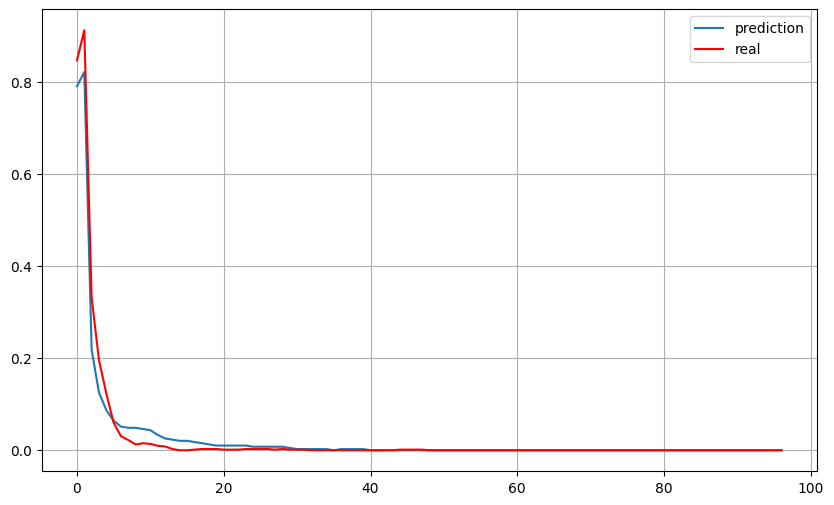

For ottawashooting_524965775036387329, with 160 total msgs


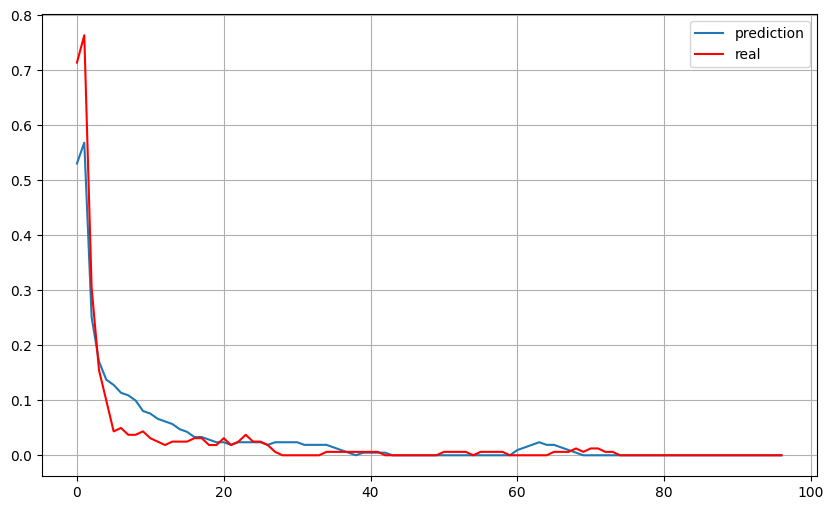

For ottawashooting_524972443308683264, with 152 total msgs


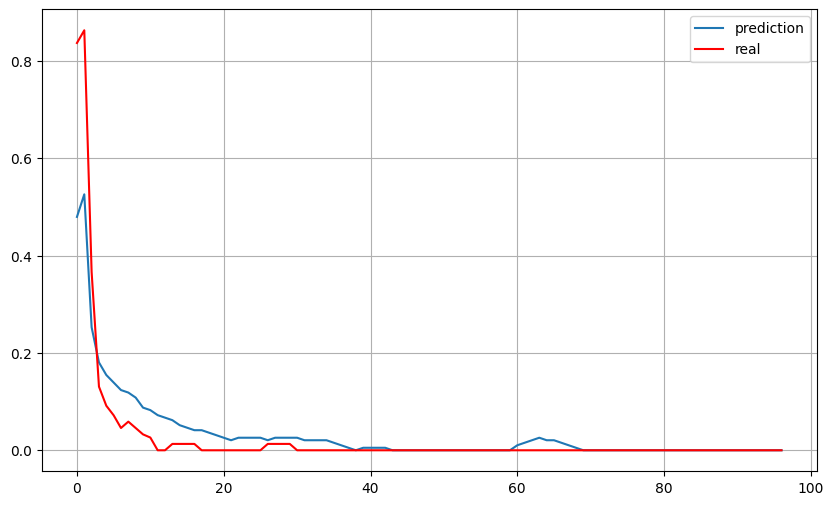

For ottawashooting_524975705206304769, with 382 total msgs


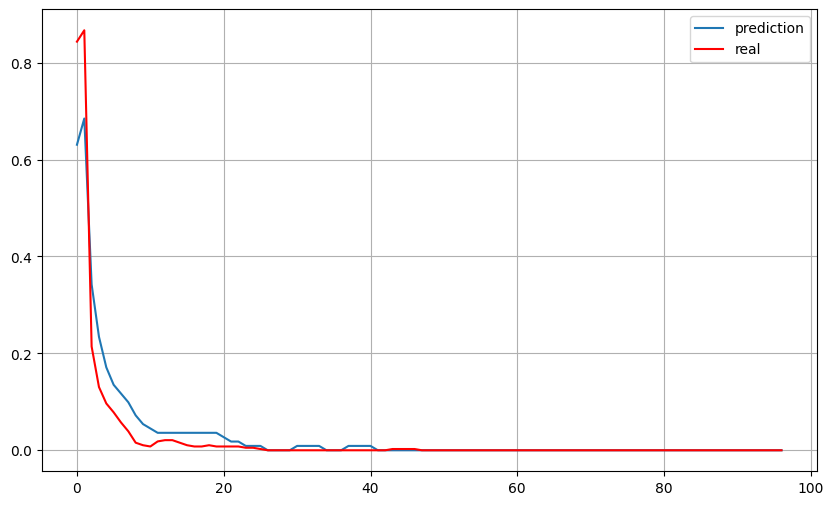

For ottawashooting_524981436252950528, with 175 total msgs


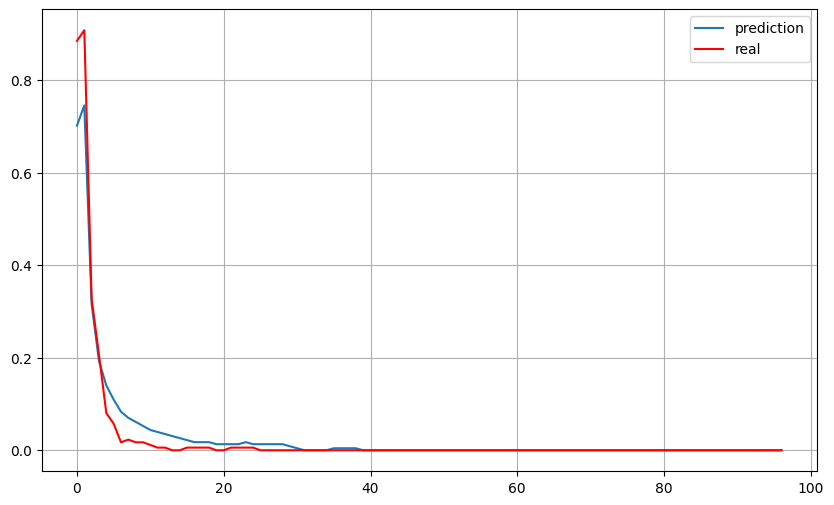

For ottawashooting_524990163446140928, with 267 total msgs


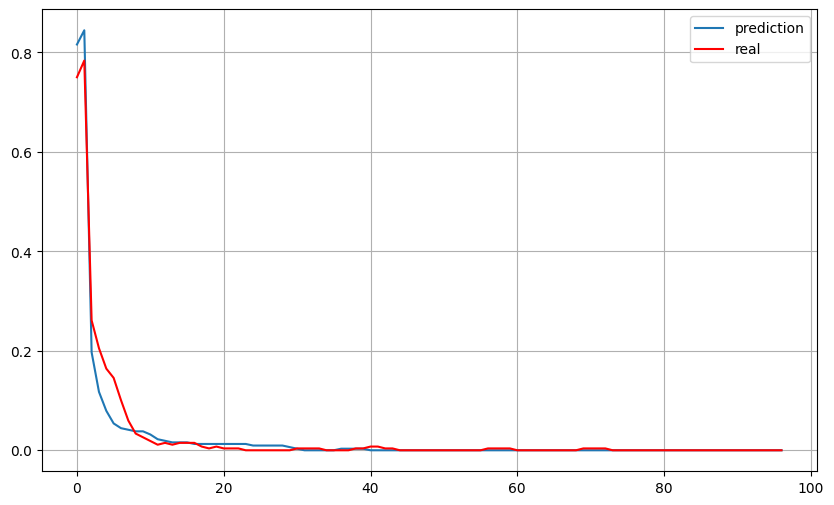

For ottawashooting_524993533212897281, with 214 total msgs


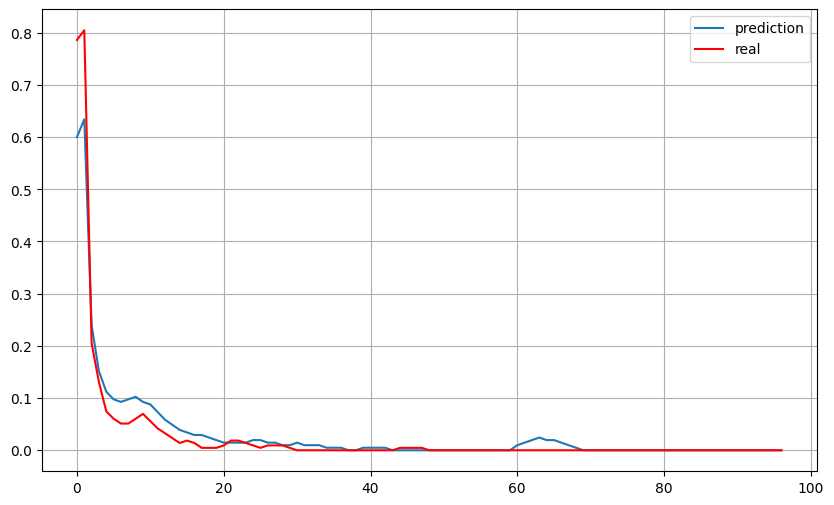

For ottawashooting_524995771587108864, with 106 total msgs


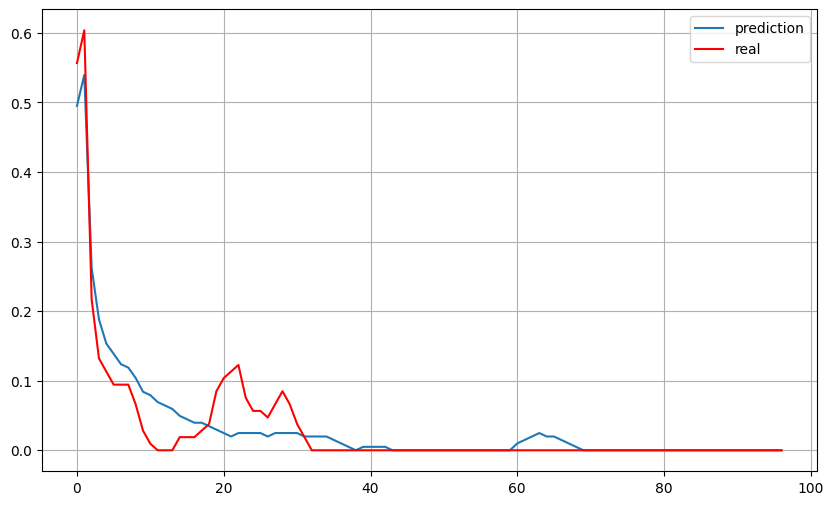

For ottawashooting_525003468659228672, with 385 total msgs


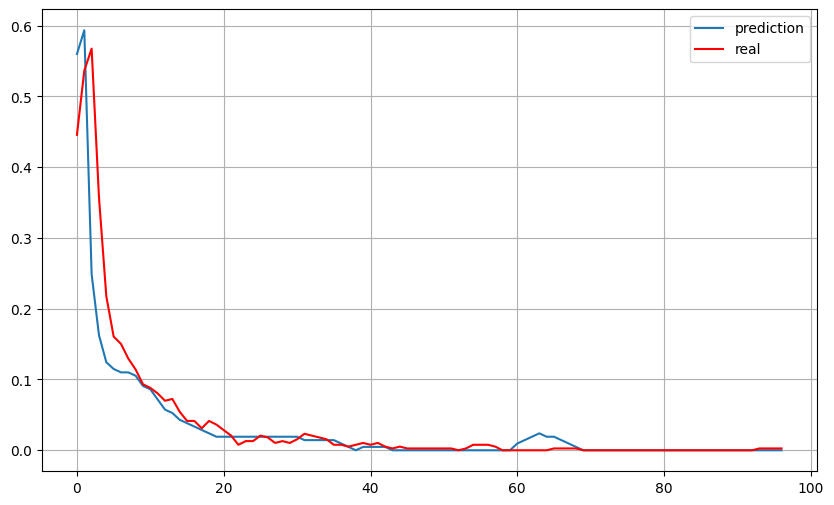

For ottawashooting_525019752507658240, with 505 total msgs


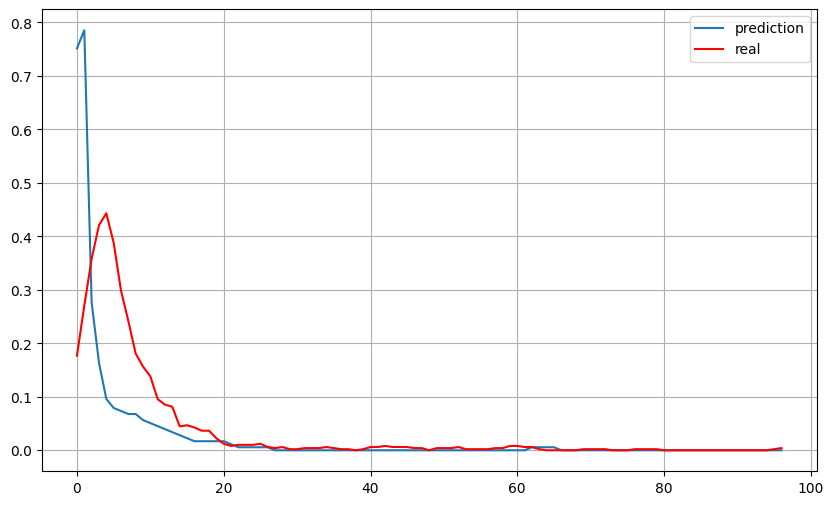

For ottawashooting_525023025792835585, with 117 total msgs


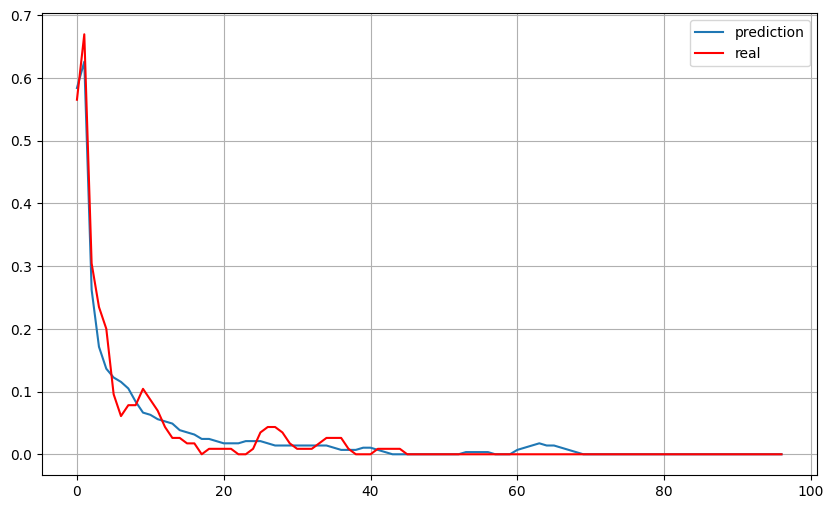

For ottawashooting_525025279803424768, with 115 total msgs


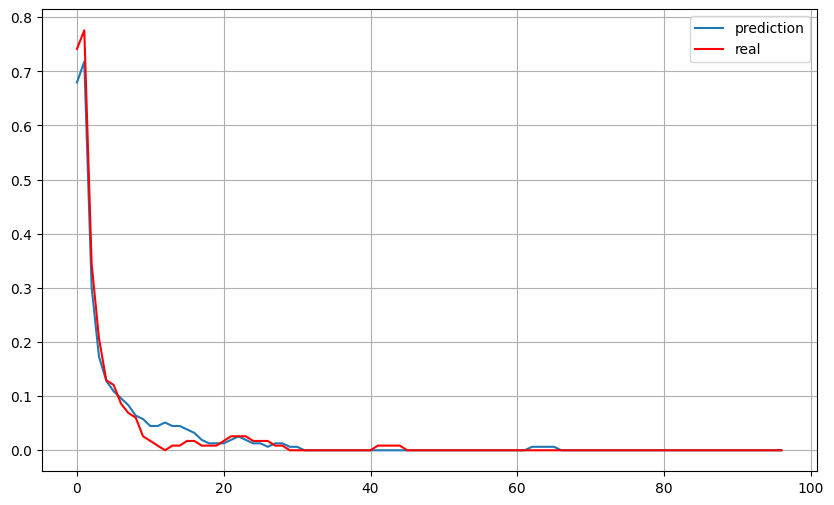

For ottawashooting_525025463648137216, with 146 total msgs


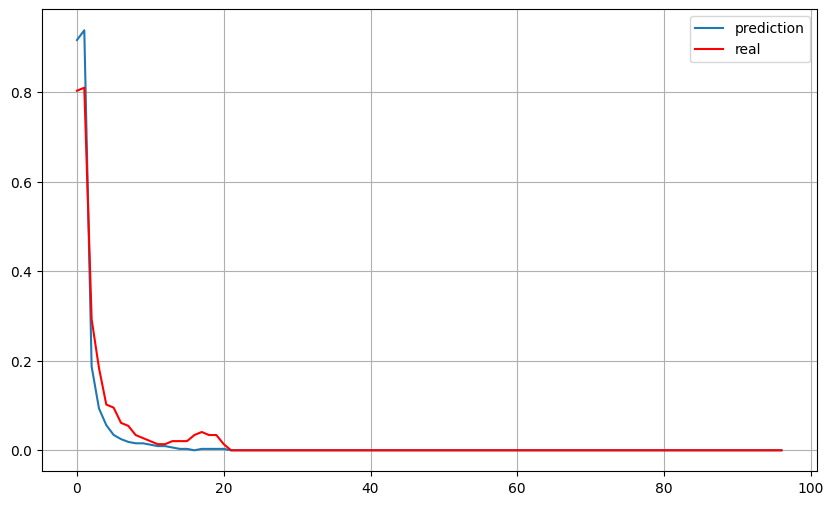

For ottawashooting_525028734991343617, with 119 total msgs


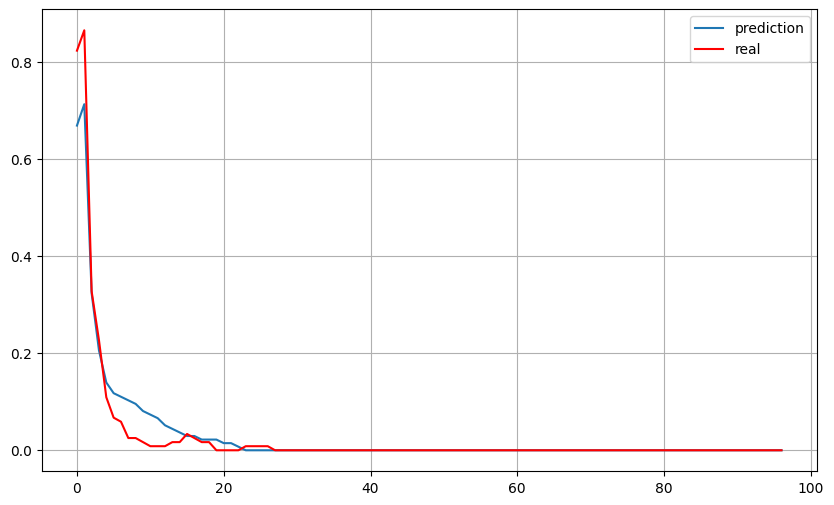

For ottawashooting_525049639016615937, with 182 total msgs


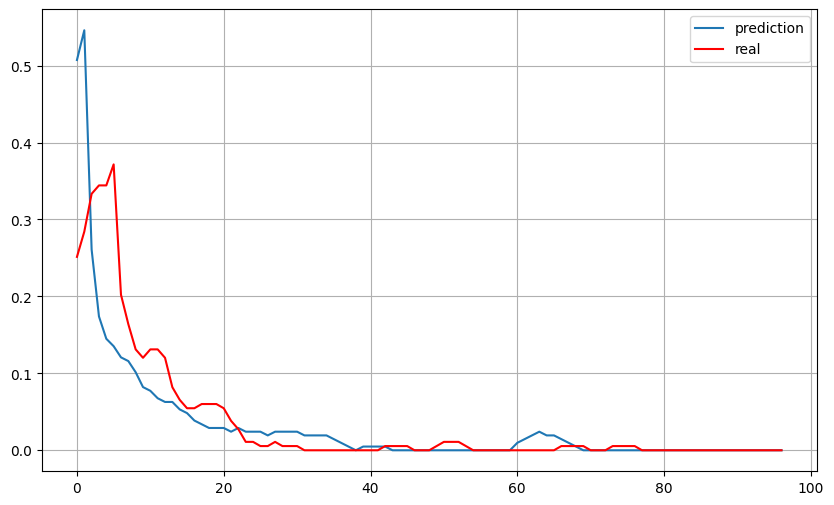

For ottawashooting_525056576038518785, with 1052 total msgs


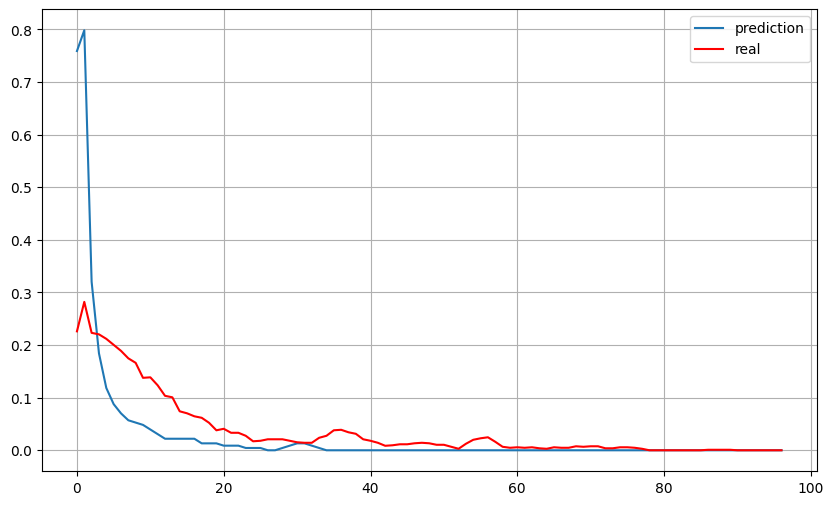

For ottawashooting_525058976376193024, with 235 total msgs


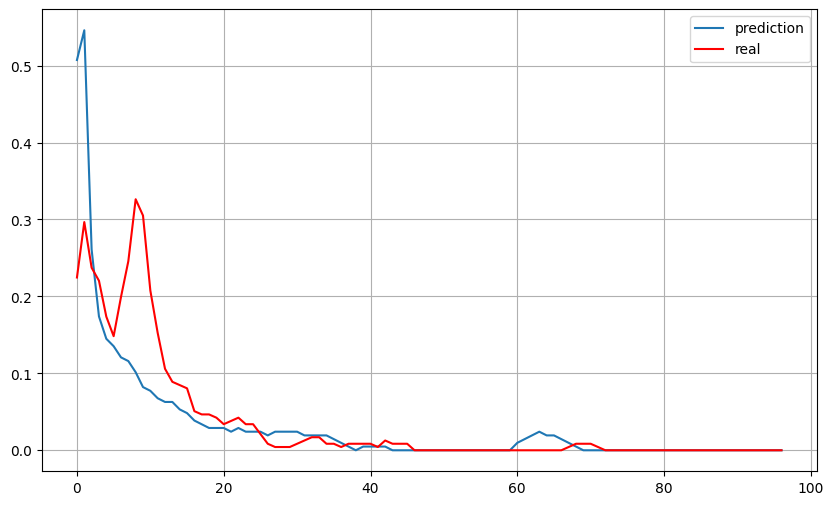

In [ ]:
window = 4

for j in range(len(timeline['result_pred_round'].iloc[36])):
  value = unique_idxs[j]
  print(f"For {value}, with {test[test['unique_idx'] ==value].iloc[0]['combined_preds']} total msgs")
  sim = np.asarray(timeline['result_pred_round'].iloc[36])[j][0:100]
  max_sim = sum(sim)

  real = np.asarray(timeline['test_pred'].iloc[36])[j][0:100]
  max_real= sum(real)

  list_sim = []
  list_real = []

  for i in range(len(sim) - window + 1): # cada i
    list_sim.append((sum(timeline['result_pred_round'].iloc[36][j][i: i + window])) / max_sim)
    list_real.append((sum(timeline['test_pred'].iloc[36][j][i: i + window])) / max_real)

  ys = list_sim
  xs = [x for x in range(len(ys))]
  plt.figure(figsize=(10, 6))
  plt.plot(xs,ys, label='prediction')
  ys = list_real
  xs = [x for x in range(len(ys))]
  plt.plot(xs,ys, '-r', label='real')
  plt.legend(loc="upper right")
  plt.grid(True)
  plt.show()

The error computed.

In [ ]:
def mean_absolute_error_edit(y_true, y_pred, clip = -1):
    window = 4

    list_tot_s = []
    list_tot_r = []

    for j in range(len(y_pred)):

      list_sim = []
      list_real = []
      max_sim = sum(y_pred[j][0:clip])
      max_real= sum(y_true[j][0:clip])

      for i in range(len(y_pred[j][0:clip]) - window + 1): # cada i
        if max_sim != 0:
          list_sim.append( (sum(y_pred[j][i: i + window])) / max_sim)
        else:
          list_sim.append(0)
        if max_real != 0:
          list_real.append((sum(y_true[j][i: i + window])) / max_real)
        else:
          list_real.append(0)

      list_tot_s.append(list_sim)
      list_tot_r.append(list_real)

    list_tot_r = np.array(list_tot_r)
    list_tot_s = np.array(list_tot_s)
    output_errors = np.average(np.abs(list_tot_s - list_tot_r), axis=0)

    return np.average(output_errors) * 100



Now we process for the output.

For ottawashooting_524925050739490816, with 198 total msgs


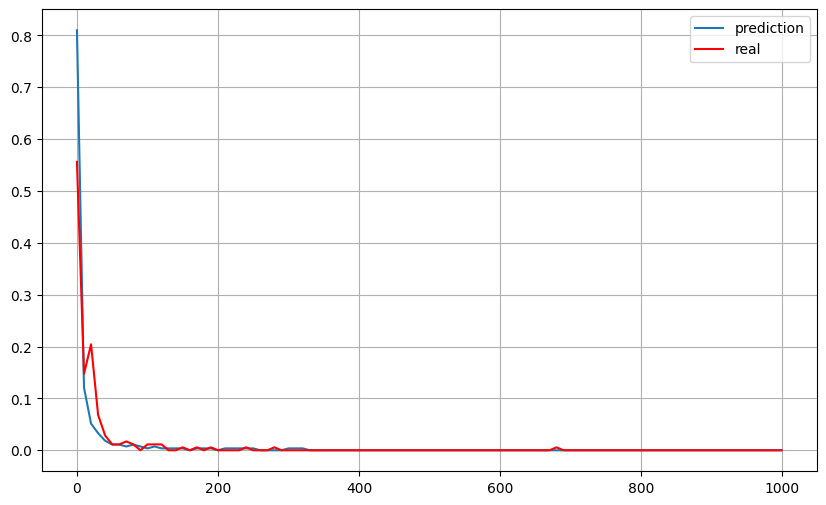

For ottawashooting_524925215235911680, with 407 total msgs


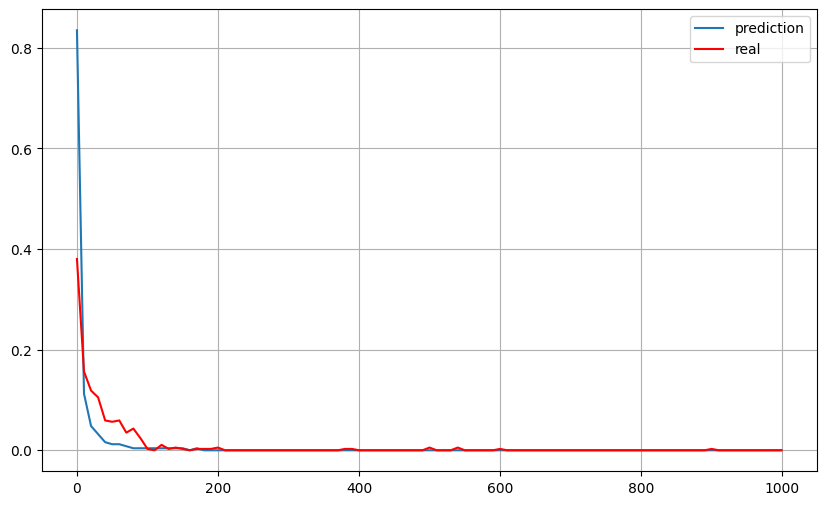

For ottawashooting_524925987239120897, with 109 total msgs


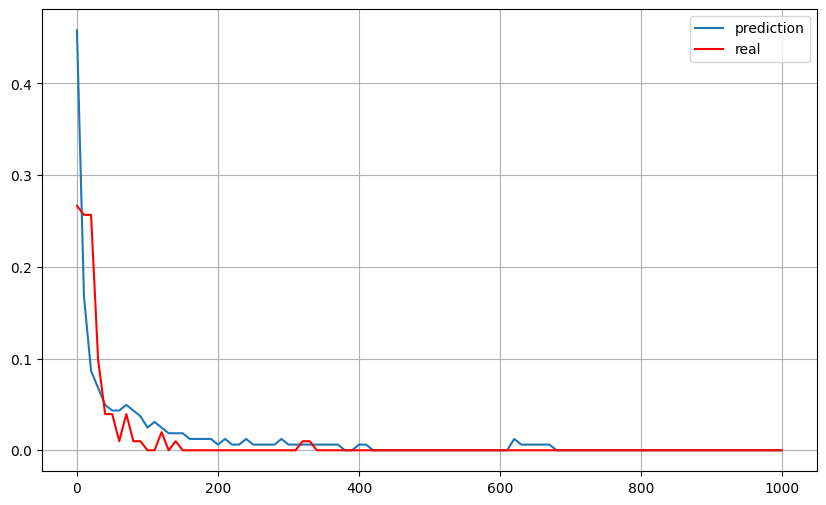

For ottawashooting_524926472432410625, with 83 total msgs


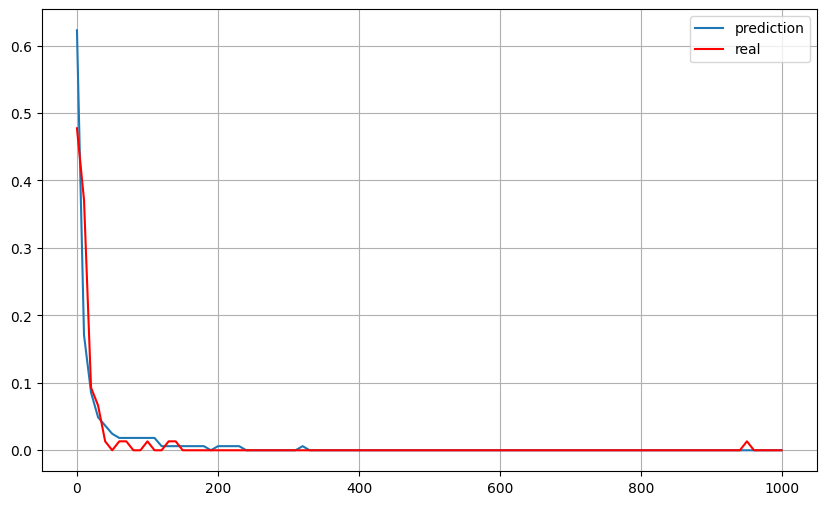

For ottawashooting_524929497205055488, with 202 total msgs


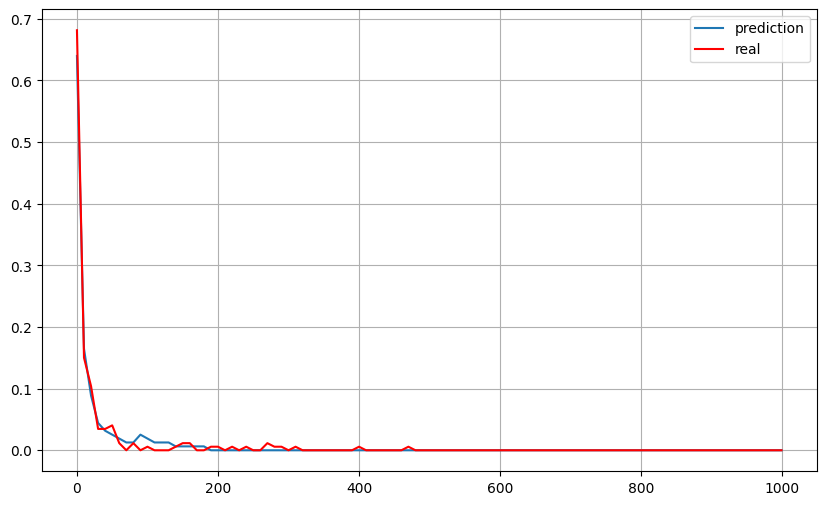

For ottawashooting_524940659778920448, with 153 total msgs


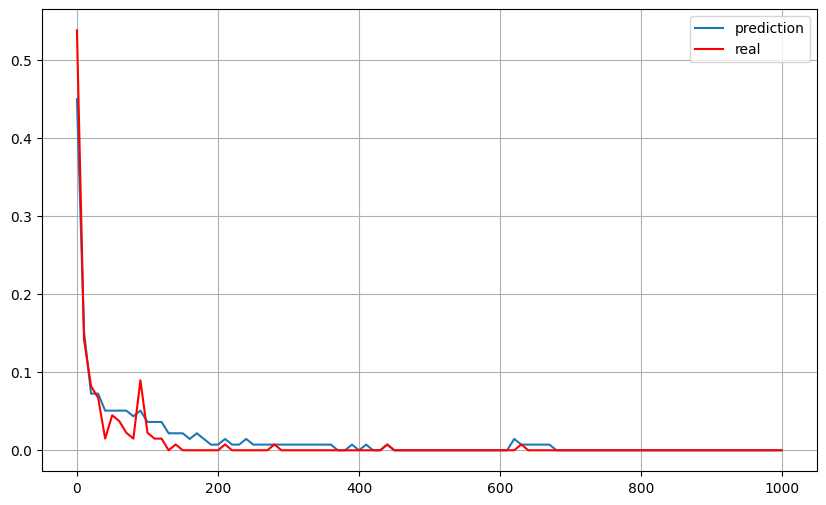

For ottawashooting_524947867975561216, with 960 total msgs


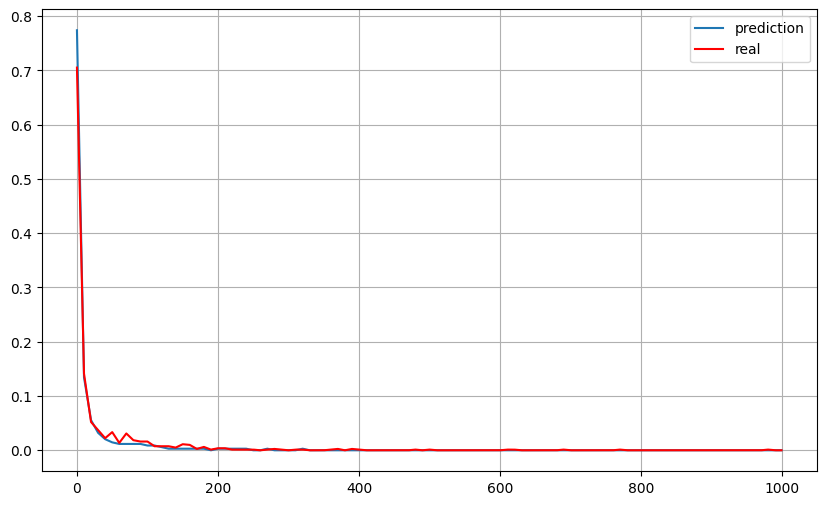

For ottawashooting_524952883343925249, with 981 total msgs


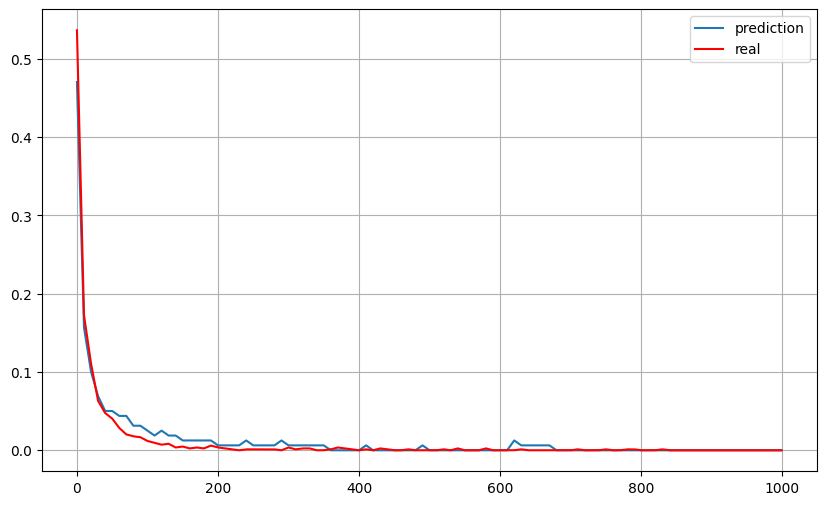

For ottawashooting_524959809402331137, with 387 total msgs


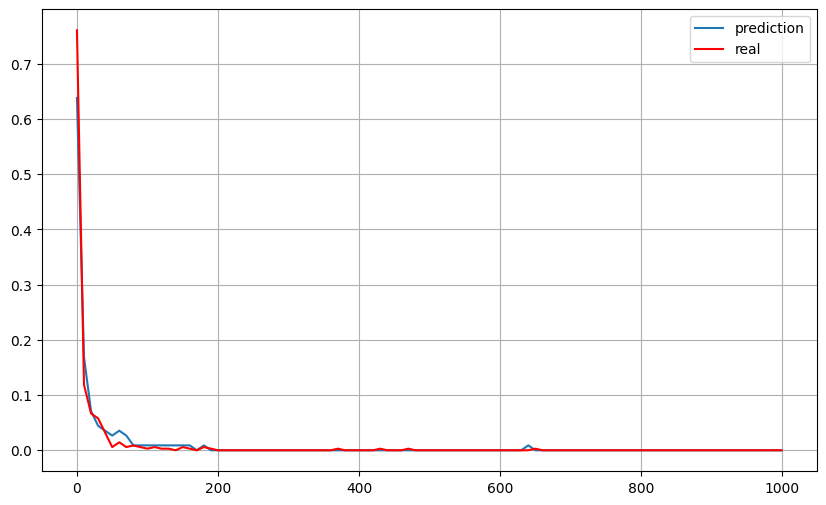

For ottawashooting_524969201102901248, with 307 total msgs


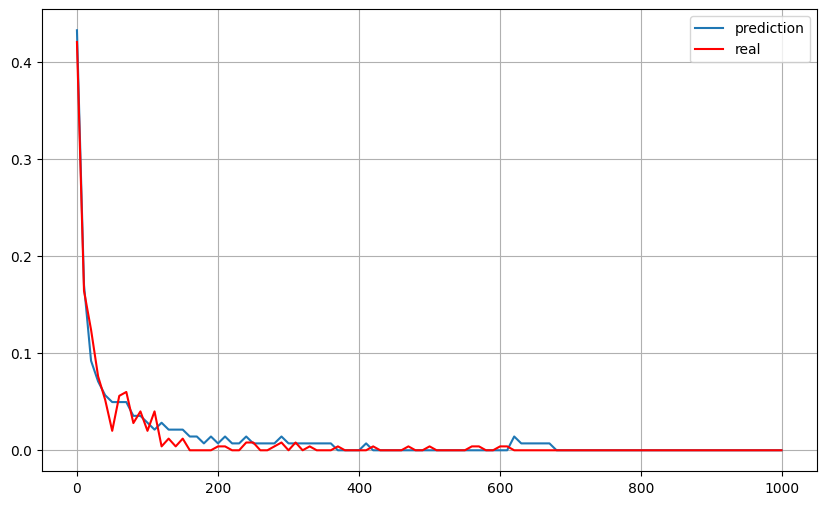

For ottawashooting_524970851675176960, with 161 total msgs


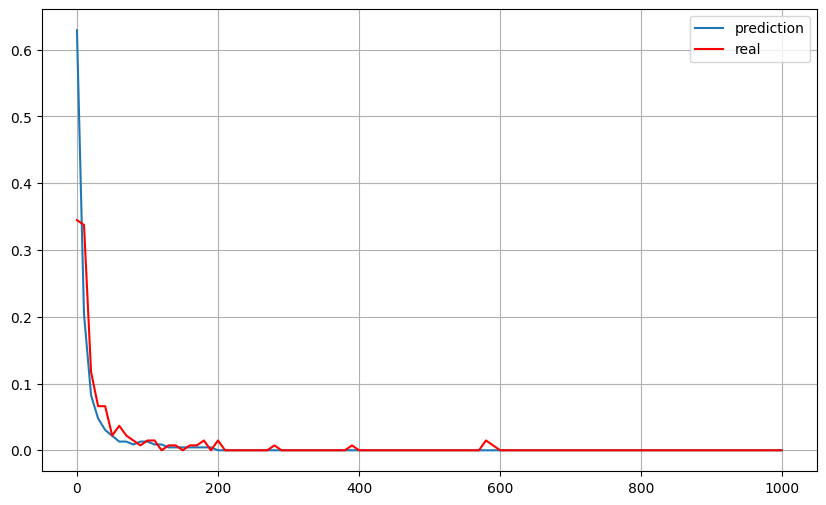

For ottawashooting_524980744658382848, with 222 total msgs


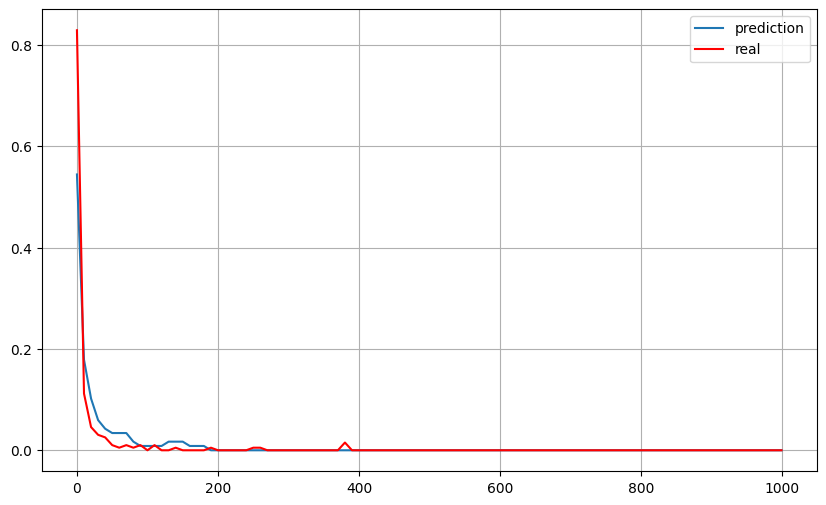

For ottawashooting_524983581983375360, with 457 total msgs


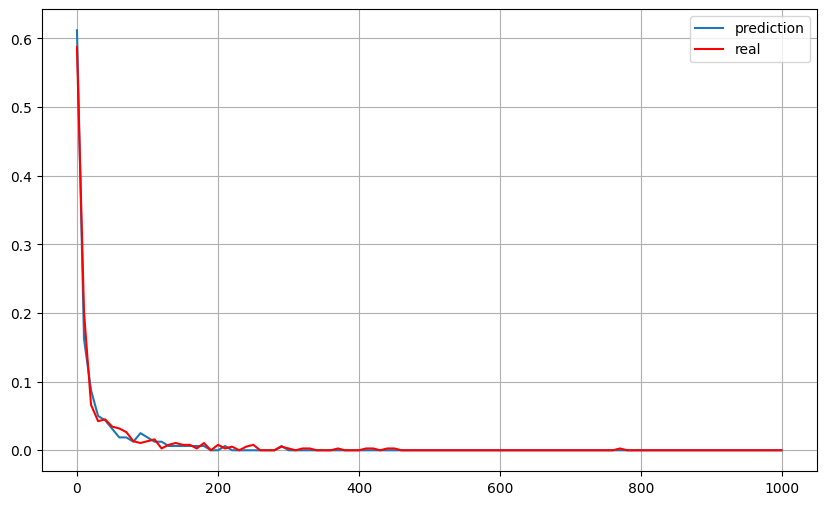

For ottawashooting_524991576163250176, with 108 total msgs


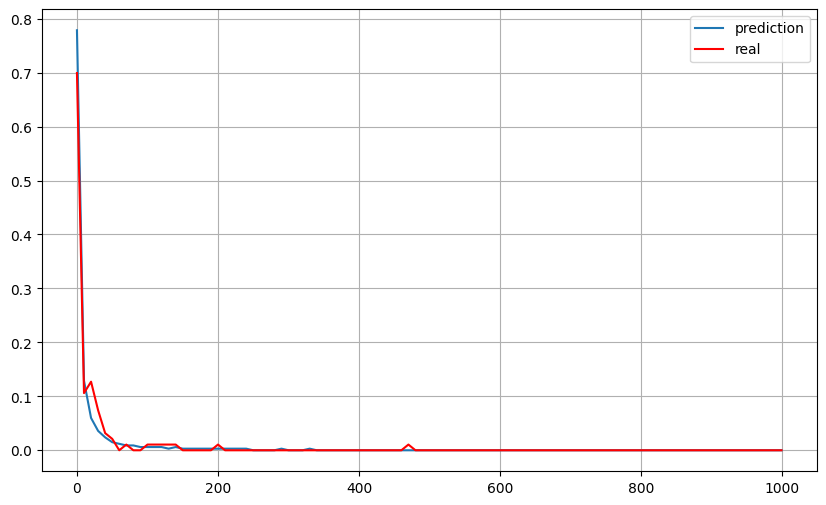

For ottawashooting_525032872647065600, with 126 total msgs


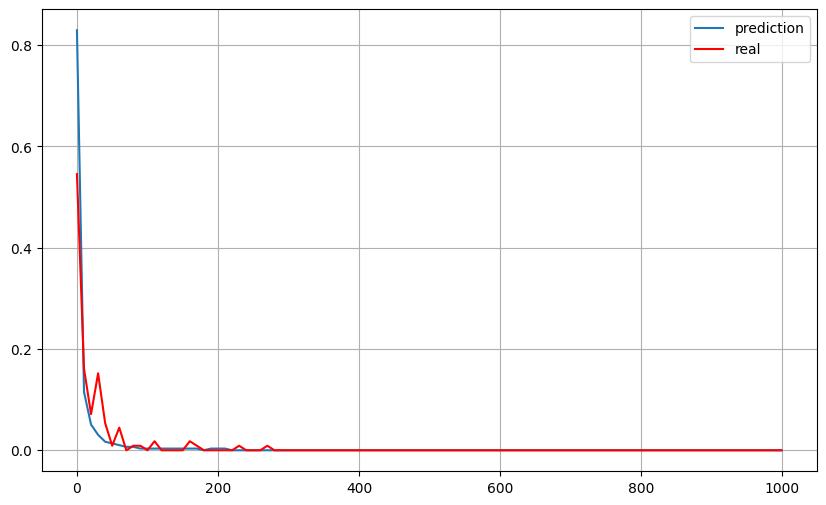

For ottawashooting_525060425184858112, with 360 total msgs


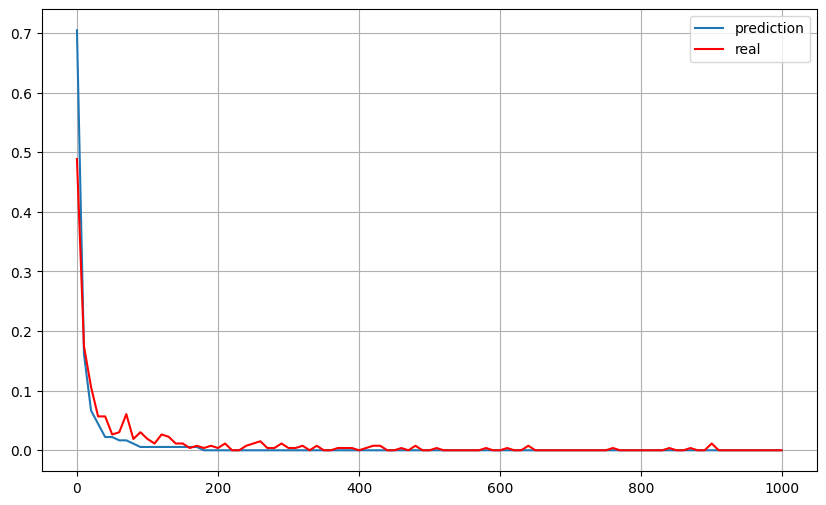

For ottawashooting_525068915068923904, with 98 total msgs


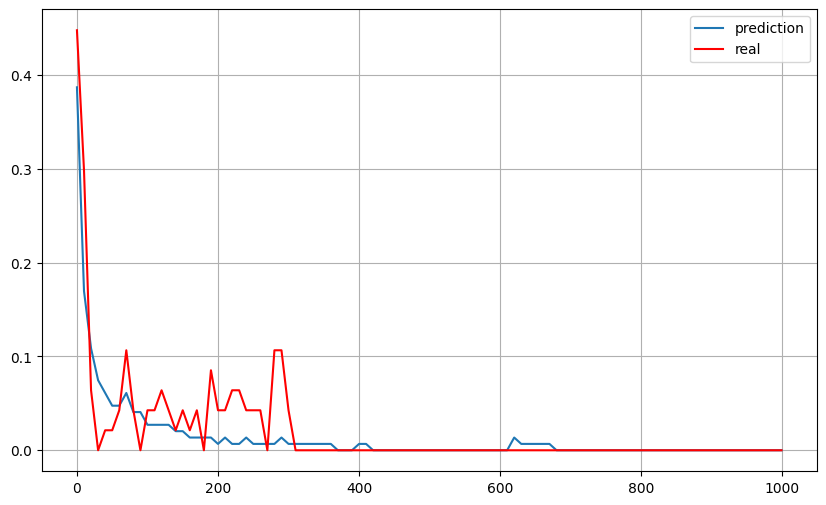

For ottawashooting_524966904885428226, with 131 total msgs


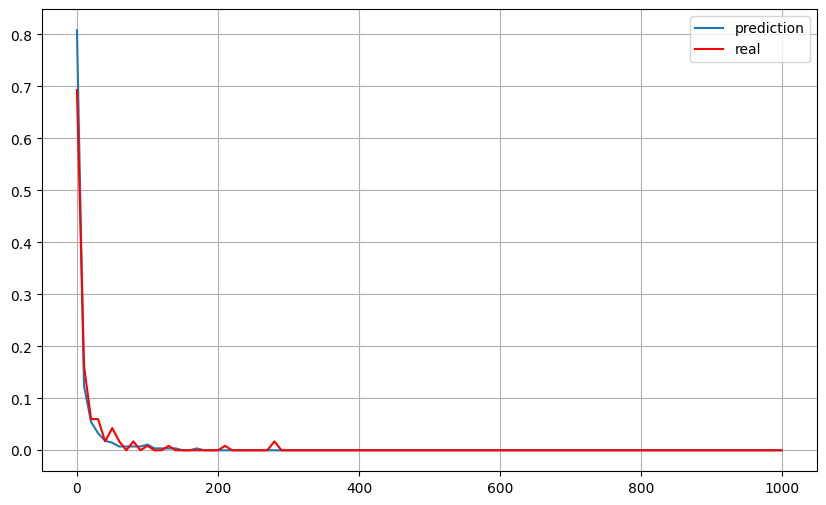

For ottawashooting_524922729485848576, with 59 total msgs


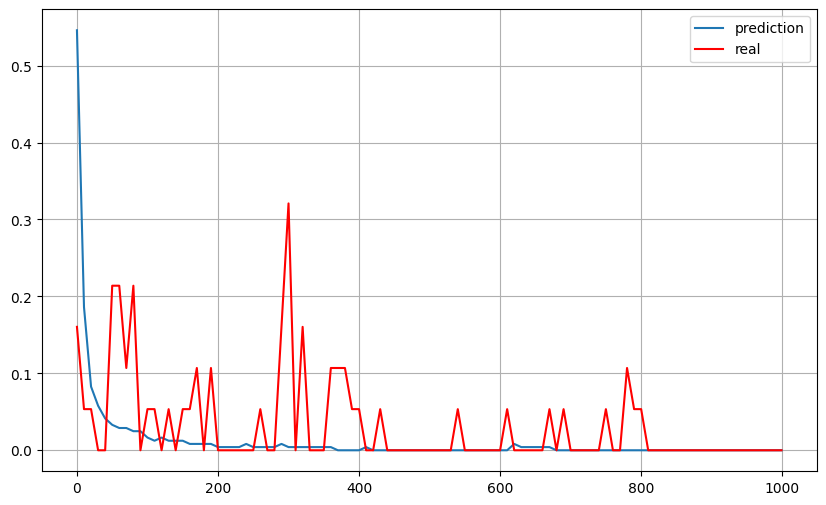

For ottawashooting_524923462398513152, with 108 total msgs


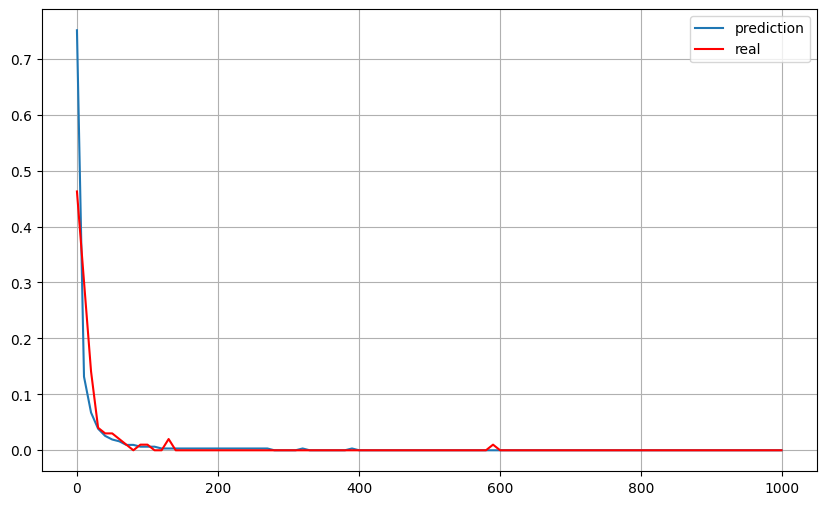

For ottawashooting_524923676484177920, with 209 total msgs


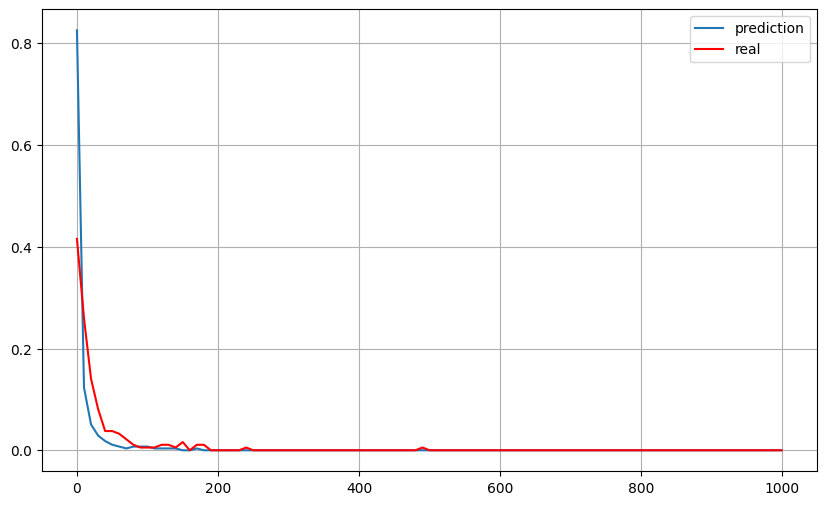

For ottawashooting_524924619812511746, with 15 total msgs


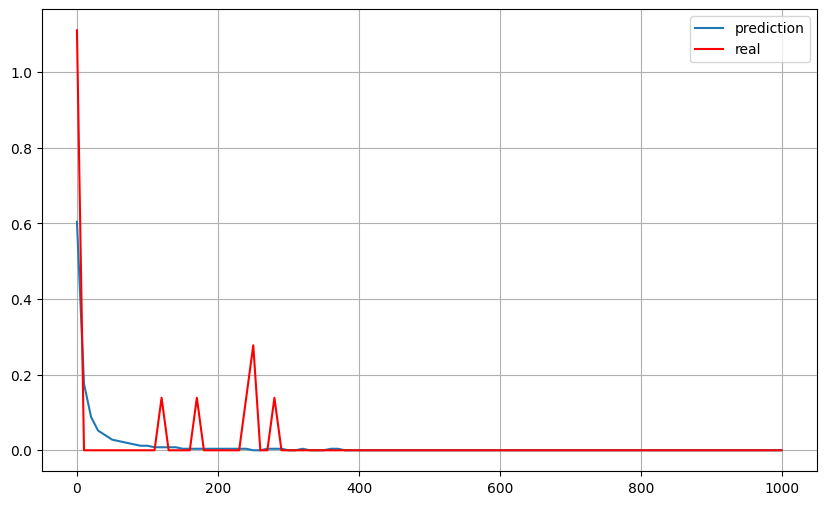

For ottawashooting_524925730053181440, with 459 total msgs


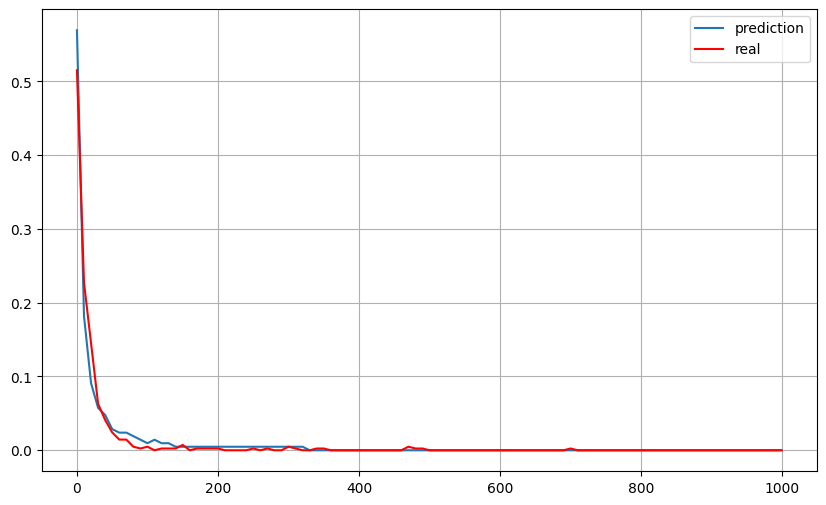

For ottawashooting_524926235030589440, with 79 total msgs


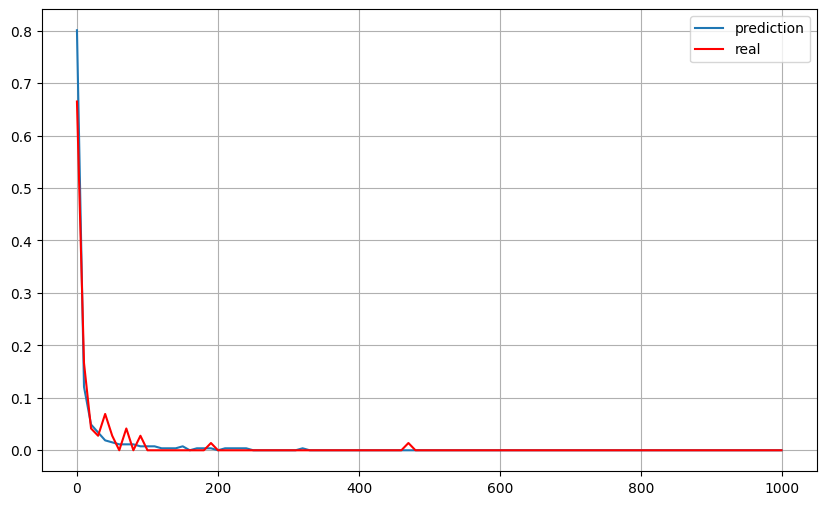

For ottawashooting_524927281048080385, with 707 total msgs


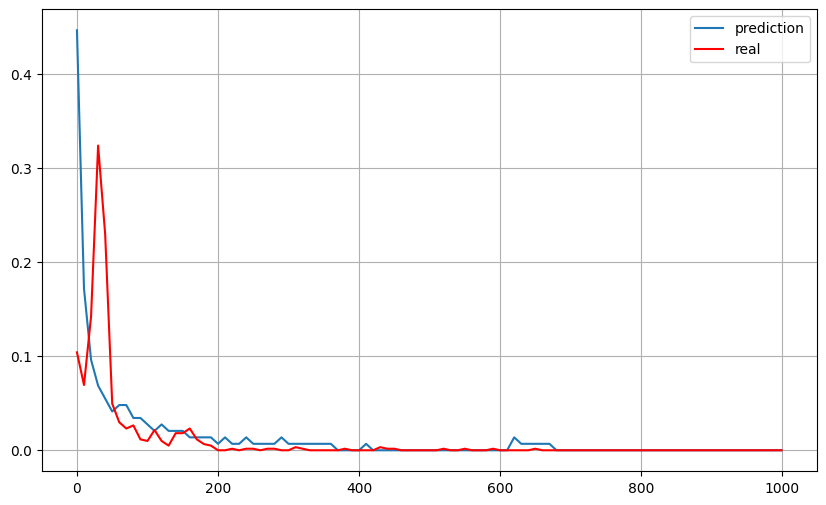

For ottawashooting_524931324763992064, with 137 total msgs


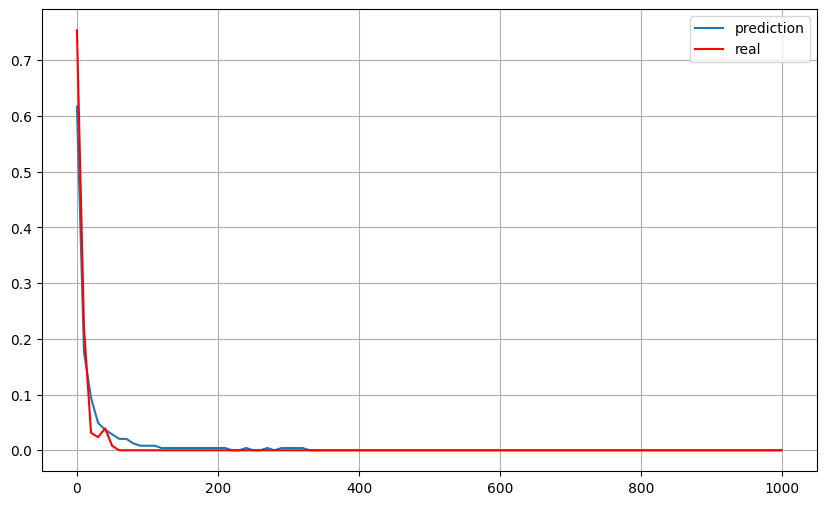

For ottawashooting_524932056560963584, with 11 total msgs


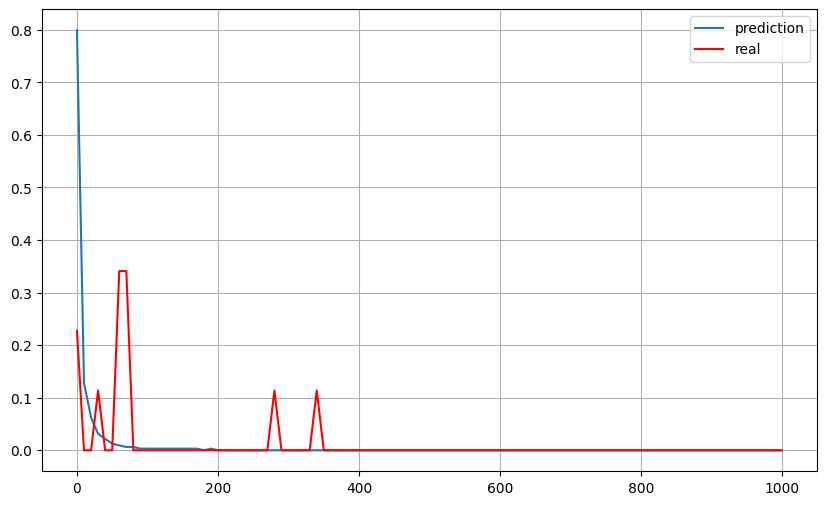

For ottawashooting_524932935137628160, with 202 total msgs


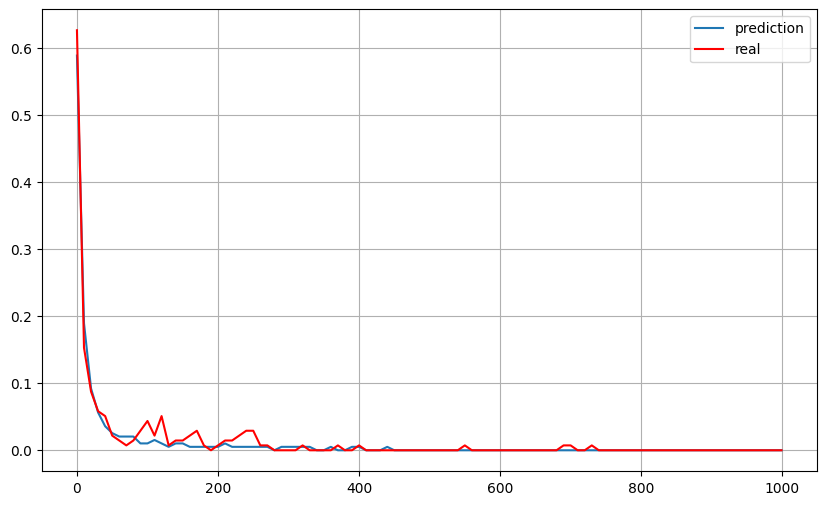

For ottawashooting_524935485370929152, with 102 total msgs


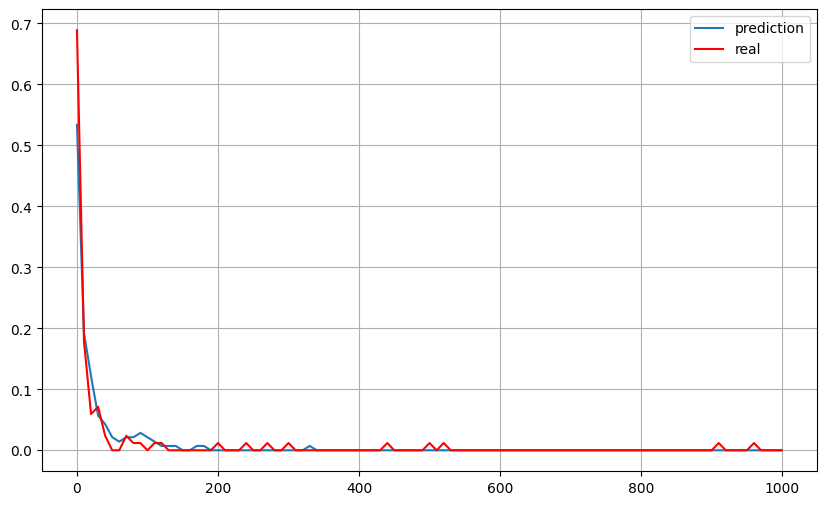

For ottawashooting_524936872666353664, with 780 total msgs


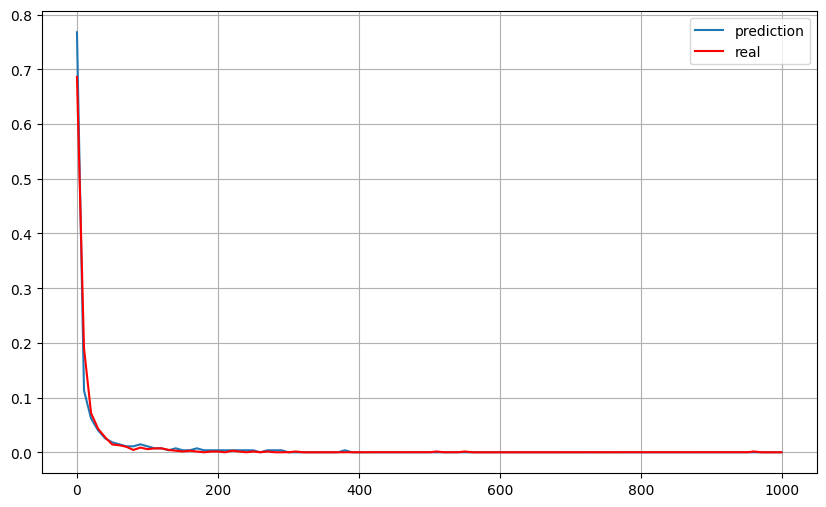

For ottawashooting_524937542131793920, with 196 total msgs


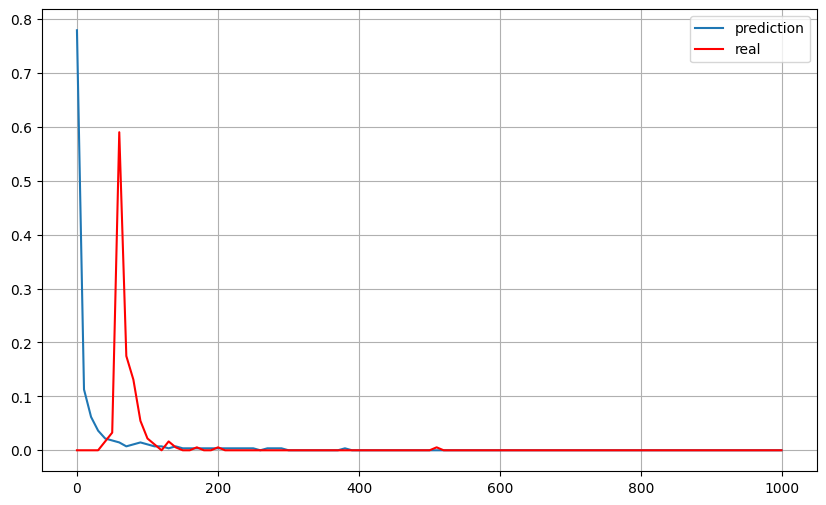

For ottawashooting_524941132237910016, with 66 total msgs


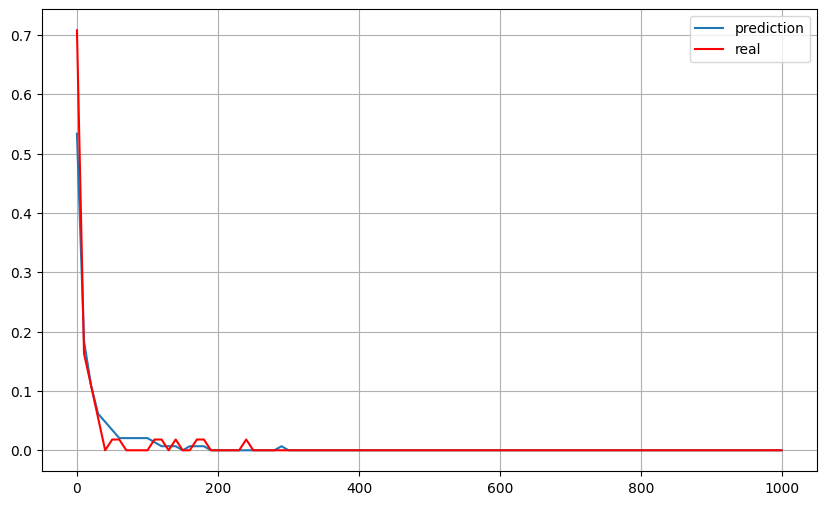

For ottawashooting_524942470472548352, with 13 total msgs


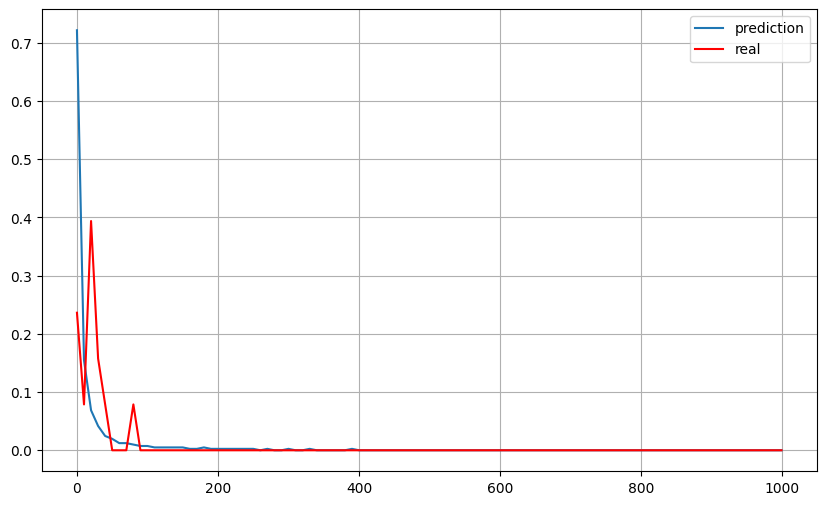

For ottawashooting_524943490887991296, with 509 total msgs


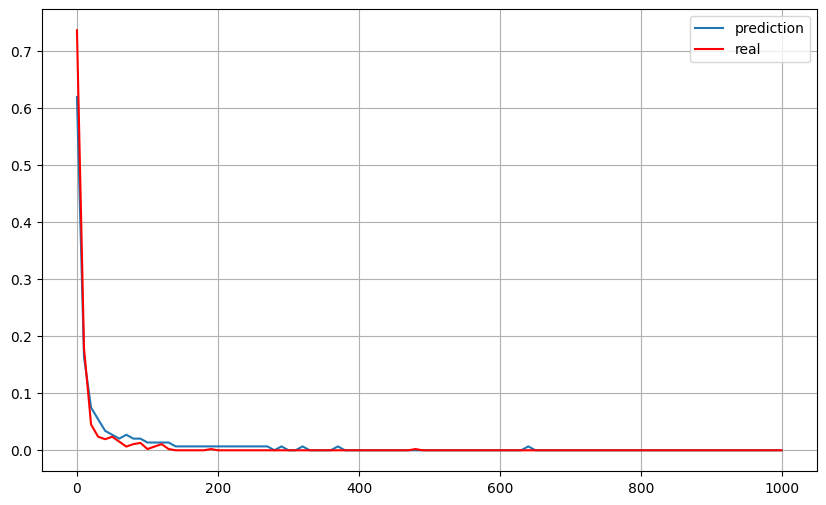

For ottawashooting_524944399890124801, with 684 total msgs


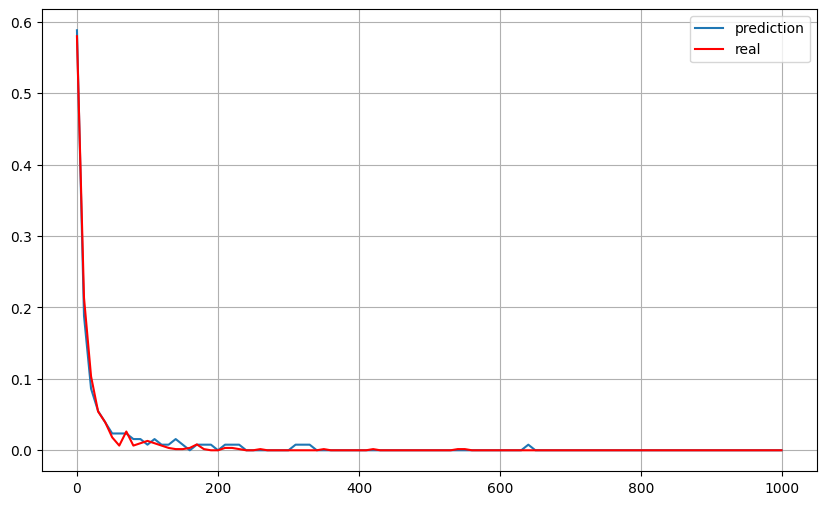

For ottawashooting_524947416869388288, with 222 total msgs


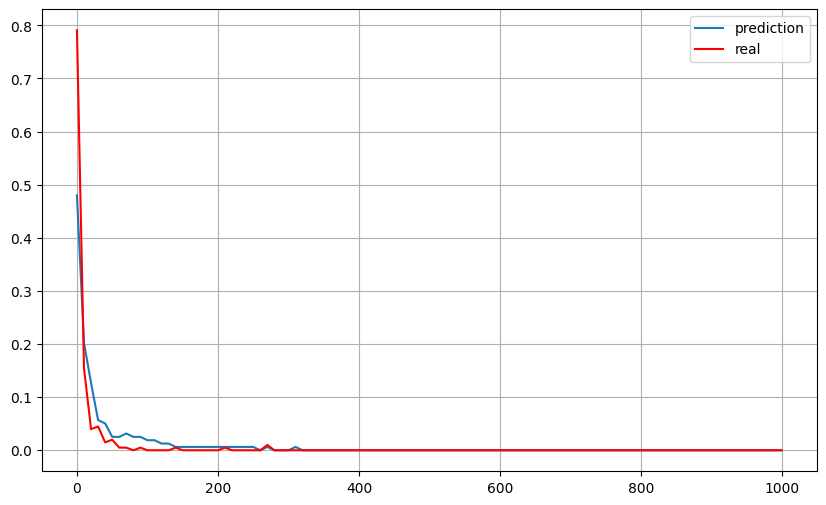

For ottawashooting_524947674164760577, with 135 total msgs


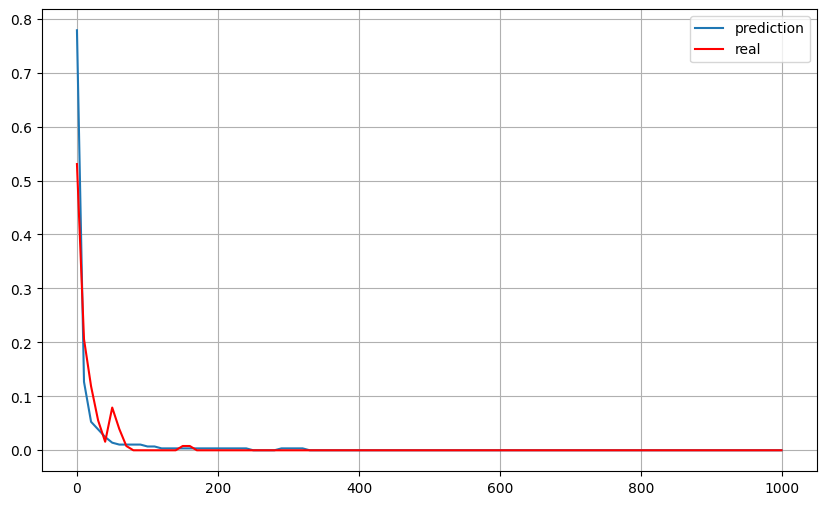

For ottawashooting_524948866773184512, with 171 total msgs


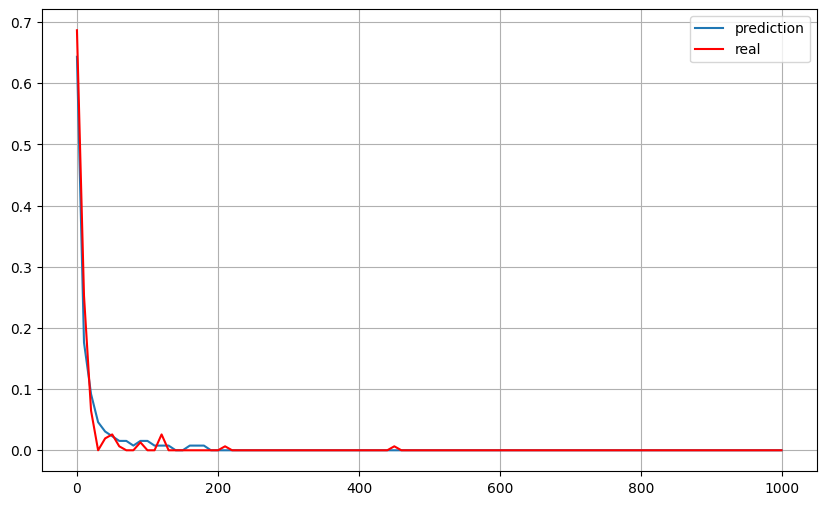

For ottawashooting_524949443607412737, with 229 total msgs


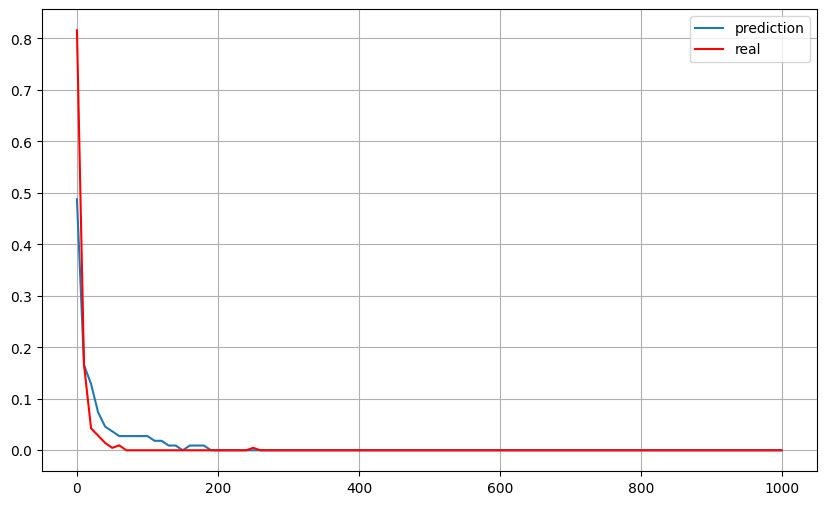

For ottawashooting_524956129017995264, with 645 total msgs


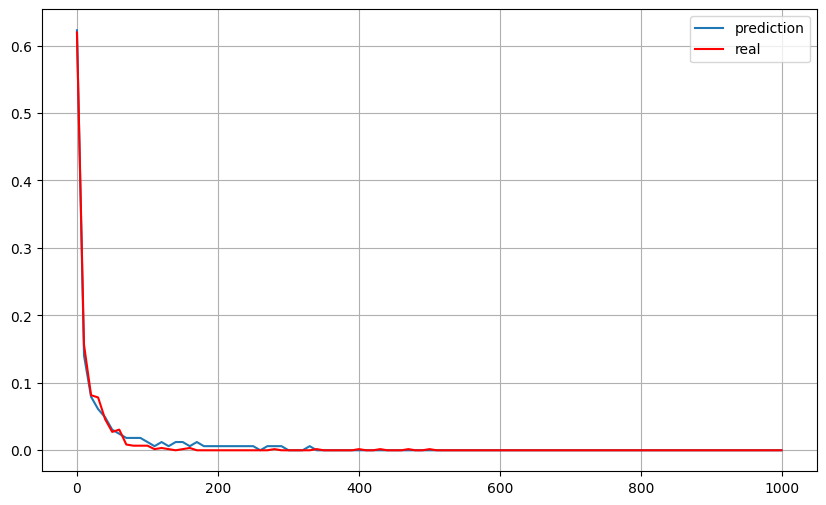

For ottawashooting_524962142563610625, with 177 total msgs


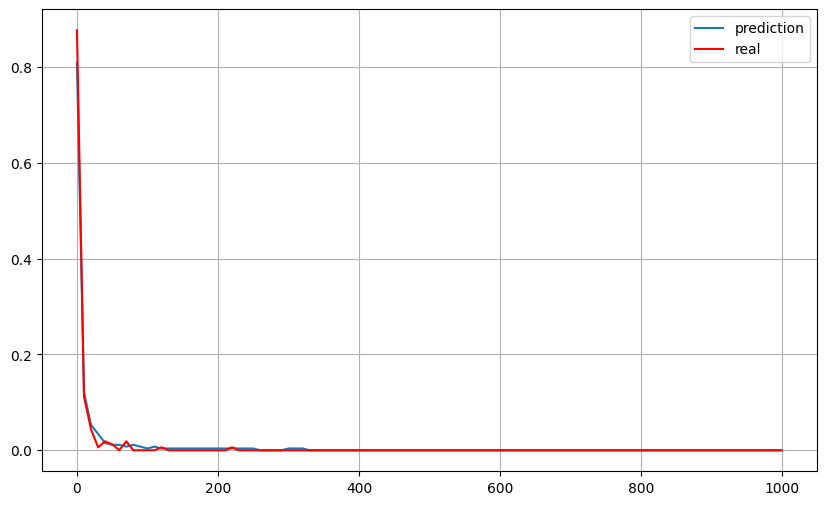

For ottawashooting_524964948683005952, with 721 total msgs


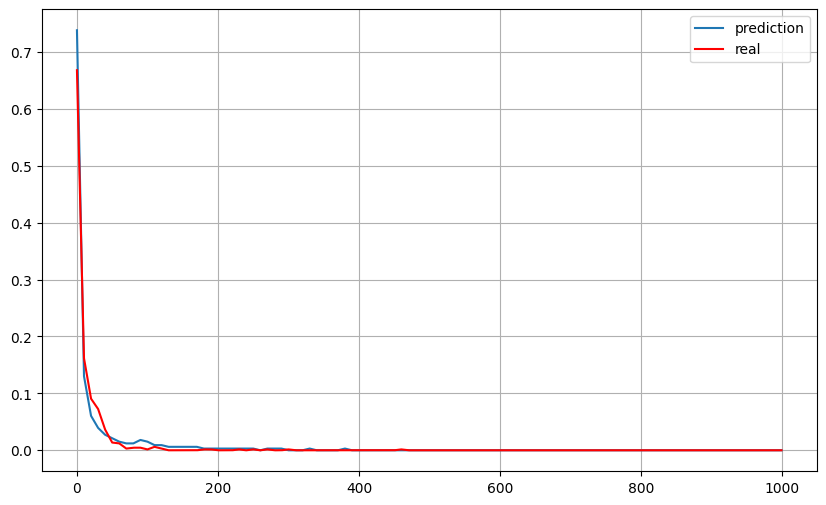

For ottawashooting_524965775036387329, with 160 total msgs


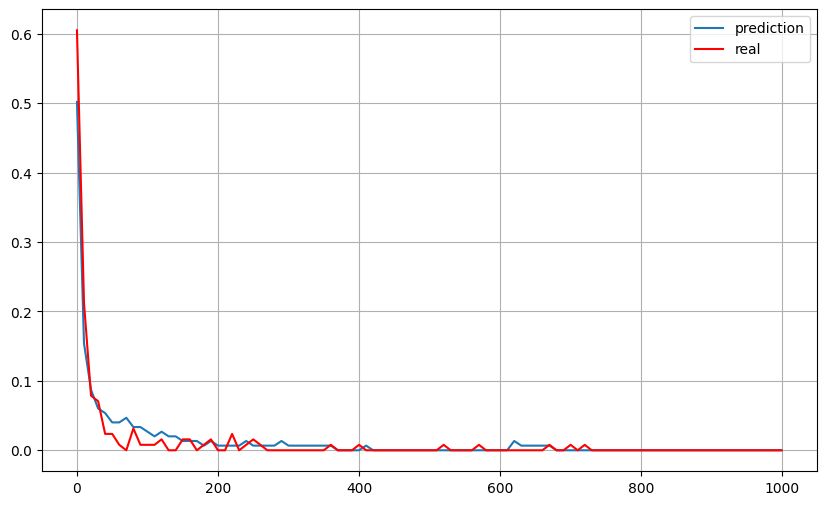

For ottawashooting_524972443308683264, with 152 total msgs


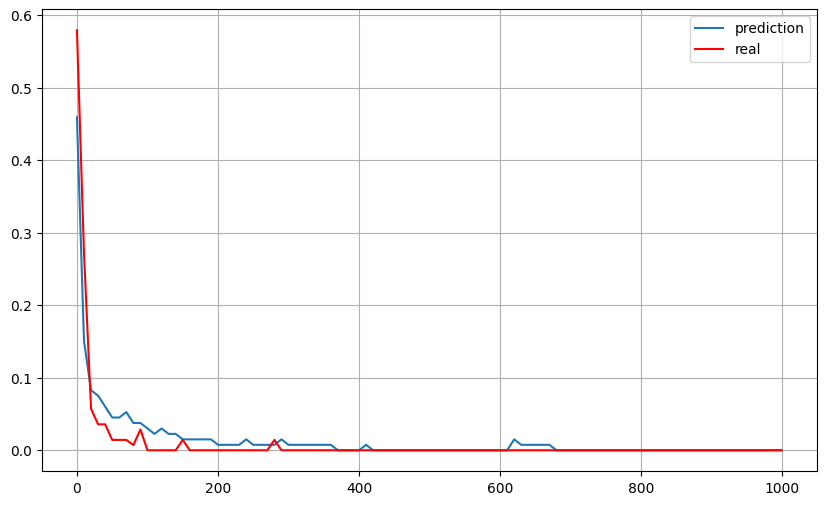

For ottawashooting_524975705206304769, with 382 total msgs


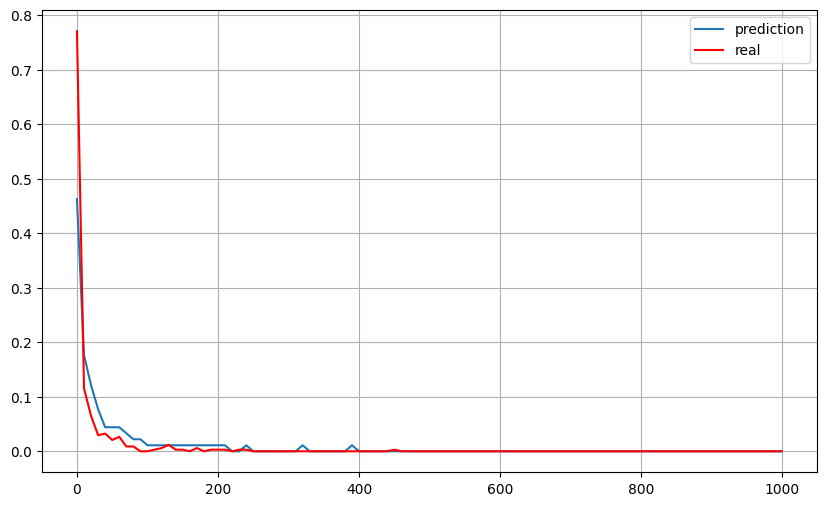

For ottawashooting_524981436252950528, with 175 total msgs


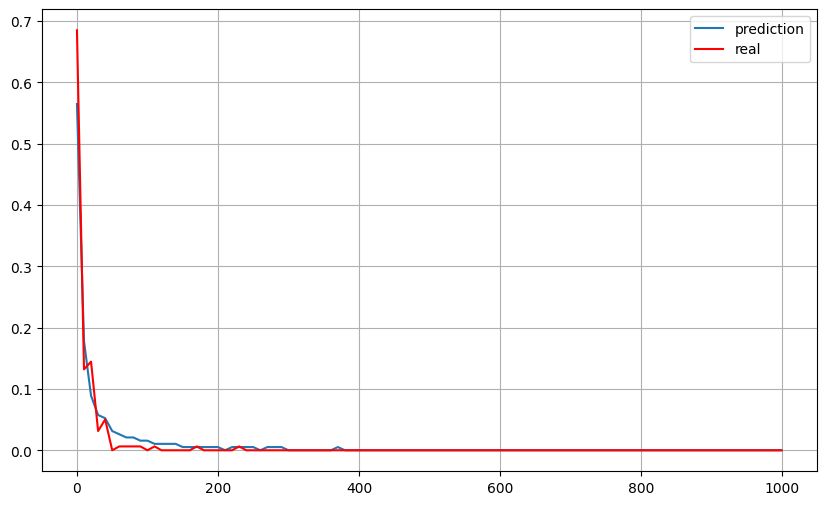

For ottawashooting_524990163446140928, with 267 total msgs


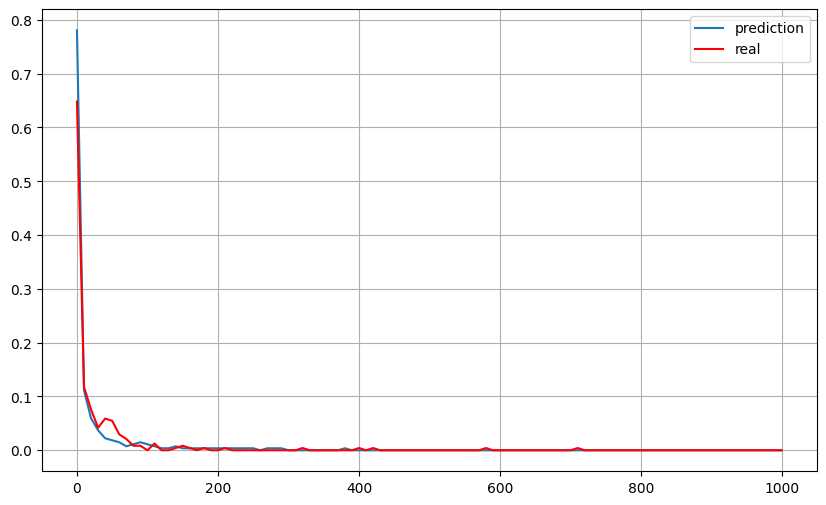

For ottawashooting_524993533212897281, with 214 total msgs


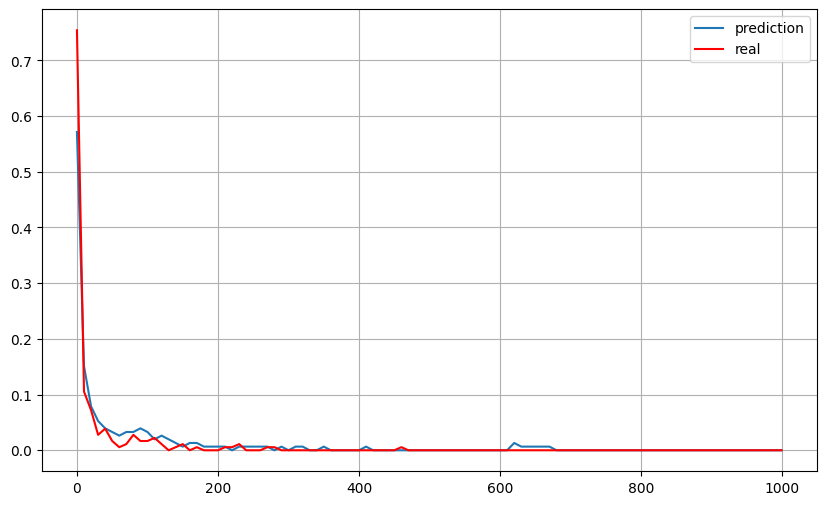

For ottawashooting_524995771587108864, with 106 total msgs


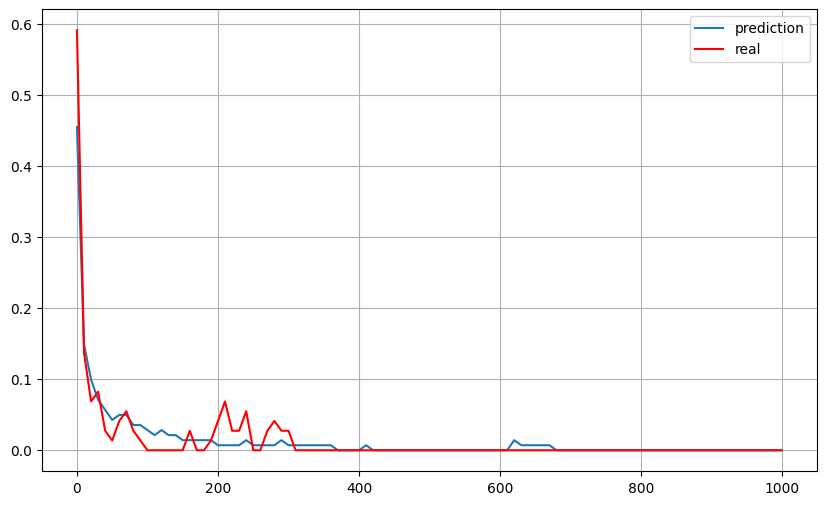

For ottawashooting_525003468659228672, with 385 total msgs


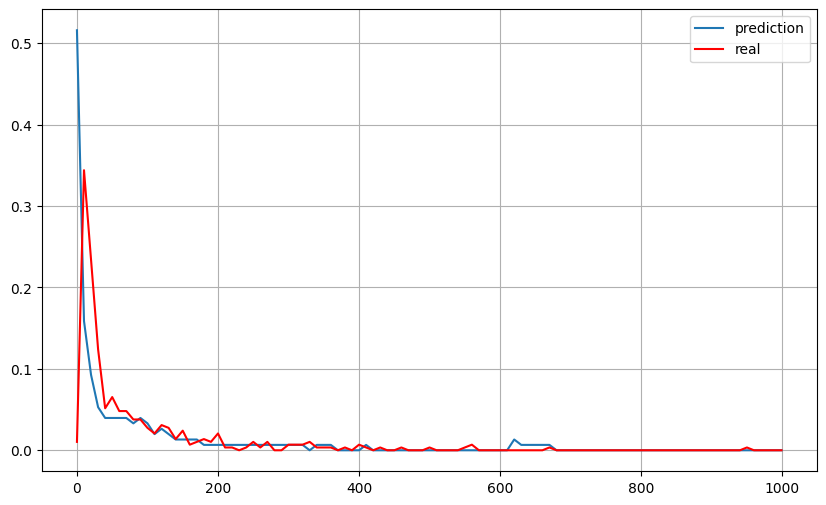

For ottawashooting_525019752507658240, with 505 total msgs


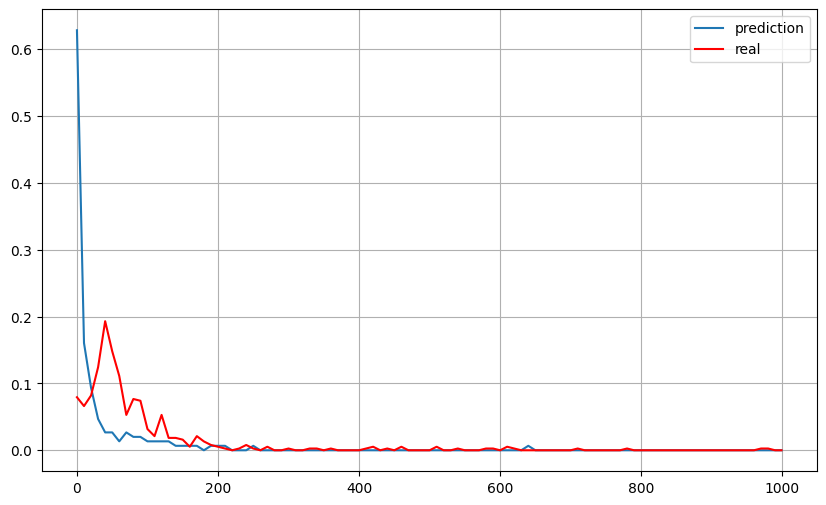

For ottawashooting_525023025792835585, with 117 total msgs


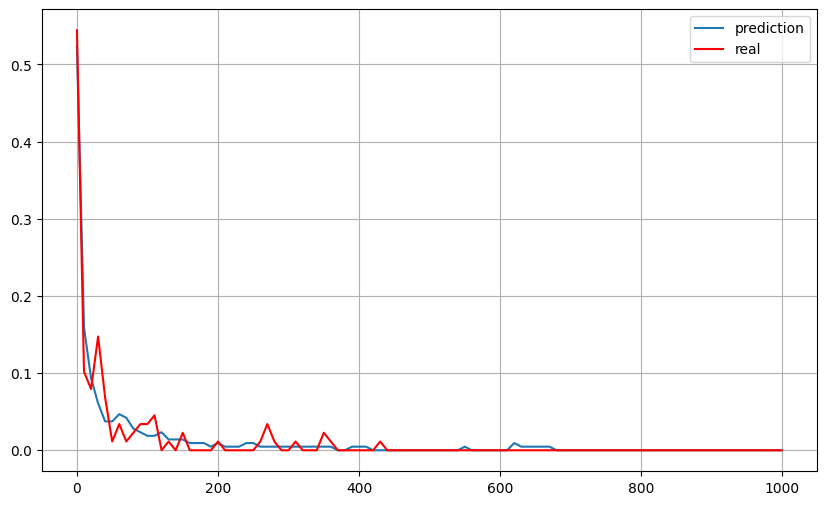

For ottawashooting_525025279803424768, with 115 total msgs


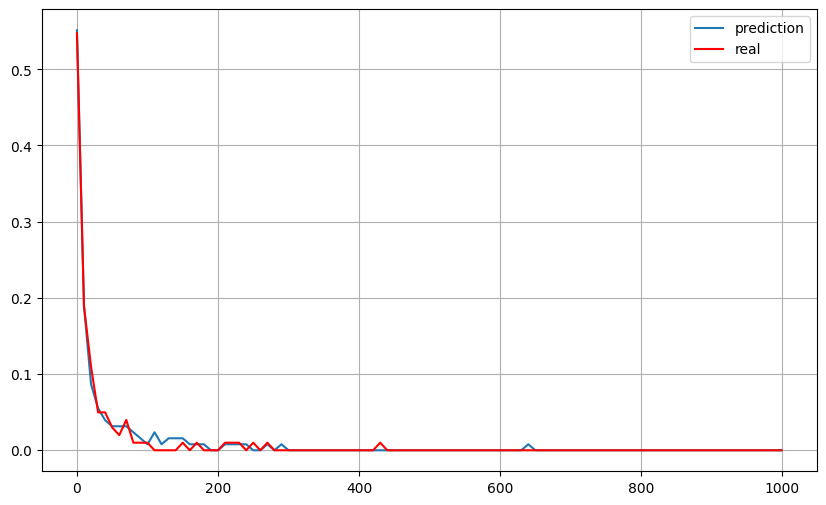

For ottawashooting_525025463648137216, with 146 total msgs


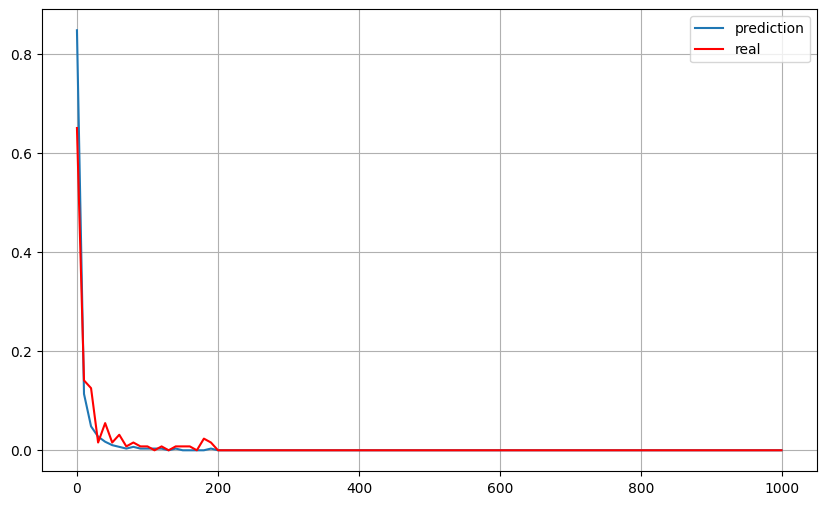

For ottawashooting_525028734991343617, with 119 total msgs


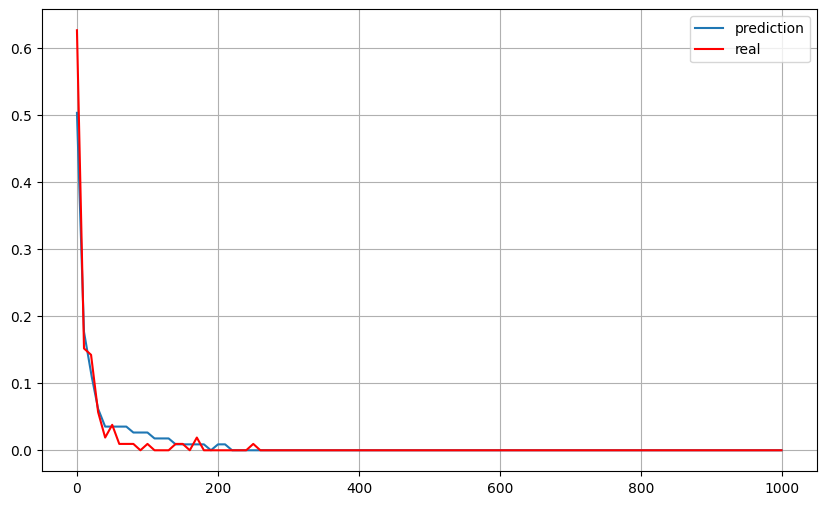

For ottawashooting_525049639016615937, with 182 total msgs


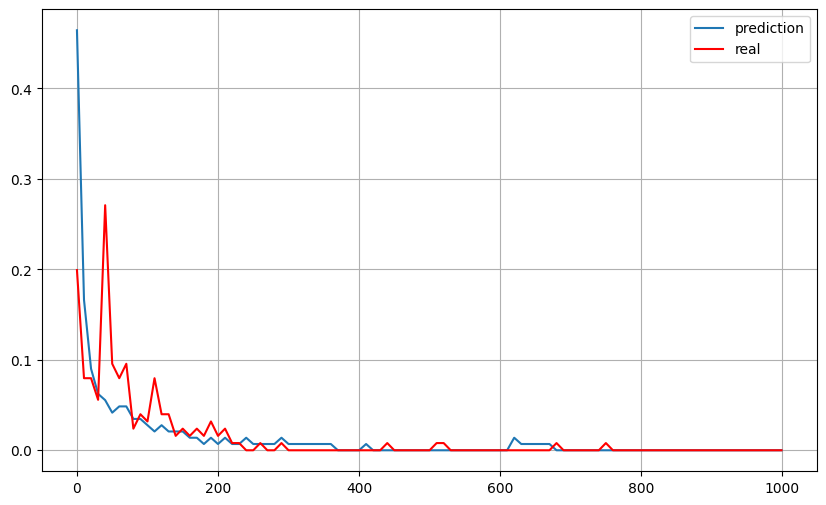

For ottawashooting_525056576038518785, with 1052 total msgs


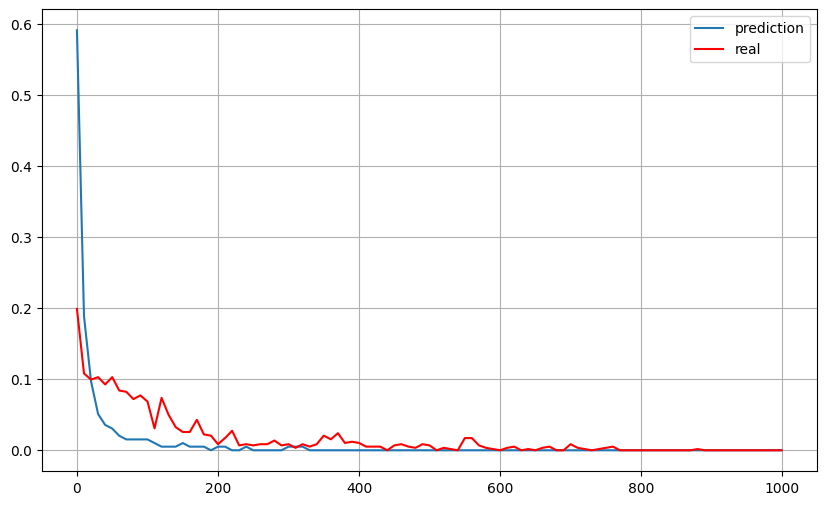

For ottawashooting_525058976376193024, with 235 total msgs


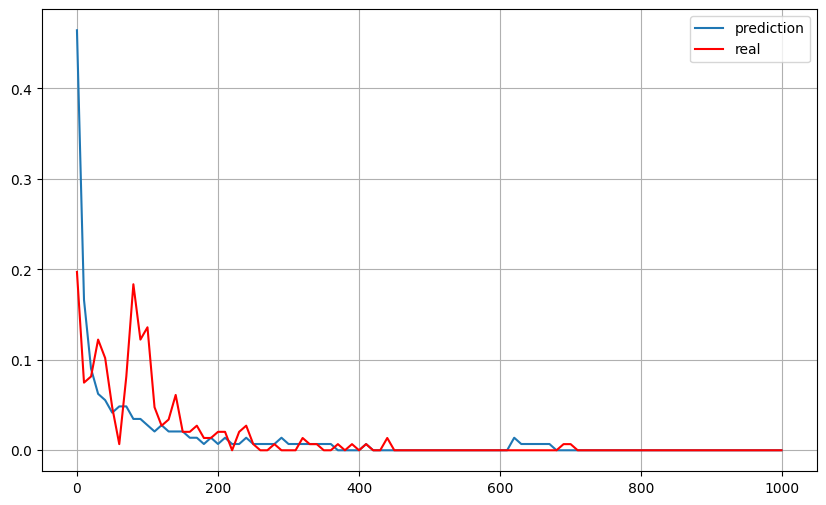

In [ ]:
window = 10
main_list = []
#unique_idxs = df_predicts.iloc[13]['unique_idx']
d_pr = {}

for j in range(0, len(timeline.iloc[36]['result_pred_round'])):
  value = unique_idxs[j]
  print(f"For {value}, with {test[test['unique_idx'] ==value].iloc[0]['combined_preds']} total msgs")
  sim = np.asarray(timeline.iloc[36]['result_pred_round'])[j]
  real = np.asarray(timeline.iloc[36]['test_pred'])[j]

  sim = np.asarray(list(np.repeat(sim[1:], window))) # discard beginning, no effect diff
  real = np.asarray(list(np.repeat(real[1:], window)))

  list_sim = []
  list_real = []

  for i in range(len(sim) - window + 1):
    list_sim.append(round((sum(sim[i: i + window])) / sum(sim[1:100]), 10))
    list_real.append(round((sum(real[i: i + window])) / sum(real[1:100]), 10))

  main_list.append(list_sim[0:1000]) # limit sims, remove leading zeros

  d_pr[unique_idxs[j]] = list_sim[0:1000]

  ys = list_sim[0:1000]
  xs = [x for x in range(len(ys))]
  plt.figure(figsize=(10, 6))
  plt.plot(xs,ys, label='prediction')


  ys = list_real[0:1000]
  xs = [x for x in range(len(ys))]
  plt.plot(xs,ys, '-r', label='real')
  plt.legend(loc="upper right")
  plt.grid(True)
  plt.show()

In [ ]:
test_pred_set

is_rumour           theme                  id  is_turnaround  \
0     rumour  ottawashooting  524922729485848576              0   
1     rumour  ottawashooting  524923462398513152              0   
2     rumour  ottawashooting  524923676484177920              0   
3     rumour  ottawashooting  524924619812511746              0   
4     rumour  ottawashooting  524925050739490816              0   
5     rumour  ottawashooting  524925215235911680              0   
6     rumour  ottawashooting  524925730053181440              0   
7     rumour  ottawashooting  524925987239120897              0   
8     rumour  ottawashooting  524926235030589440              0   
9     rumour  ottawashooting  524926472432410625              0   
10    rumour  ottawashooting  524927281048080385              0   
11    rumour  ottawashooting  524929497205055488              0   
12    rumour  ottawashooting  524931324763992064              0   
13    rumour  ottawashooting  524932056560963584              0   
14    rumour  ottawashooting  524932935137628160              0   
15    rumour  ottawashooting  524935485370929152              0   
16    rumour  ottawashooting  524936872666353664              0   
17    rumour  ottawashooting  524937542131793920              0   
18    rumour  ottawashooting  524940659778920448              0   
19    rumour  ottawashooting  524941132237910016              1   
20    rumour  ottawashooting  524942470472548352              0   
21    rumour  ottawashooting  524943490887991296              0   
22    rumour  ottawashooting  524944399890124801              0   
23    rumour  ottawashooting  524947416869388288              0   
24    rumour  ottawashooting  524947674164760577              0   
25    rumour  ottawashooting  524947867975561216              0   
26    rumour  ottawashooting  524948866773184512              0   
27    rumour  ottawashooting  524949443607412737              0   
28    rumour  ottawashooting  524952883343925249              0   
29    rumour  ottawashooting  524956129017995264              0   
30    rumour  ottawashooting  524959809402331137              0   
31    rumour  ottawashooting  524962142563610625              0   
32    rumour  ottawashooting  524964948683005952              0   
33    rumour  ottawashooting  524965775036387329              0   
34    rumour  ottawashooting  524966904885428226              0   
35    rumour  ottawashooting  524969201102901248              1   
36    rumour  ottawashooting  524970851675176960              0   
37    rumour  ottawashooting  524972443308683264              0   
38    rumour  ottawashooting  524975705206304769              0   
39    rumour  ottawashooting  524980744658382848              0   
40    rumour  ottawashooting  524981436252950528              0   
41    rumour  ottawashooting  524983581983375360              1   
42    rumour  ottawashooting  524990163446140928              0   
43    rumour  ottawashooting  524991576163250176              0   
44    rumour  ottawashooting  524993533212897281              0   
45    rumour  ottawashooting  524995771587108864              0   
46    rumour  ottawashooting  525003468659228672              0   
47    rumour  ottawashooting  525019752507658240              0   
48    rumour  ottawashooting  525023025792835585              0   
49    rumour  ottawashooting  525025279803424768              0   
50    rumour  ottawashooting  525025463648137216              0   
51    rumour  ottawashooting  525028734991343617              1   
52    rumour  ottawashooting  525032872647065600              0   
53    rumour  ottawashooting  525049639016615937              0   
54    rumour  ottawashooting  525056576038518785              0   
55    rumour  ottawashooting  525058976376193024              0   
56    rumour  ottawashooting  525060425184858112              0   
57    rumour  ottawashooting  525068915068923904              0   

    misinformation  true                         

Now we combine with the news file.

In [ ]:
test_pred_set['pred_timeline'] = test_pred_set['unique_idx'].apply(lambda x: d_pr[x])

In [ ]:
combined_news_scs['pred_timeline'] = test['pred_timeline']

In [ ]:
def edit_list(l_vals):
  st = f"{l_vals[0]}"
  for el in l_vals:
    st += f";{el}"
  return st

combined_news_scs['pred_timeline_str'] = combined_news_scs['pred_timeline'].apply(lambda x: edit_list(x))

In [ ]:
combined_news_scs.to_json(path_sav + "combined_news_full.json")

In [ ]:
combined_news_scs = pd.read_json(path_sav + "combined_news_full.json")

We save in independent files. These ones we use for the simulator.

In [ ]:
for elem in combined_news_scs.thread_from.unique():
  sel = combined_news_scs[combined_news_scs['thread_from'] == elem]
  sel[['thread_from', 'id_str', 'tick', "novelty", 'prediction_probab', 'pred_timeline_str']].to_csv(path_sav+f"\\news_sim_edited3\\news_content_{elem}.csv", index=False)